In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import datetime

#Statistics
# Statistics
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from scipy.special import inv_boxcox
from scipy.stats import boxcox
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from dateutil.parser import parse 
import pickle

# READ CSV AND DESCRIPTION OF SERIES


In [2]:
#SOPR
SOPR = pd.read_csv("data/bitcoin-spent-output-profit-ratio-sopr.csv")

SOPR["SOPR/t"] = SOPR["SOPR/t"].str.rstrip("T00:00:00.000Z")
SOPR["SOPR/t"] = pd.to_datetime(SOPR["SOPR/t"])
SOPR = SOPR.sort_values(by='SOPR/t')
SOPR = SOPR.rename(columns={'SOPR/t': 'Timestamp', 'SOPR/v': 'Value'})

################ RIMUOVO DATE 2009 E 2022
SOPR = SOPR[~(SOPR['Timestamp'] < '2012-01-01')]
SOPR = SOPR[~(SOPR['Timestamp'] > '2021-12-31')]

#fixing index
SOPR.reset_index(drop=True, inplace=True)

#Description
print(SOPR.head())
print("\nShape is:", SOPR.shape)
print("\nSummary of the dataset:")
SOPR.describe()
print("\nAre there null values?")
SOPR.isna().sum()


   Timestamp     Value
0 2012-12-31  1.012306
1 2013-01-01  0.998396
2 2013-01-01  1.014277
3 2013-01-02  0.999711
4 2013-01-02  1.007465

Shape is: (3288, 2)

Summary of the dataset:

Are there null values?


Timestamp    0
Value        0
dtype: int64

In [3]:
# Extract years
SOPR['year'] = [d.year for d in SOPR["Timestamp"]]

SOPR.year.unique()

SOPR.year.value_counts()

SOPR.head(20)

Timestamp     Value  year
0  2012-12-31  1.012306  2012
1  2013-01-01  0.998396  2013
2  2013-01-01  1.014277  2013
3  2013-01-02  0.999711  2013
4  2013-01-02  1.007465  2013
5  2013-01-03  1.020616  2013
6  2013-01-03  1.000494  2013
7  2013-01-04  1.002167  2013
8  2013-01-05  1.000162  2013
9  2013-01-06  0.999756  2013
10 2013-01-07  1.001321  2013
11 2013-01-08  1.005527  2013
12 2013-01-09  1.004561  2013
13 2013-01-11  1.009839  2013
14 2013-01-12  1.006252  2013
15 2013-01-13  1.006008  2013
16 2013-01-14  1.004949  2013
17 2013-01-15  1.007028  2013
18 2013-01-16  1.006835  2013
19 2013-01-17  1.016956  2013

In [4]:
SOPRvalue0=(SOPR["Value"].iloc[0] + SOPR["Value"].iloc[1])/2
SOPRvalue1=(SOPR["Value"].iloc[2] + SOPR["Value"].iloc[3])/2
SOPRvalue2=(SOPR["Value"].iloc[4] + SOPR["Value"].iloc[5])/2

print(SOPRvalue0, SOPRvalue1, SOPRvalue2)

1.0053508039459456 1.0069939826642345 1.014040749648085


In [5]:
SOPR = SOPR.drop(labels=0, axis=0)
SOPR = SOPR.drop(labels=2, axis=0)
SOPR = SOPR.drop(labels=4, axis=0)

#fixing index
SOPR.reset_index(drop=True, inplace=True)

SOPR["Value"].iloc[0] = SOPRvalue0
SOPR["Value"].iloc[1] = SOPRvalue1
SOPR["Value"].iloc[2] = SOPRvalue2

SOPR

<ipython-input-5-f61673b88ebb>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SOPR["Value"].iloc[0] = SOPRvalue0
<ipython-input-5-f61673b88ebb>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SOPR["Value"].iloc[1] = SOPRvalue1
<ipython-input-5-f61673b88ebb>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SOPR["Value"].iloc[2] = SOPRvalue2


Timestamp     Value  year
0    2013-01-01  1.005351  2013
1    2013-01-02  1.006994  2013
2    2013-01-03  1.014041  2013
3    2013-01-03  1.000494  2013
4    2013-01-04  1.002167  2013
...         ...       ...   ...
3280 2021-12-26  1.000288  2021
3281 2021-12-27  1.002434  2021
3282 2021-12-28  0.997417  2021
3283 2021-12-29  0.997904  2021
3284 2021-12-31  1.000377  2021

[3285 rows x 3 columns]

# VISUALIZATION

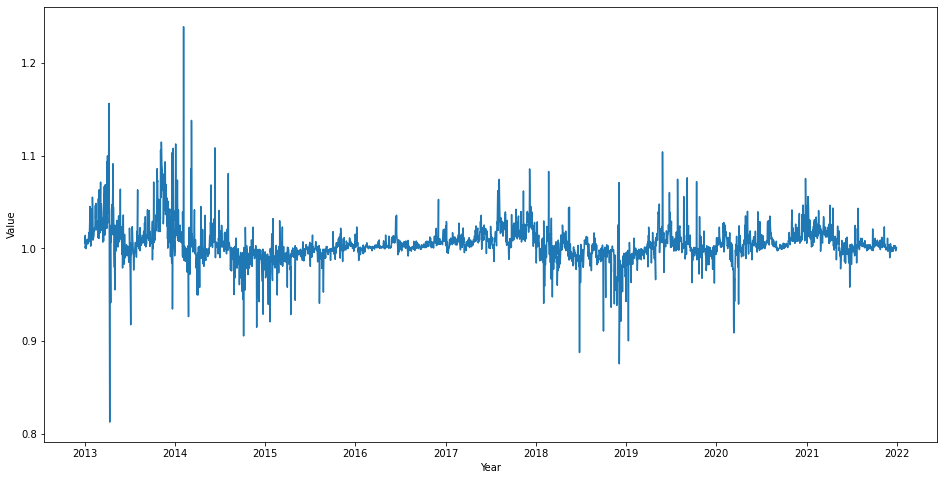

In [6]:
plt.figure(figsize=(16,8))
plt.plot(SOPR["Timestamp"], SOPR["Value"])
plt.gca().set(xlabel="Year", ylabel="Value")
#scommentare riga giù per visualizzare in scala log
#plt.yscale('log') 
plt.show()

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


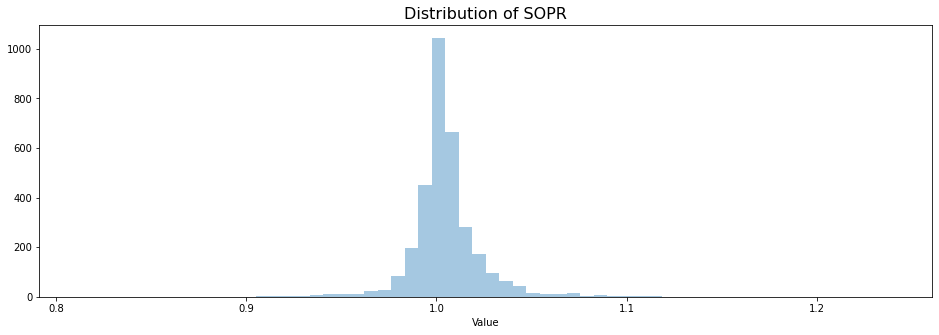

In [7]:
plt.figure(figsize=(16,5))
sns.distplot(SOPR["Value"], kde = False, bins = 60)
plt.title('Distribution of SOPR', fontsize=16)
plt.show()

<IPython.core.display.Javascript object>


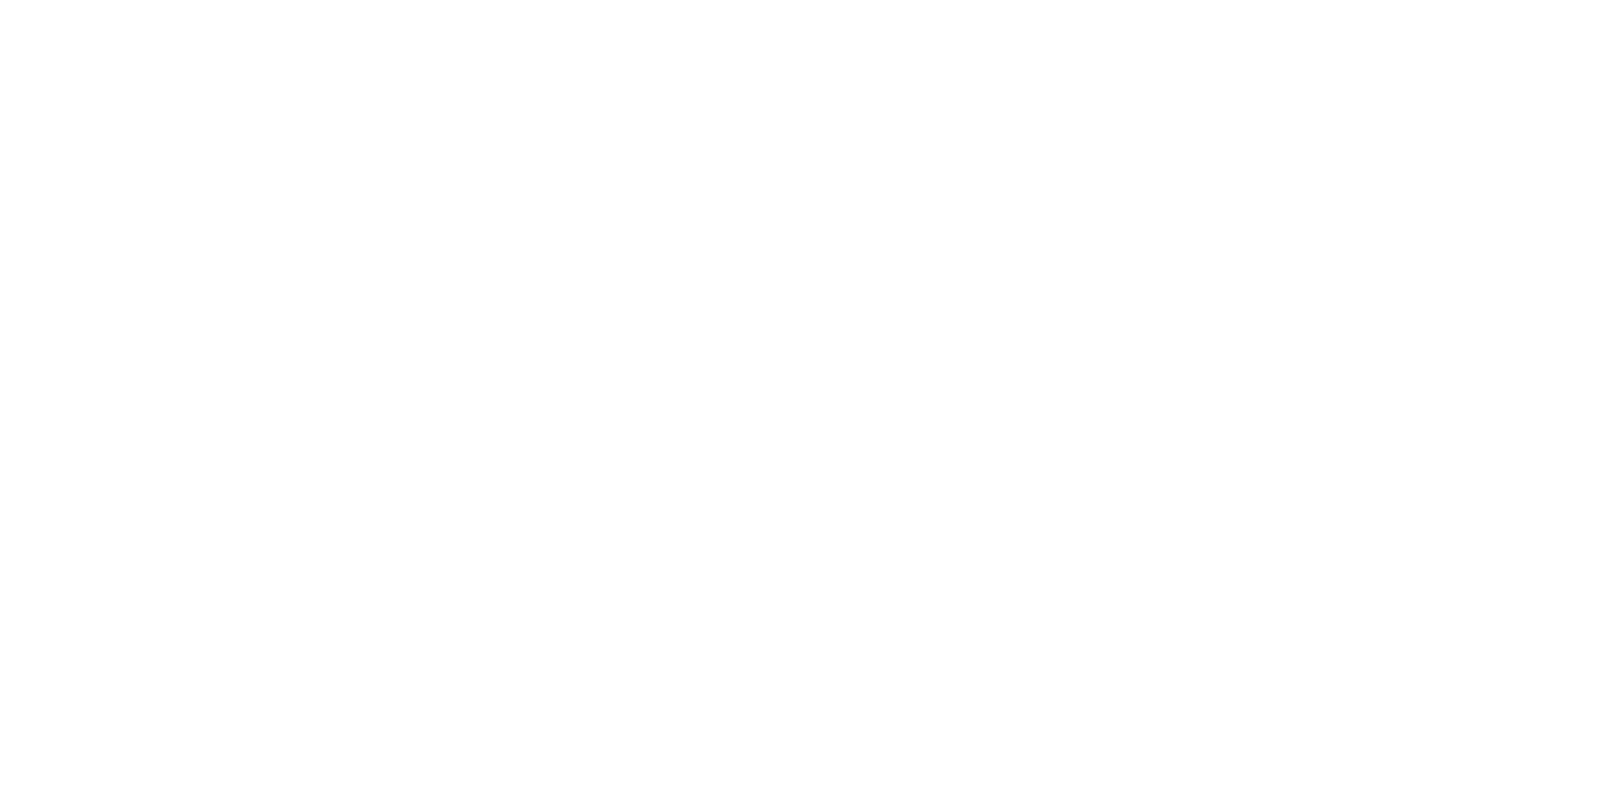

In [8]:
%matplotlib notebook
#MARKET PRICE
market_price = pd.read_csv("data/market-price.csv")

market_price['Timestamp'] = market_price['Timestamp'].str.split(' ').str[0]
market_price["Timestamp"] = pd.to_datetime(market_price["Timestamp"])
market_price = market_price.rename(columns={'market-price': 'Price'})

################ RIMUOVO DATE 2009 E 2022
market_price = market_price[~(market_price['Timestamp'] < '2013-01-01')]
market_price = market_price[~(market_price['Timestamp'] > '2021-12-31')]


fig, ax1 = plt.subplots(figsize=(16,8))

color = 'tab:red'
ax1.set_xlabel('Years')
ax1.set_ylabel('SOPR', color=color)
ax1.plot(SOPR["Timestamp"], SOPR["Value"], color=color, label='SOPR')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('BTC Price', color=color)  # we already handled the x-label with ax1
ax2.plot(market_price["Timestamp"], market_price["Price"], color=color, label='BTC Price')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yscale('log')

fig.legend(loc="upper left")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


#### Shorter time series
Same as market price

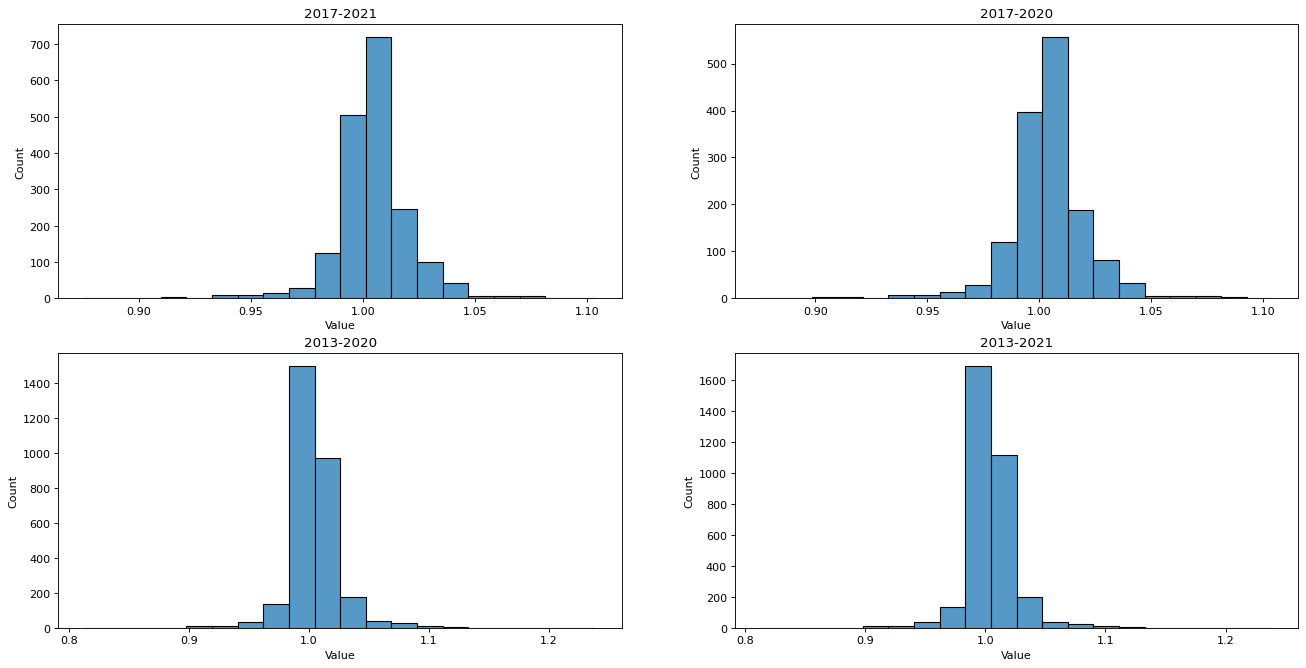

In [9]:
%matplotlib inline
SOPR["Value"][SOPR["Timestamp"].dt.year == 2014].mean()
SOPRh = SOPR.loc[(SOPR["Timestamp"].dt.year > 2016) & (SOPR["Timestamp"].dt.year < 2022),:]
SOPRn = SOPR.loc[(SOPR["Timestamp"].dt.year > 2016) & (SOPR["Timestamp"].dt.year < 2021),:]
SOPRnh = SOPR.loc[(SOPR["Timestamp"].dt.year > 2012) & (SOPR["Timestamp"].dt.year < 2021),:]
SOPRf = SOPR.loc[(SOPR["Timestamp"].dt.year > 2012) & (SOPR["Timestamp"].dt.year < 2022),:]

fig, axes = plt.subplots(2, 2, figsize=(20,10), dpi= 80)
sns.histplot(SOPRh["Value"], ax=axes[0,0],bins = 20)
sns.histplot(SOPRn["Value"], ax=axes[0,1],bins = 20)
sns.histplot(SOPRnh["Value"], ax=axes[1,0],bins = 20)
sns.histplot(SOPRf["Value"], ax=axes[1,1],bins = 20)
axes[0,0].title.set_text('2017-2021')
axes[0,1].title.set_text('2017-2020')
axes[1,0].title.set_text('2013-2020')
axes[1,1].title.set_text('2013-2021')

#### Checking monthly seasonality using multiple lines
Price follows a certain repetitive pattern every year? 

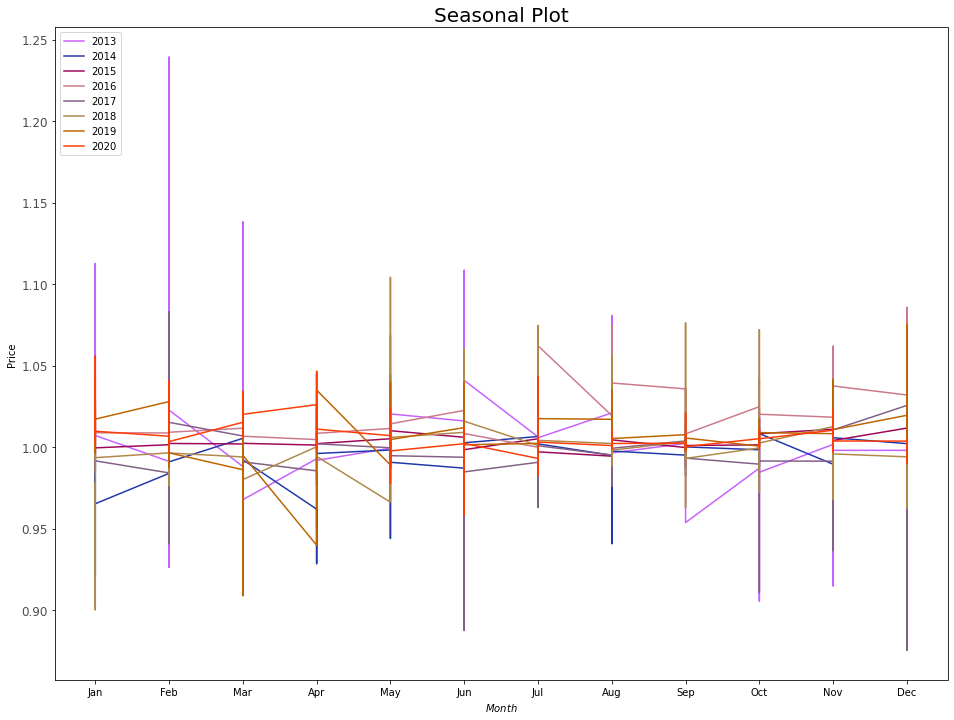

In [10]:
# Prepare data
SOPR['year'] = [d.year for d in SOPR["Timestamp"]]
SOPR['month'] = [d.strftime('%b') for d in SOPR["Timestamp"]]
years = SOPR['year'].unique()

# Prep Colors
np.random.seed(100)
mycolors = np.random.choice(list(matplotlib.colors.XKCD_COLORS.keys()), len(years), replace=False)

# Draw Plot
plt.figure(figsize=(16,12))
for i, y in enumerate(years):
    if i > 0:
        plt.plot('month', "Value", data=SOPR.loc[SOPR.year==y, :], color=mycolors[i], label=y)
        
# Decoration
plt.gca().set(ylabel= "Price", xlabel = '$Month$')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Seasonal Plot", fontsize=20)
plt.legend(years, loc='upper left')
plt.show()

#### Checking trend using boxplot
Price follows a yearly trend or monthly seasonality? 

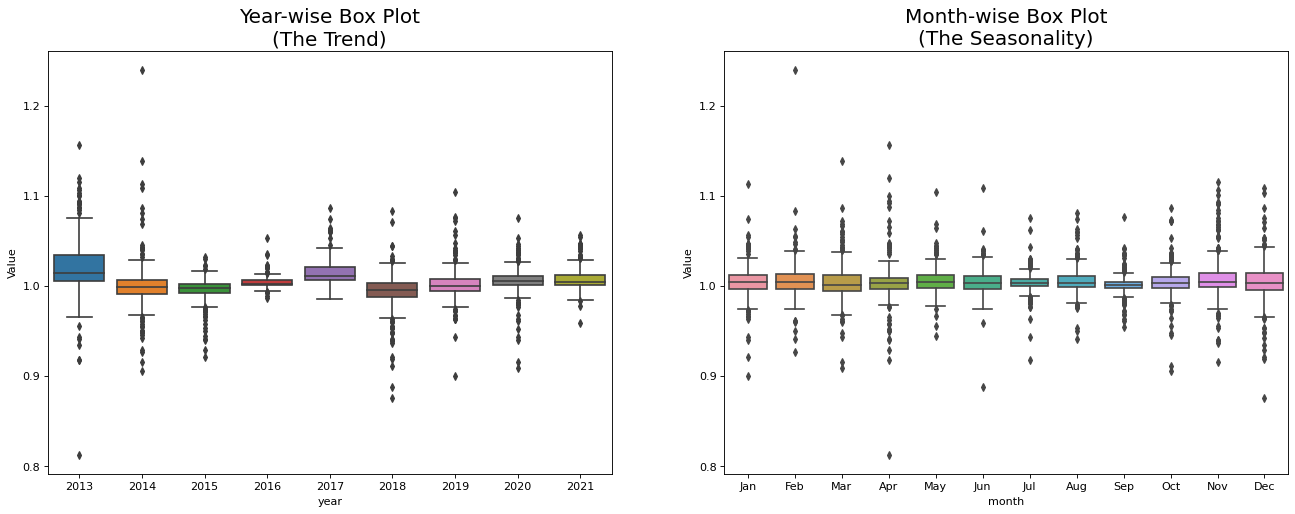

In [11]:
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y="Value", data=SOPR, ax=axes[0])
sns.boxplot(x='month', y="Value", data=SOPR.loc[~SOPR.year.isin([2010, 2022]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

Text(0.5, 0.98, 'SOPR / 2010-2021 ')

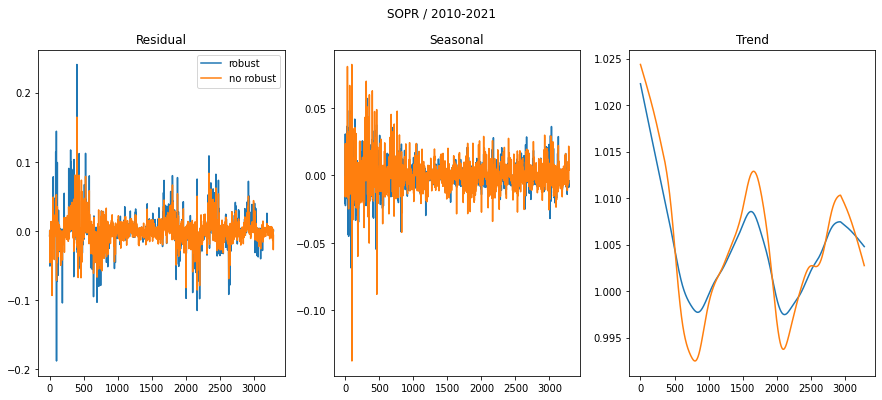

In [12]:
plt.rc("figure", figsize=(16, 16))
res1 = STL(SOPR["Value"], period=365, robust=True).fit()
res2 = STL(SOPR["Value"], period=365, robust=False).fit()

fig, axs = plt.subplots(ncols=3, figsize=(15,6))
axs[0].plot(res1.resid, label="robust")
axs[0].plot(res2.resid, label="no robust")
axs[0].legend()
axs[0].title.set_text('Residual')
axs[1].plot(res1.seasonal)
axs[1].plot(res2.seasonal)
axs[1].title.set_text('Seasonal')
axs[2].plot(res1.trend)
axs[2].plot(res2.trend)
axs[2].title.set_text('Trend')


fig.suptitle('SOPR / 2010-2021 ')

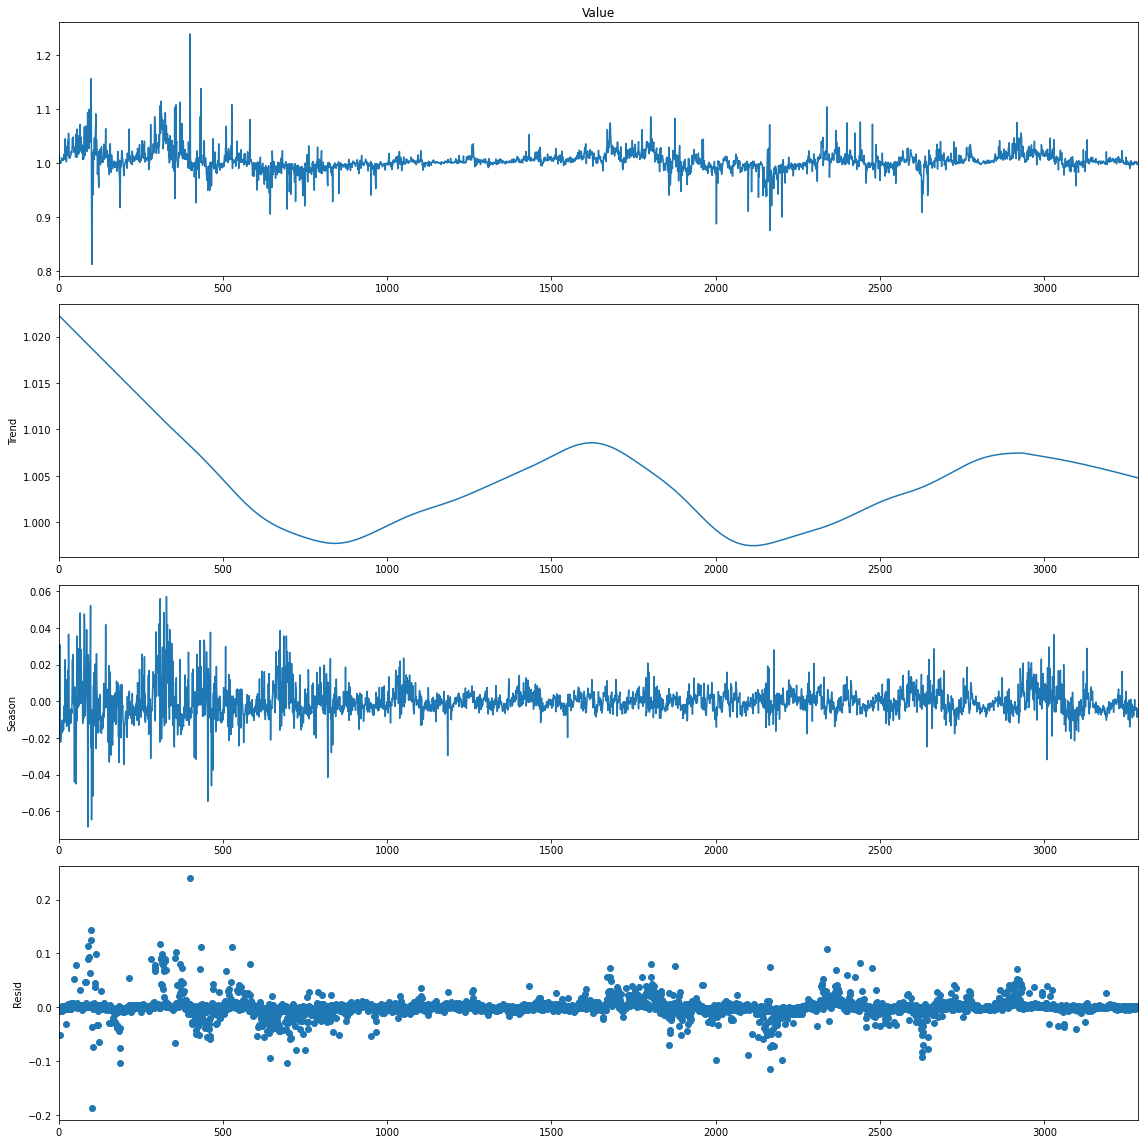

In [13]:
fig = res1.plot() #BIGGER VIEW

Text(0.5, 0.98, 'SOPR / 2017-2021 ')

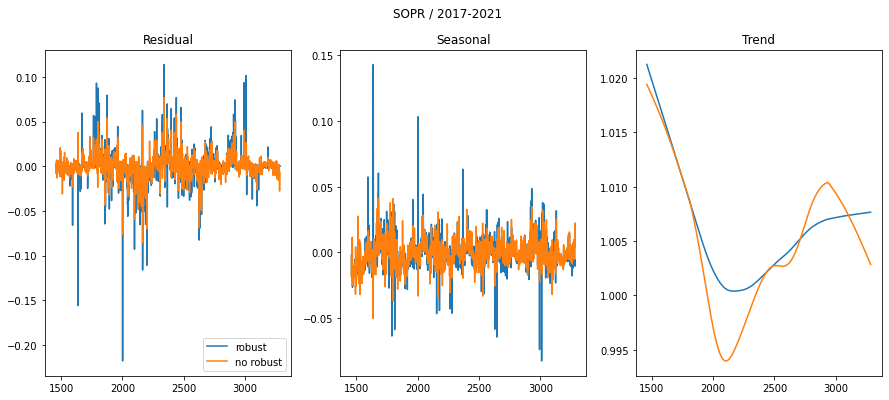

In [14]:
plt.rc("figure", figsize=(16, 16))
res3 = STL(SOPRh["Value"], period=365, robust=True).fit()
res4 = STL(SOPRh["Value"], period=365, robust=False).fit()

fig, axs = plt.subplots(ncols=3, figsize=(15,6))
axs[0].plot(res3.resid, label="robust")
axs[0].plot(res4.resid, label="no robust")
axs[0].legend()
axs[0].title.set_text('Residual')
axs[1].plot(res3.seasonal)
axs[1].plot(res4.seasonal)
axs[1].title.set_text('Seasonal')
axs[2].plot(res3.trend)
axs[2].plot(res4.trend)
axs[2].title.set_text('Trend')


fig.suptitle('SOPR / 2017-2021 ')

#### Trend interpolation
We now try to interploate the trend with an exponential function.

In [15]:
#CI SONO DEI NULL VALUES DENTRO IL TREND. HO TROVATO QUESTA TECNICA

np.log(res3.trend)

1459    0.021028
1460    0.020993
1461    0.020958
1462    0.020922
1463    0.020887
          ...   
3280    0.007624
3281    0.007626
3282    0.007627
3283    0.007629
3284    0.007630
Name: trend, Length: 1826, dtype: float64

In [16]:
# y = a*exp(bx) --> log(y) = log(a)+bx
idx = np.isfinite(np.arange(len(SOPRh))) & np.isfinite(np.log(res3.trend))
coefs = np.polyfit(np.arange(len(SOPRh))[idx]+1, np.log(res3.trend)[idx],1)
coefs
# y = exp(coefs[1])*exp(coefs[0]*x)

array([-3.43139723e-06,  9.48418613e-03])

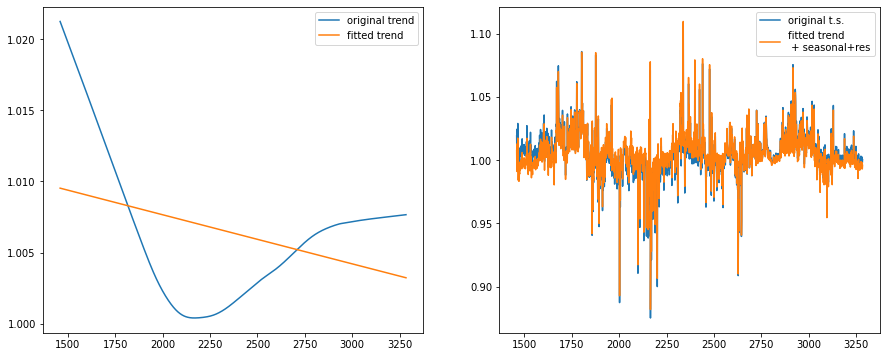

In [17]:
fitted = pd.Series(np.exp(coefs[1])*np.exp(coefs[0]*(np.arange(len(SOPRh))+1)), index = SOPRh.index)
#fitted.plot()
#res3.trend.plot()


fitted_season = fitted+res3.seasonal # fitted trend + seasonal decomposed series (orange) non so se ha senso calcolarlo
fitted_compl = fitted_season+res3.resid # fitted trend + seasonal decomposed series + residual decomposed series (green)
#hashh["Value"].plot()
#fitted_season.plot()
#fitted_compl.plot()


fig, axs = plt.subplots(ncols=2, figsize=(15,6))
axs[0].plot(res3.trend, label="original trend")
axs[0].plot(fitted, label="fitted trend")
axs[0].legend()
axs[1].plot(SOPRh["Value"], label='original t.s.')
#axs[1].plot(fitted_season, label='fitted trend\n + seasonal')
axs[1].plot(fitted_compl, label='fitted trend\n + seasonal+res')
axs[1].legend()

# TRAIN/VAL/TEST SPLIT

In [18]:
series = SOPR['Value']

# Create train data set
train_split_date = '2020-12-31'
train_split_index = np.where(SOPR.Timestamp == train_split_date)[0][0]
x_train = SOPR.loc[SOPR['Timestamp'] <= train_split_date]['Value']

# Create test data set
test_split_date = '2021-06-29'
test_split_index = np.where(SOPR.Timestamp == test_split_date)[0][0]
x_test = SOPR.loc[SOPR['Timestamp'] >= test_split_date]['Value']

# Create valid data set
valid_split_index = (train_split_index.max(),test_split_index.min())
x_valid = SOPR.loc[(SOPR['Timestamp'] < test_split_date) & (SOPR['Timestamp'] > train_split_date)]['Value']

Train set ranging from 2010-01-01 to 2021-01-02 00:00:00 - Number of days = 2920
Validation set ranging from 2021-01-01 00:00:00 to 2021-06-28 00:00:00 - Number of days = 180
Test set ranging from 2021-06-29 00:00:00 to 2021-12-31 00:00:00 - Number of days = 185


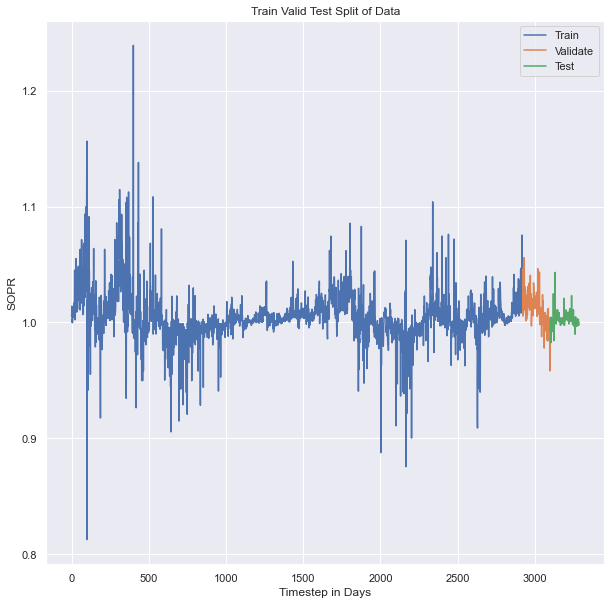

In [19]:
# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 10]

# Create a plot showing the split of the train, valid, and test data
plt.plot(x_train, label = 'Train')
plt.plot(x_valid, label = 'Validate')
plt.plot(x_test, label = 'Test')
plt.title('Train Valid Test Split of Data')
plt.ylabel('SOPR')
plt.xlabel('Timestep in Days')
plt.legend()
#print(x_train.index.max(),x_valid.index.min(),x_valid.index.max(),x_test.index.min(),x_test.index.max())
print("Train set ranging from 2010-01-01 to", SOPR.iloc[2922]["Timestamp"], "- Number of days =", len(x_train.index))
print("Validation set ranging from", SOPR.iloc[x_valid.index.min()]["Timestamp"], "to", SOPR.iloc[x_valid.index.max()]["Timestamp"], "- Number of days =", len(x_valid.index))
print("Test set ranging from", SOPR.iloc[x_test.index.min()]["Timestamp"], "to", SOPR.iloc[x_test.index.max()]["Timestamp"], "- Number of days =", len(x_test.index))

In [20]:
len(x_train.index)

2920

In [21]:
len(x_test.index)

185

In [22]:
# Lets create a dictionary to store all of our model training scores to view later
model_mae_scores = {}

# Base Model - Naive Forecasting

A naive forecast is naive because it takes the price from the day before and uses that price for the prediction of tomorrow. This is suprisingly effecting in this scenario due to the relatively due to autocorrelation. The price of tomorrow is dependent on the price today. Tomorrow's market open price is very close to the price of today's close.


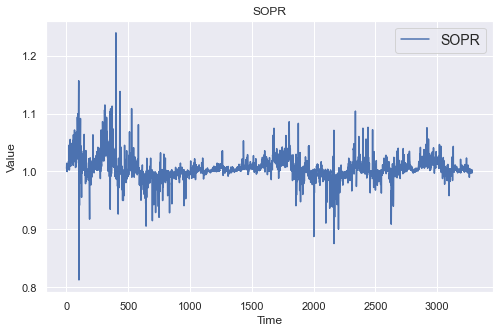

In [23]:
# Plot chart with all details untouched
def plot_series(time, series, format="-", start=0, end=None, label=None):
    """[Plot the series data over a time range]
    Args:
        time (data range): [The entire time span of the data in range format]
        series ([integers]): [Series value corresponding to its point on the time axis]
        format (str, optional): [Graph type]. Defaults to "-".
        start (int, optional): [Time to start time series data]. Defaults to 0.
        end ([type], optional): [Where to stop time data]. Defaults to None.
        label ([str], optional): [Label name of series]. Defaults to None.
    """
    plt.figure(figsize=(8, 5))
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title(label)
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
plot_series(time=SOPR.index,series=SOPR['Value'], label = 'SOPR')

In [24]:
naive_forecast = series[test_split_index-1 :-1]

Text(0.5, 1.0, 'SOPR Forecast vs Actual')

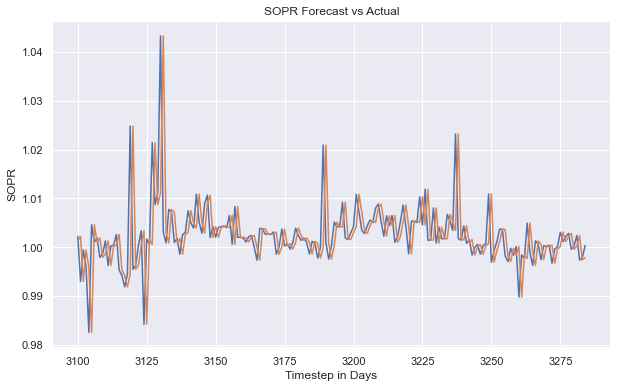

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(x_test.index, x_test, label="Actual")
plt.plot(x_test.index, naive_forecast, label="Forecast")
plt.ylabel('SOPR')
plt.xlabel('Timestep in Days')
plt.title('SOPR Forecast vs Actual')

## Calculate Error in Naive Model

In [26]:
# Alternative way to show MAE to stay consistent with what we will be doing later
naive_forecast_mae = mean_absolute_error(x_test, naive_forecast)
model_mae_scores['naive'] = naive_forecast_mae

# view the dictionary of mae scores
model_mae_scores

{'naive': 0.004408076902271792}

In [27]:
# Show first 3 values of our forecast
print(naive_forecast.values[:3])

# Show first 3 values of validation data
print(x_test.values[:3])

# Calculate and show first 3 values of the calculated error (MAE)
print('*'*100)
print(np.abs(naive_forecast[:3].values - x_test[:3].values))

[1.00129631 1.0022583  0.99303788]
[1.0022583  0.99303788 0.99947217]
****************************************************************************************************
[0.00096199 0.00922042 0.00643429]


ADESSO VADO A CREARE 2 MODELLI: 20 DAY E 5 DAY MOVING AVERAGE. MOTIVO SARA' ANCHE SPIEGATO NELLE CELLE SEGUENTI, TUTTAVIA FACCIO UNA PRECISAZIONE
- IL MODELLO 5MA SERVE A MODELLARE I 5 GIORNI DELLA SETTIMANA, IN QUANTO LA BORSA E' APERTA DA LUNEDI' A VENERDI', MENTRE GLI ALTRI GIORNI CHIUDE. 
- IL MODELLO 20MA E' COME IL PRECEDENTE, PERO' MENSILE, QUINDI MODELLA I 20 GIORNI IN CUI LA BORSA E' APERTA IN UN MESE.

TUTTO QUESTO NON VALE PER BITCOIN E CRYPTO, IN QUANTO E' SEMPRE POSSIBILE TRADARLI, OGNI ISTANTE.
IN OGNI CASO CI STA FARE QUESTA ANALISI, IN QUANTO MAGARI LA BORSA POTREBBE INFLUENZARE ANCHE LE CRYPTO

# Monthly Moving Average Model (20 Day MA)

Moving Averages are not true prediction models, however it is an important topic to demonstrate. When you hear someone talk about how they want to "de-trend" or "smooth" data they are usually talking about implementing some sort of moving average. There are multiple moving average types with the most common being simple and exponential. Simple is just the average price over the desired time span. Exponential is a little more complicated as it provides a weight factor to each time step in the window. The weights are applied to make the more recent time steps more important that the later time steps. This allows the moving average to respond much more quickly to abrupt changes.

Text(0.5, 1.0, 'SMA20 vs Actual')

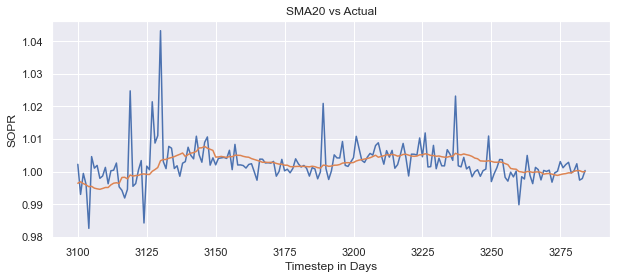

In [28]:
# Choose a window size for the moving average
window = 20

# Create a moving average over the entire dataset
moving_avg = SOPR['Value'].rolling(window=window).mean()

# Slice the moving average on the forecast
moving_avg_forecast = moving_avg.values[test_split_index:]
                                         
plt.figure(figsize=(10, 4))
plt.plot(x_test.index, x_test)
plt.plot(x_test.index, moving_avg_forecast)
plt.ylabel('SOPR')
plt.xlabel('Timestep in Days')
plt.title('SMA20 vs Actual')


In [29]:
ma_20 = mean_absolute_error(x_test, moving_avg_forecast)

model_mae_scores['SMA 20'] = ma_20
model_mae_scores

{'naive': 0.004408076902271792, 'SMA 20': 0.0033655691445564316}

# Weekly Moving Average (5 day MA)

I have modeled a 20 day moving average and a 5 day moving average. This is because there are only 5 trading days a week which means 20 trading in a month. So these two moving averages show the weekly trend and the monthly trends of the S&P500. These moving averages are typically used to generate trading signals. For example, if the 5 SMA overtakes the 20 SMA that means the price is in a recent up trend and you may want to play that momentum going forward.

Text(0.5, 1.0, 'SMA5 Forecast vs Actual')

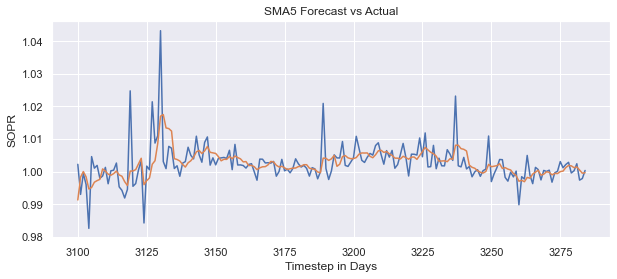

In [30]:
# Choose a window size for the moving average
window = 5

# Create a moving average over the entire dataset
moving_avg = SOPR['Value'].rolling(window=window).mean()

# Slice the moving average on the forecast
moving_avg_forecast = moving_avg.values[test_split_index: ]
                                         
plt.figure(figsize=(10, 4))
plt.plot(x_test.index, x_test)
plt.plot(x_test.index, moving_avg_forecast)
plt.ylabel('SOPR')
plt.xlabel('Timestep in Days')
plt.title('SMA5 Forecast vs Actual')

In [31]:
# Calculate MAE
ma_5 = mean_absolute_error(x_test, moving_avg_forecast)

# Save to our dictionary of model mae scores
model_mae_scores['SMA 5'] = ma_5
model_mae_scores

{'naive': 0.004408076902271792,
 'SMA 20': 0.0033655691445564316,
 'SMA 5': 0.0030284014458080324}

# ARIMA

Step 1: Is the data stationary?
Use Augmented Dickey Fuller test to determine if the data is stationary

- Failure to reject the null hypothesis means the data is not stationary

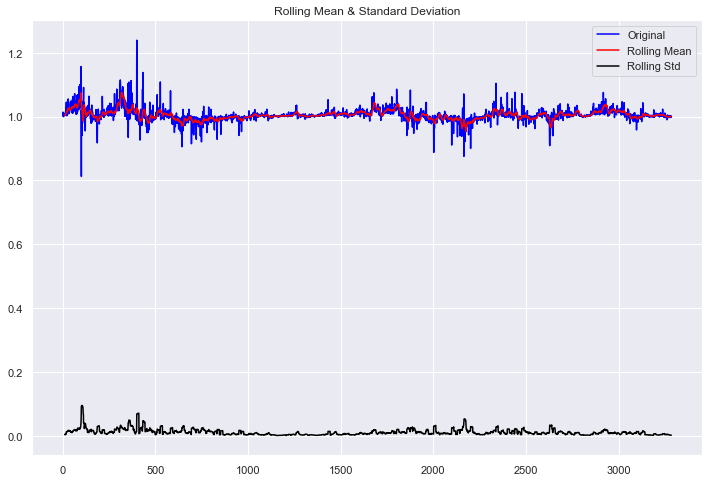

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                   -5.610556
p-value                           0.000001
#Lags Used                       16.000000
Number of Observations Used    3268.000000
Critical Value (1%)              -3.432353
Critical Value (5%)              -2.862425
Critical Value (10%)             -2.567241
dtype: float64


In [32]:
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)
    
test_stationarity(series)


The p-value is obtained is lower than significance level of 0.05 and the ADF statistic is higher than any of the critical values.

However, it seems, graphically, that the series is not stationary. 

# Step 2 Differencing

We must convert our non-stationary data to stationary data using the differencing method. This means we take the value at time (t) and subtract the value at time (t-1) to get the difference. This difference is also the calculated return over that period. Since our time steps are in days this differencing is the daily return.

In [33]:
# Get the difference of each Adj Close point
SOPR_diff_1 = series.diff()
SOPR_diff_1.dropna(inplace=True)

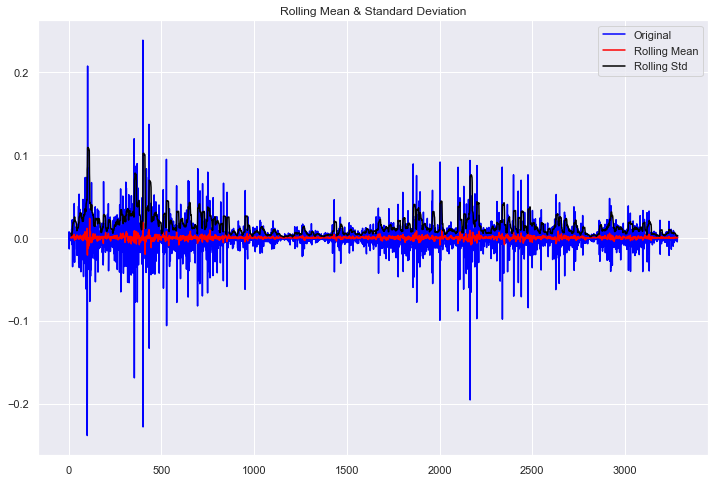

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                  -23.013929
p-value                           0.000000
#Lags Used                       15.000000
Number of Observations Used    3268.000000
Critical Value (1%)              -3.432353
Critical Value (5%)              -2.862425
Critical Value (10%)             -2.567241
dtype: float64


In [34]:
# Plot the tsla Adj Close 1st order difference
test_stationarity(SOPR_diff_1)

# Step 3: Autocorrelation and Partial autocorrelation
Autocorrelation and partial autocorrelation plots are heavily used in time series analysis and forecasting.

These are plots that graphically summarize the strength of a relationship with an observation in a time series with observations at prior time steps. The difference between autocorrelation and partial autocorrelation can be difficult and confusing for beginners to time series forecasting.

Autocorrelation is the correlation between points at time t (Pₜ) and the point at(Pₜ₋₁). Partial autocorrelation is the point at time t (Pₜ) and the point (Pₜ₋ₖ) where k is any number of lags. Partial autocorrelation ignores all of the data in between both points.

In terms of a movie theater’s ticket sales, autocorrelation determines the relationship of today’s ticket sales and yesterday’s ticket sales. In comparison, partial autocorrelation defines the relationship of this Friday’s ticket sales and last Friday’s ticket sales.

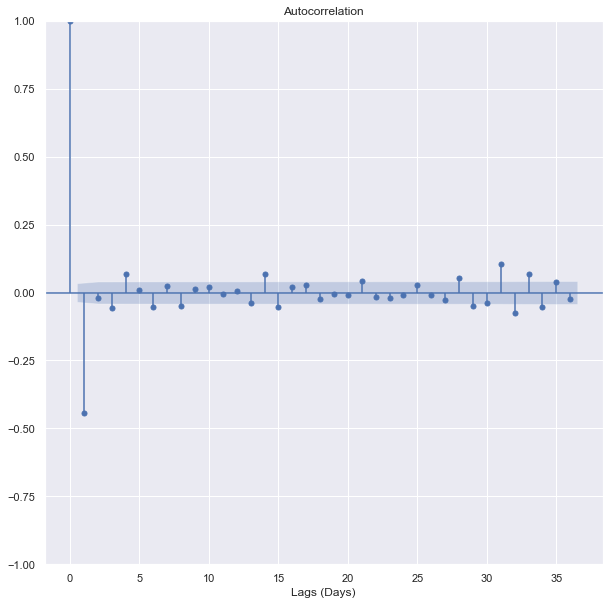

In [35]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(SOPR_diff_1)
plt.xlabel('Lags (Days)')
plt.show()

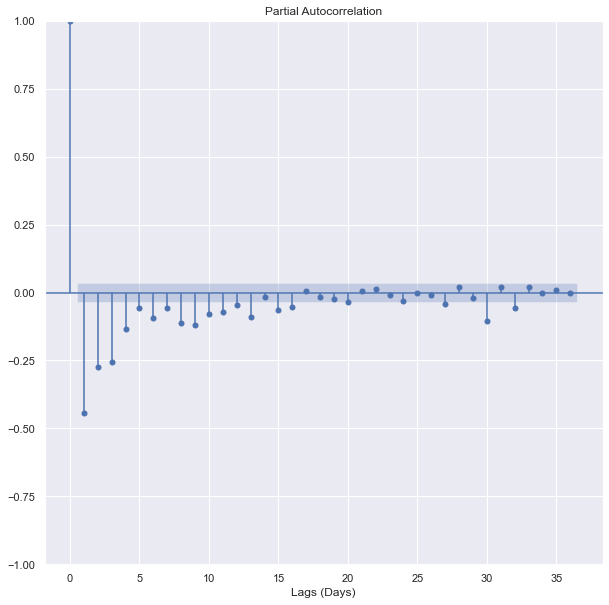

In [36]:
plot_pacf(SOPR_diff_1, method='ywm')
plt.xlabel('Lags (Days)')
plt.show()

- Let’s start with the Autocorrelation plot. The important detail of these plots is the first lag. If the first lag is positive, we use an autoregressive (AR) model, and if the first lag is negative, we use a moving average (MA) plot. Since the first lag is negative, we will use the 1st lag as a moving average point.

- For the PACF plot, at lag one, which is negatively correlated, we will use an AR factor of 1 as well. If you have trouble determining how what lags are the best to use, feel free to experiment, and watch the AIC. The lower the AIC, the better.

- The ARIMA model takes three main inputs into the “order” argument. Those arguments are ‘p’ for the AR term, ‘d’ for the differencing term, ‘q’ for the MA term.

SINCE THE DIFF SERIES IS THE ONLY STATIONARY ONE WE USE IT TO BUILD AND TRAIN THE MODELS. WE WILL RECONSTRUCT THE ORIGINAL SERIES REVERSEING THE DIFFERENCIATION.

We now split the diff series in train, test and validation

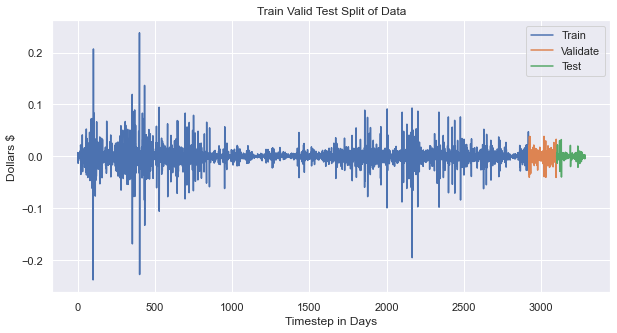

In [37]:
# Create train data set

x_train_diff = SOPR_diff_1.loc[SOPR['Timestamp'] <= train_split_date]

# Create test data set
x_test_diff = SOPR_diff_1.loc[SOPR['Timestamp'] >= test_split_date]

# Create valid data set
valid_split_index = (train_split_index.max(),test_split_index.min())
x_valid_diff = SOPR_diff_1.loc[(SOPR['Timestamp'] < test_split_date) & 
                           (SOPR['Timestamp'] > train_split_date)]

# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 5]

# Create a plot showing the split of the train, valid, and test data
plt.plot(x_train_diff, label = 'Train')
plt.plot(x_valid_diff, label = 'Validate')
plt.plot(x_test_diff, label = 'Test')
plt.title('Train Valid Test Split of Data')
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.legend()

### Testing different arima models

------------- Auto SARIMA --------------- 

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=-15683.747, Time=4.40 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-14420.425, Time=0.22 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-15054.866, Time=1.38 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-15653.955, Time=2.04 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=-14422.424, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=-15682.153, Time=1.80 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=-15681.758, Time=4.71 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=-15674.691, Time=8.96 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=-15684.189, Time=3.43 sec
 ARIMA(1,1,1)(2,0,0)[7] intercept   : AIC=-15690.021, Time=7.71 sec
 ARIMA(1,1,1)(2,0,1)[7] intercept   : AIC=-15651.826, Time=7.99 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=-15659.065, Time=7.56 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=-15060.568, Time=3.36 sec
 ARIMA(2,1,1)(2,0,0)[7] inter

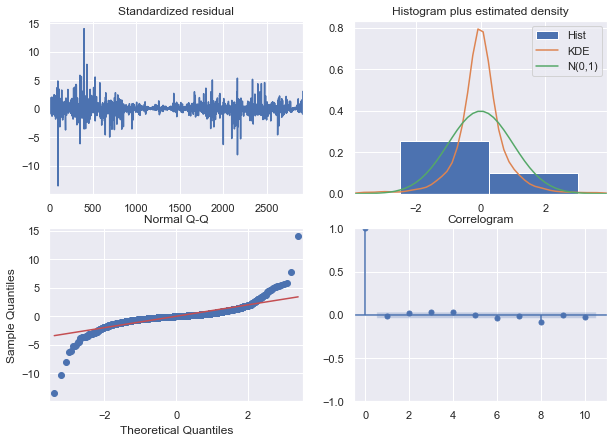

In [38]:
def model_auto_sarimax(y, seasonality, seasonal_flag, exogenous_variable):
    
    # Train model
    model = pm.auto_arima(x_train, exogenous=exogenous_variable, 
                          start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = input_seasonality, 
                          start_P = 0, seasonal = seasonal_flag, 
                          d = None, max_D = 1, trace = True, 
                          error_action ='ignore',   
                          suppress_warnings = True,  stepwise = True, 
                          max_order=12)
    
    # Model summary 
    print(model.summary())
    
    # Model diagnostics
    model.plot_diagnostics(figsize=(10,7))
    plt.show()
    
    return model

def model_manual_sarima(y, order, seasonal_order):
    
    # Train model
    model = SARIMAX(y, order = order, seasonal_order = seasonal_order).fit()
    
    # Model summary 
    print(model.summary())
    
    # Model diagnostics
    model.plot_diagnostics(figsize=(10,7))
    plt.show()
    
    return model

def model_simple_exponential_smoothing(y):
    
    # Train model
    model = SimpleExpSmoothing(np.asarray(y)).fit(smoothing_level=0.6,optimized=False)
    
    # Model summary 
    print(model.summary())
    
    return model

    
# Forecasting algorithm
input_ts_algo = 'auto_sarima' # choose the forecasting algorithm from 'auto_arima', 'auto_sarima', 'auto_sarimax', 'manual_sarima', 'simple_exponential_smoothing' and 'holt_winters'


input_seasonality = 7


from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
# Get actual values
actuals = x_test.reset_index(drop = True)

# Select the algorithm according to the input provided
if input_ts_algo == 'auto_arima':
    
    print("------------- Auto ARIMA --------------- \n")
    model = model_auto_sarimax(y = x_train, seasonality = input_seasonality, seasonal_flag = False, exogenous_variable = None)
    
elif input_ts_algo == 'auto_sarima':
    
    print("------------- Auto SARIMA --------------- \n")
    model = model_auto_sarimax(y = x_train, seasonality = input_seasonality, seasonal_flag = True, exogenous_variable = None)
    
elif input_ts_algo == 'auto_sarimax':
    
    print("------------- Auto SARIMAX --------------- \n")
    model = model_auto_sarimax(y = x_train, seasonality = input_seasonality, seasonal_flag = False, exogenous_variable = train[input_exogenous_variable].values.reshape(-1, 1))

elif input_ts_algo == 'manual_sarima':
    input_order = (3,1,0)
    input_seasonal_order = (2,1,1,7)
    print("------------- Manual SARIMA --------------- \n")
    model = model_manual_sarima(y = x_train, order = input_order, seasonal_order = input_seasonal_order)

elif input_ts_algo == 'simple_exponential_smoothing':
    
    print("------------- Simple Exponential Smoothing --------------- \n")
    model = model_simple_exponential_smoothing(y = x_train)


Abbiamo trovato che il miglior modello è ARIMA(3,2,0)(0,0,1)[7]

In [39]:
import statsmodels.api as sm

# fit model
SOPR_arima = sm.tsa.arima.ARIMA(x_train, order=(3,1,1), seasonal_order=(0,0,2,7))
SOPR_arima_fit = SOPR_arima.fit()
print(SOPR_arima_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                Value   No. Observations:                 2920
Model:             ARIMA(3, 1, 1)x(0, 0, [1, 2], 7)   Log Likelihood                7855.888
Date:                              Fri, 11 Nov 2022   AIC                         -15697.777
Time:                                      12:38:35   BIC                         -15655.924
Sample:                                           0   HQIC                        -15682.701
                                             - 2920                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1755      0.010     17.115      0.000       0.155       0.196
ar.L2          0.06

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


NormaltestResult(statistic=6875.5291173294, pvalue=0.0)
This distribution is not a normal distribution


/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


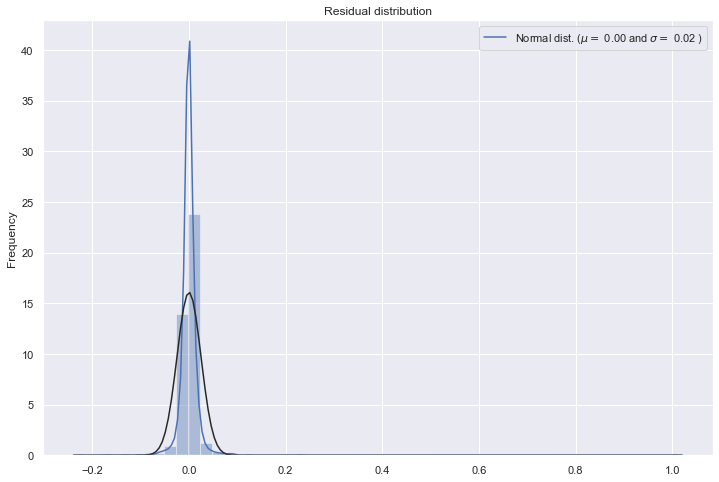

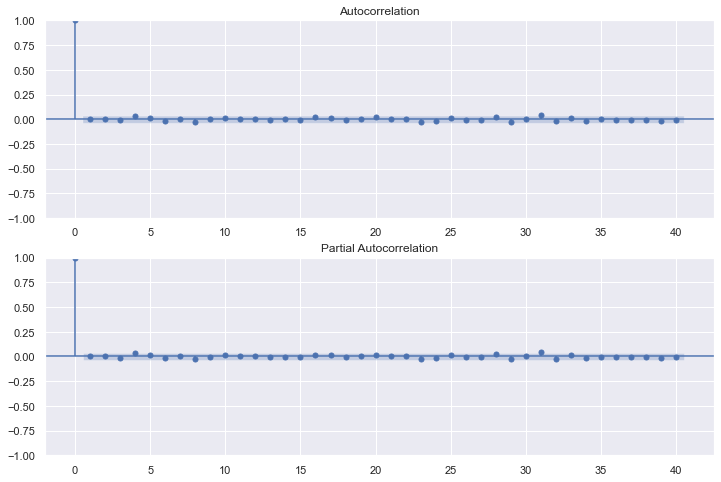

In [40]:
from scipy import stats
import statsmodels.api as sm
from scipy.stats import normaltest

residuals = SOPR_arima_fit.resid
print(normaltest(residuals))
if normaltest(residuals)[1] < .05:
    print('This distribution is not a normal distribution')
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(residuals ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(residuals)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residuals, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residuals, lags=40, ax=ax2)

# Step 4: Building the Arima Model and Forecasting
Now that we have experimented and found our prefered model order of (3,1,3)(0,0,0,7) lets build the model and get some forecasts.

This cell takes a while to run. Be careful. We have stored the model predictions using a magic method so we do not have to re-run this time consuming cell everytime.

Ci mette parecchio a calcolare questa cella giù. Se si vuole risparmiare tempo allora bisogna abbassare il numero di data points da predire

### Primo tipo di ARIMA: training ricorsivo true: train, predico 1 giorno, appendo la predizione, re-traino e così via

In [41]:
# Create list of x train valuess
history = [x for x in x_train]

# establish list for predictions
model_predictions = []

# Count number of test data points
N_test_observations = len(x_test)

#in questo modo prendo oggi, prevedo domani, appendo la previsione al trainset, retraino, predico ancora. 
#Questo è recursive learning, o autoregressive learning
# loop through every data point
for time_point in list(x_test.index[-N_test_observations:]):
    model = sm.tsa.arima.ARIMA(history, order=(3,1,1), seasonal_order=(0,0,2,7))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = x_test[time_point]
    #history.append(true_test_value)
    history.append(yhat)
    
MAE_error = mean_absolute_error(x_test, model_predictions)
print('Testing Mean Squared Error is {}'.format(MAE_error))

%store model_predictions

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimiz

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimiz

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimiz

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimiz

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimiz

Testing Mean Squared Error is 0.028628473741541063
Stored 'model_predictions' (list)


In [42]:
output

array([1.03099943])

In [43]:
# %store model_predictions
%store -r model_predictions

# Check to see if it reloaded
model_predictions[:5]

[1.0317121925554233,
 1.0386598651517926,
 1.0332686435135863,
 1.031660736843415,
 1.0291250520743487]

In [44]:
model_predictions

[1.0317121925554233,
 1.0386598651517926,
 1.0332686435135863,
 1.031660736843415,
 1.0291250520743487,
 1.0309922186874012,
 1.0316459998068277,
 1.0307444038571427,
 1.029377337194661,
 1.0304009288783165,
 1.0310876379632112,
 1.0334608713298514,
 1.032494544483777,
 1.0306117743941479,
 1.0309428659911422,
 1.03154904255528,
 1.0308170490579174,
 1.0309268223483556,
 1.0310213913113044,
 1.0309915095469508,
 1.0309182087080964,
 1.0310511578541144,
 1.0310781387900243,
 1.0311084372026675,
 1.0310071611929277,
 1.0311049371077439,
 1.030992852578869,
 1.0309692309616691,
 1.0309545181777333,
 1.0310461979980239,
 1.0309586767731742,
 1.0309586051819382,
 1.0310121483175378,
 1.030992363688374,
 1.0310115143149554,
 1.0310209820387204,
 1.0309927979804419,
 1.030998908407157,
 1.030979021271805,
 1.0310117242420713,
 1.0309845357484697,
 1.0310025114381038,
 1.0309837987474457,
 1.0309847855142167,
 1.0309849165734102,
 1.0309988569770223,
 1.0310024177124206,
 1.031000912387577,
 1

In [45]:
model_predictions = np.array(model_predictions).flatten()

# Calculate MAE
arima_mae = mean_absolute_error(x_test, model_predictions)

# Save to our dictionary of model mae scores
model_mae_scores['ARIMA_recursive_true'] = arima_mae
model_mae_scores

{'naive': 0.004408076902271792,
 'SMA 20': 0.0033655691445564316,
 'SMA 5': 0.0030284014458080324,
 'ARIMA_recursive_true': 0.028628473741541063}

- You may want to zoom in on the plot below to get a better view of the differences. To do this simply use the [:] slicing on x_test.index and model_predictions/x_test in the plt.plot() lines. I typically like to do [-100:] to get the last 100 values

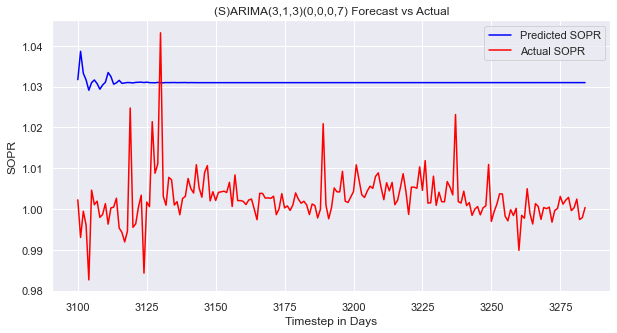

<Figure size 720x432 with 0 Axes>

In [46]:
# Plot our predictions against the actual values for a visual comparison.
plt.plot(x_test.index[-N_test_observations:], model_predictions[-N_test_observations:], color='blue',label='Predicted SOPR')
plt.plot(x_test.index[-N_test_observations:], x_test[-N_test_observations:], color='red', label='Actual SOPR')
plt.ylabel('SOPR')
plt.xlabel('Timestep in Days')
plt.title('(S)ARIMA(3,1,3)(0,0,0,7) Forecast vs Actual')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

In [47]:
# Find the Error in the ARIMA Model
arima_error = model_predictions - x_test

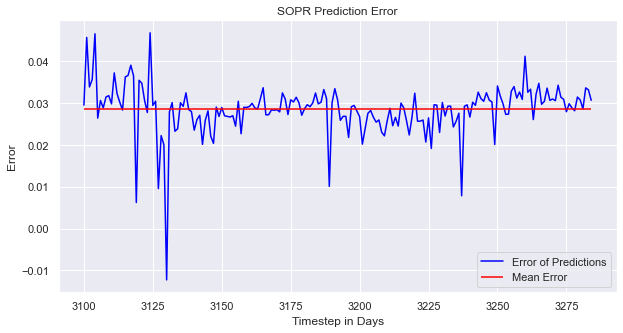

<Figure size 720x432 with 0 Axes>

In [48]:
plt.plot(x_test.index, arima_error, color='blue',label='Error of Predictions')
plt.hlines(np.mean(arima_error),xmin=x_test.index.min(),xmax=x_test.index.max(), color = 'red', label = 'Mean Error')
# plt.plot(x_valid.index, x_valid, color='red', label='Actual Price')
plt.title('SOPR Prediction Error')
plt.xlabel('Timestep in Days')
plt.ylabel('Error')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

In [49]:
mae_series = pd.Series(model_mae_scores)
model_mae_scores

{'naive': 0.004408076902271792,
 'SMA 20': 0.0033655691445564316,
 'SMA 5': 0.0030284014458080324,
 'ARIMA_recursive_true': 0.028628473741541063}

### Secondo tipo di ARIMA: training ricorsivo fake: train, predico, aggiungo al trainset il primo valore VERO del test set e ricomincio (quindi sarebbe una predizione di un giorno, visto che appendo il valore vero del test set)

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimiz

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimiz

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimiz

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimiz

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimiz

Testing Mean Squared Error is 0.004259015438665774
Stored 'model_predictions' (list)


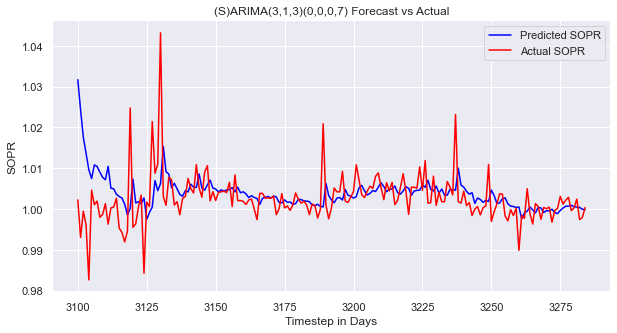

<Figure size 720x432 with 0 Axes>

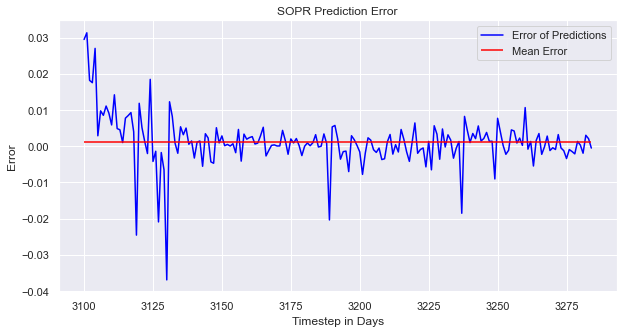

<Figure size 720x432 with 0 Axes>

{'naive': 0.004408076902271792,
 'SMA 20': 0.0033655691445564316,
 'SMA 5': 0.0030284014458080324,
 'ARIMA_recursive_true': 0.028628473741541063,
 'ARIMA_recursive_fake': 0.004259015438665774}

In [50]:
# Create list of x train valuess
history = [x for x in x_train]

# establish list for predictions
model_predictions = []

# Count number of test data points
N_test_observations = len(x_test)

#Invece qui sotto faccio training e finisco. 
#Poi predico domani, metto in input la predizione e predico dopodomani, accumulando l'errore.
#Spiegata in matematichese per bene qui, su iterative forecasting:
#https://thuijskens.github.io/2016/08/03/time-series-forecasting/
# loop through every data point

for time_point in list(x_test.index[-N_test_observations:]):
    model = sm.tsa.arima.ARIMA(history, order=(3,1,1), seasonal_order=(0,0,2,7))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = x_test[time_point]
    history.append(true_test_value)
    #history.append(yhat)
    
MAE_error = mean_absolute_error(x_test, model_predictions)
print('Testing Mean Squared Error is {}'.format(MAE_error))

%store model_predictions

# %store model_predictions
%store -r model_predictions

# Check to see if it reloaded
model_predictions[:5]

model_predictions = np.array(model_predictions).flatten()

# Calculate MAE
arima_mae = mean_absolute_error(x_test, model_predictions)

# Save to our dictionary of model mae scores
model_mae_scores['ARIMA_recursive_fake'] = arima_mae
model_mae_scores

# Plot our predictions against the actual values for a visual comparison.
plt.plot(x_test.index[-N_test_observations:], model_predictions[-N_test_observations:], color='blue',label='Predicted SOPR')
plt.plot(x_test.index[-N_test_observations:], x_test[-N_test_observations:], color='red', label='Actual SOPR')
plt.ylabel('SOPR')
plt.xlabel('Timestep in Days')
plt.title('(S)ARIMA(3,1,3)(0,0,0,7) Forecast vs Actual')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

# Find the Error in the ARIMA Model
arima_error = model_predictions - x_test

plt.plot(x_test.index, arima_error, color='blue',label='Error of Predictions')
plt.hlines(np.mean(arima_error),xmin=x_test.index.min(),xmax=x_test.index.max(), color = 'red', label = 'Mean Error')
# plt.plot(x_valid.index, x_valid, color='red', label='Actual Price')
plt.title('SOPR Prediction Error')
plt.xlabel('Timestep in Days')
plt.ylabel('Error')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

mae_series = pd.Series(model_mae_scores)
model_mae_scores

### Terzo tipo di ARIMA: predizione con forecast(185)

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing Mean Squared Error is 0.027194289393659907
Stored 'model_predictions' (ndarray)


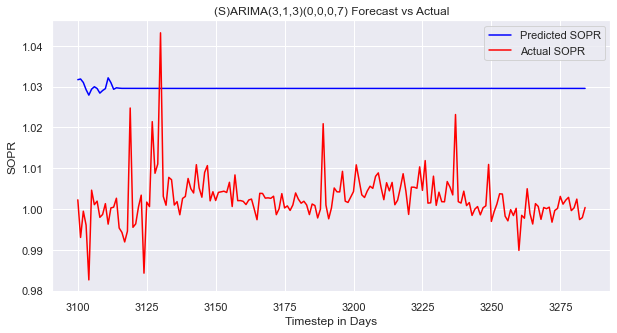

<Figure size 720x432 with 0 Axes>

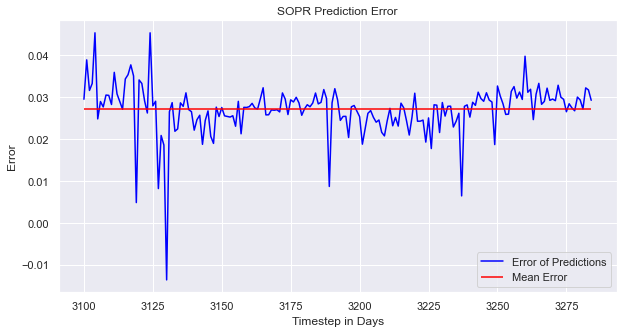

<Figure size 720x432 with 0 Axes>

{'naive': 0.004408076902271792,
 'SMA 20': 0.0033655691445564316,
 'SMA 5': 0.0030284014458080324,
 'ARIMA_recursive_true': 0.028628473741541063,
 'ARIMA_recursive_fake': 0.004259015438665774,
 'ARIMA_forecast': 0.027194289393659907}

In [51]:
# Create list of x train valuess
history = [x for x in x_train]

# establish list for predictions
model_predictions = []

# Count number of test data points
N_test_observations = len(x_test)

#Invece qui sotto faccio training e finisco. 
#Poi predico domani, metto in input la predizione e predico dopodomani, accumulando l'errore.
#Spiegata in matematichese per bene qui, su iterative forecasting:
#https://thuijskens.github.io/2016/08/03/time-series-forecasting/
# loop through every data point
model = sm.tsa.arima.ARIMA(history, order=(3,1,1), seasonal_order=(0,0,2,7))
model_fit = model.fit()
output = model_fit.forecast(len(x_test))
#yhat = output[0]
model_predictions = output
#true_test_value = x_test[time_point]
#history.append(true_test_value)
#history.append(yhat)
    
MAE_error = mean_absolute_error(x_test, model_predictions)
print('Testing Mean Squared Error is {}'.format(MAE_error))

%store model_predictions

# %store model_predictions
%store -r model_predictions

# Check to see if it reloaded
model_predictions[:5]

model_predictions = np.array(model_predictions).flatten()

# Calculate MAE
arima_mae = mean_absolute_error(x_test, model_predictions)

# Save to our dictionary of model mae scores
model_mae_scores['ARIMA_forecast'] = arima_mae
model_mae_scores

# Plot our predictions against the actual values for a visual comparison.
plt.plot(x_test.index[-N_test_observations:], model_predictions[-N_test_observations:], color='blue',label='Predicted SOPR')
plt.plot(x_test.index[-N_test_observations:], x_test[-N_test_observations:], color='red', label='Actual SOPR')
plt.ylabel('SOPR')
plt.xlabel('Timestep in Days')
plt.title('(S)ARIMA(3,1,3)(0,0,0,7) Forecast vs Actual')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

# Find the Error in the ARIMA Model
arima_error = model_predictions - x_test

plt.plot(x_test.index, arima_error, color='blue',label='Error of Predictions')
plt.hlines(np.mean(arima_error),xmin=x_test.index.min(),xmax=x_test.index.max(), color = 'red', label = 'Mean Error')
# plt.plot(x_valid.index, x_valid, color='red', label='Actual Price')
plt.title('SOPR Prediction Error')
plt.xlabel('Timestep in Days')
plt.ylabel('Error')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

mae_series = pd.Series(model_mae_scores)
model_mae_scores

Text(0.5, 1.0, 'Daily Data - Mean Average Error of All Models Tested')

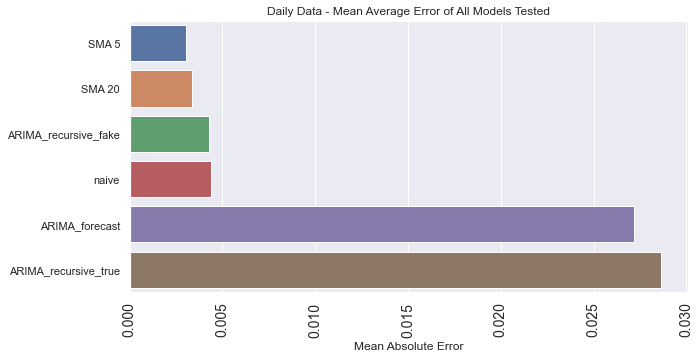

In [52]:
# Sort vales for clean bar chart
order = mae_series.sort_values()

# Create bar chart for to show MAE of all models side by side
sns.barplot(x=order.values, y = order.index, orient='h')
plt.xlabel('Mean Absolute Error')
plt.xticks(rotation='vertical',fontsize=14)
plt.title('Daily Data - Mean Average Error of All Models Tested')

# LSTM

- LSTM stands for Long Short Term Memory
The LSTM cell contains an RNN cell inside (dense layer with a tanh activation function), but it has other attributes that allow it to remember patterns over a longer period of time. The LSTM contains a short-term state vector that is used from one time step to the next identical to the RNN cell.

Where LSTM cells differ is their Long-Term State vector. This long term state vector undergoes a multipicative and additive operation at each time step.The long term state vector starts off with a "forget gate" which is simply a sigmoid activation on top of a dense layer which produces an output from 0 - 1. This means if the forget gate ourputs a value of 1 then the long term state vector remains unchanged. On the opposite end, if the output valuse of the dense layer is 0 the long term state vector is nullified. This helps adjust quickly to highly volatile environments. If we are in a steady uptrend and then we suddenly have a big drop in the market, the long term state vector will be erased so the model can readjust quickly.

The next gate is the input gate. The input gate is much like the forget gate, except it decides if the short term state vector gets added to the long term vector or is erased.

The last gate called the "output gate" decides what the next hidden state should be. It is important to know that this hidden state output is the prediction for the next time step. Here, the previous hidden state (previous cell output) amd current input are jammed together through sigmoid function. Then we take our newly modified long term state vector which has already passed through the forget and input gates, and apply a tanh function to it. Finally, multiple both the tanh output (long term state vector output) and the sigmoid function output (previous hidden state and new input at this time step) to what information the hidden state needs to carry to the next time step.

</br> To review, the Forget gate decides what is relevant to keep from prior steps. The input gate decides what information is relevant to add from the current step. The output gate determines what the next hidden state should be.

In [53]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

keras = tf.keras

# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 10]

def sequential_window_dataset(series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

In [54]:
x_train

0       1.005351
1       1.006994
2       1.014041
3       1.000494
4       1.002167
          ...   
2915    1.018940
2916    1.028140
2917    1.075420
2918    1.053047
2919    1.024616
Name: Value, Length: 2920, dtype: float64

In [55]:
x_train.shape

(2920,)

In [56]:
# Reshape values
x_train_values = x_train.values.reshape(-1, 1)
x_valid_values = x_valid.values.reshape(-1, 1)
x_test_values = x_test.values.reshape(-1, 1)

#  Create Scaler Object
x_train_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit x_train values
normalized_x_train = x_train_scaler.fit_transform(x_train_values)

# Fit x_valid values
normalized_x_valid = x_train_scaler.transform(x_valid_values)

# Fit x_test values
normalized_x_test = x_train_scaler.transform(x_test_values)

# All values normalized to training data
spy_normalized_to_traindata = x_train_scaler.transform(series.values.reshape(-1, 1))

# Example of how to iverse
# inversed = scaler.inverse_transform(normalized_x_train).flatten()

In [57]:
x_train_values

array([[1.0053508 ],
       [1.00699398],
       [1.01404075],
       ...,
       [1.07542024],
       [1.0530466 ],
       [1.0246159 ]])

In [58]:
x_train_values.shape

(2920, 1)

In [59]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

### Find the learning rate

Spiegazione su come funziona: https://blog.dataiku.com/the-learning-rate-finder-technique-how-reliable-is-it

In [60]:
# reset any stored data
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Set window size and create input batch sequences
window_size = 20
train_set = sequential_window_dataset(normalized_x_train, window_size)

# create model
model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
])

# create lr
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))
reset_states = ResetStatesCallback()

# choose optimizer
optimizer = keras.optimizers.Nadam(lr=1e-5)

# compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# set history
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/100


/usr/local/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/nadam.py:86: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


145/145 [==============================] - 9s 18ms/step - loss: 0.0700 - mae: 0.3679 - lr: 1.0000e-05
Epoch 2/100
145/145 [==============================] - 2s 15ms/step - loss: 0.0177 - mae: 0.1678 - lr: 1.1220e-05
Epoch 3/100
145/145 [==============================] - 3s 18ms/step - loss: 0.0013 - mae: 0.0269 - lr: 1.2589e-05
Epoch 4/100
145/145 [==============================] - 2s 14ms/step - loss: 0.0011 - mae: 0.0251 - lr: 1.4125e-05
Epoch 5/100
145/145 [==============================] - 2s 14ms/step - loss: 0.0011 - mae: 0.0252 - lr: 1.5849e-05
Epoch 6/100
145/145 [==============================] - 2s 15ms/step - loss: 0.0011 - mae: 0.0252 - lr: 1.7783e-05
Epoch 7/100
145/145 [==============================] - 2s 17ms/step - loss: 0.0011 - mae: 0.0253 - lr: 1.9953e-05
Epoch 8/100
145/145 [==============================] - 2s 15ms/step - loss: 0.0011 - mae: 0.0253 - lr: 2.2387e-05
Epoch 9/100
145/145 [==============================] - 2s 14ms/step - loss: 0.0011 - mae: 0.0253 - l

Epoch 72/100
145/145 [==============================] - 2s 14ms/step - loss: 0.0011 - mae: 0.0288 - lr: 0.0355
Epoch 73/100
145/145 [==============================] - 2s 13ms/step - loss: 0.0011 - mae: 0.0287 - lr: 0.0398
Epoch 74/100
145/145 [==============================] - 2s 14ms/step - loss: 0.0011 - mae: 0.0285 - lr: 0.0447
Epoch 75/100
145/145 [==============================] - 2s 13ms/step - loss: 0.0011 - mae: 0.0283 - lr: 0.0501
Epoch 76/100
145/145 [==============================] - 2s 13ms/step - loss: 0.0010 - mae: 0.0280 - lr: 0.0562
Epoch 77/100
145/145 [==============================] - 2s 13ms/step - loss: 0.0010 - mae: 0.0277 - lr: 0.0631
Epoch 78/100
145/145 [==============================] - 2s 13ms/step - loss: 0.0010 - mae: 0.0274 - lr: 0.0708
Epoch 79/100
145/145 [==============================] - 2s 14ms/step - loss: 0.0010 - mae: 0.0272 - lr: 0.0794
Epoch 80/100
145/145 [==============================] - 2s 15ms/step - loss: 0.0010 - mae: 0.0271 - lr: 0.0891
E

(1e-05, 0.1, 0.0, 0.03)

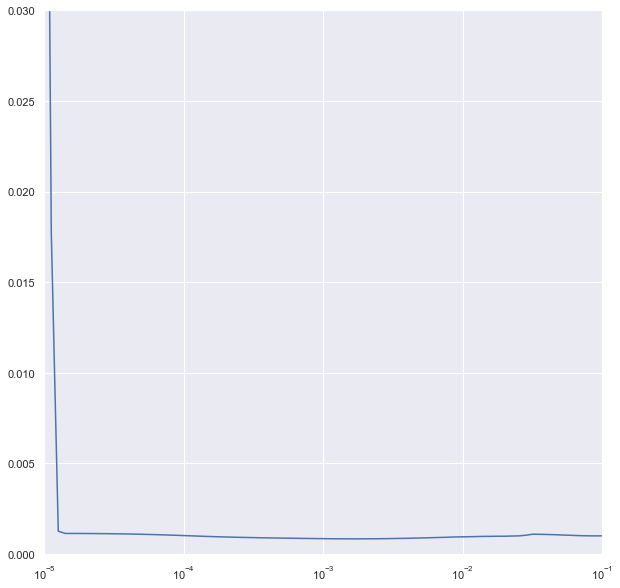

In [61]:
# Plot the learning rate chart
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-5, 1e-1, 0, 0.03])

In [62]:
#This is the best learning rate
my_lr = history.history["lr"][history.history["loss"].index(min(history.history["loss"]))]
#Arrotondo a 0.00033

In [63]:
# reset any stored data
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# set window size and create input batch sequence
window_size = 30
train_set = sequential_window_dataset(normalized_x_train, window_size)
valid_set = sequential_window_dataset(normalized_x_valid, window_size)

# create model
model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
])

# set optimizer
optimizer = keras.optimizers.Nadam(lr=my_lr)

# compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# reset states
reset_states = ResetStatesCallback()

#set up save best only checkpoint
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)

early_stopping = keras.callbacks.EarlyStopping(patience=50)

# fit model
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
     95/Unknown - 8s 18ms/step - loss: 0.0036 - mae: 0.0397

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 34s 295ms/step - loss: 0.0035 - mae: 0.0393 - val_loss: 4.0586e-04 - val_mae: 0.0229
Epoch 2/500
97/97 [==============================] - ETA: 0s - loss: 0.0013 - mae: 0.0285

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 27s 283ms/step - loss: 0.0013 - mae: 0.0285 - val_loss: 4.0437e-04 - val_mae: 0.0230
Epoch 3/500
97/97 [==============================] - 2s 21ms/step - loss: 0.0011 - mae: 0.0266 - val_loss: 4.1189e-04 - val_mae: 0.0234
Epoch 4/500
97/97 [==============================] - 2s 23ms/step - loss: 0.0010 - mae: 0.0256 - val_loss: 4.1572e-04 - val_mae: 0.0236
Epoch 5/500
97/97 [==============================] - 2s 21ms/step - loss: 9.6734e-04 - mae: 0.0250 - val_loss: 4.1639e-04 - val_mae: 0.0236
Epoch 6/500
97/97 [==============================] - 2s 21ms/step - loss: 9.3876e-04 - mae: 0.0246 - val_loss: 4.1467e-04 - val_mae: 0.0235
Epoch 7/500
97/97 [==============================] - 2s 20ms/step - loss: 9.1798e-04 - mae: 0.0243 - val_loss: 4.1133e-04 - val_mae: 0.0234
Epoch 8/500
97/97 [==============================] - 2s 20ms/step - loss: 9.0201e-04 - mae: 0.0241 - val_loss: 4.0700e-04 - val_mae: 0.0232
Epoch 9/500
95/97 [=======================

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 29s 304ms/step - loss: 8.8926e-04 - mae: 0.0239 - val_loss: 4.0218e-04 - val_mae: 0.0230
Epoch 10/500
96/97 [============================>.] - ETA: 0s - loss: 8.8450e-04 - mae: 0.0238

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 27s 279ms/step - loss: 8.7878e-04 - mae: 0.0238 - val_loss: 3.9721e-04 - val_mae: 0.0228
Epoch 11/500
95/97 [============================>.] - ETA: 0s - loss: 8.8147e-04 - mae: 0.0238

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 25s 265ms/step - loss: 8.6999e-04 - mae: 0.0236 - val_loss: 3.9232e-04 - val_mae: 0.0225
Epoch 12/500
95/97 [============================>.] - ETA: 0s - loss: 8.7382e-04 - mae: 0.0237

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 27s 277ms/step - loss: 8.6251e-04 - mae: 0.0236 - val_loss: 3.8766e-04 - val_mae: 0.0223
Epoch 13/500
97/97 [==============================] - ETA: 0s - loss: 8.5609e-04 - mae: 0.0235

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 26s 274ms/step - loss: 8.5609e-04 - mae: 0.0235 - val_loss: 3.8333e-04 - val_mae: 0.0221
Epoch 14/500
96/97 [============================>.] - ETA: 0s - loss: 8.5598e-04 - mae: 0.0235

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 29s 297ms/step - loss: 8.5059e-04 - mae: 0.0234 - val_loss: 3.7941e-04 - val_mae: 0.0219
Epoch 15/500
97/97 [==============================] - ETA: 0s - loss: 8.4588e-04 - mae: 0.0234

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 25s 260ms/step - loss: 8.4588e-04 - mae: 0.0234 - val_loss: 3.7592e-04 - val_mae: 0.0217
Epoch 16/500
96/97 [============================>.] - ETA: 0s - loss: 8.4718e-04 - mae: 0.0234

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 26s 267ms/step - loss: 8.4189e-04 - mae: 0.0234 - val_loss: 3.7286e-04 - val_mae: 0.0216
Epoch 17/500
96/97 [============================>.] - ETA: 0s - loss: 8.4373e-04 - mae: 0.0234

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 25s 261ms/step - loss: 8.3848e-04 - mae: 0.0233 - val_loss: 3.7019e-04 - val_mae: 0.0214
Epoch 18/500
97/97 [==============================] - ETA: 0s - loss: 8.3552e-04 - mae: 0.0233

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 27s 276ms/step - loss: 8.3552e-04 - mae: 0.0233 - val_loss: 3.6781e-04 - val_mae: 0.0213
Epoch 19/500
95/97 [============================>.] - ETA: 0s - loss: 8.4377e-04 - mae: 0.0234

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 27s 280ms/step - loss: 8.3300e-04 - mae: 0.0233 - val_loss: 3.6567e-04 - val_mae: 0.0212
Epoch 20/500
97/97 [==============================] - ETA: 0s - loss: 8.3091e-04 - mae: 0.0233

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 27s 285ms/step - loss: 8.3091e-04 - mae: 0.0233 - val_loss: 3.6375e-04 - val_mae: 0.0211
Epoch 21/500
96/97 [============================>.] - ETA: 0s - loss: 8.3432e-04 - mae: 0.0233

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 28s 287ms/step - loss: 8.2918e-04 - mae: 0.0233 - val_loss: 3.6205e-04 - val_mae: 0.0210
Epoch 22/500
96/97 [============================>.] - ETA: 0s - loss: 8.3287e-04 - mae: 0.0233

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 26s 271ms/step - loss: 8.2776e-04 - mae: 0.0232 - val_loss: 3.6052e-04 - val_mae: 0.0209
Epoch 23/500
96/97 [============================>.] - ETA: 0s - loss: 8.3168e-04 - mae: 0.0233

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 25s 264ms/step - loss: 8.2658e-04 - mae: 0.0232 - val_loss: 3.5913e-04 - val_mae: 0.0209
Epoch 24/500
94/97 [============================>.] - ETA: 0s - loss: 8.4488e-04 - mae: 0.0236

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 26s 267ms/step - loss: 8.2560e-04 - mae: 0.0232 - val_loss: 3.5787e-04 - val_mae: 0.0208
Epoch 25/500
95/97 [============================>.] - ETA: 0s - loss: 8.3545e-04 - mae: 0.0234

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 25s 261ms/step - loss: 8.2476e-04 - mae: 0.0233 - val_loss: 3.5670e-04 - val_mae: 0.0207
Epoch 26/500
95/97 [============================>.] - ETA: 0s - loss: 8.3474e-04 - mae: 0.0234

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 26s 274ms/step - loss: 8.2406e-04 - mae: 0.0233 - val_loss: 3.5561e-04 - val_mae: 0.0207
Epoch 27/500
95/97 [============================>.] - ETA: 0s - loss: 8.3412e-04 - mae: 0.0234

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 25s 263ms/step - loss: 8.2344e-04 - mae: 0.0233 - val_loss: 3.5459e-04 - val_mae: 0.0206
Epoch 28/500
95/97 [============================>.] - ETA: 0s - loss: 8.3359e-04 - mae: 0.0234

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 28s 287ms/step - loss: 8.2291e-04 - mae: 0.0233 - val_loss: 3.5362e-04 - val_mae: 0.0205
Epoch 29/500
96/97 [============================>.] - ETA: 0s - loss: 8.2744e-04 - mae: 0.0233

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 25s 258ms/step - loss: 8.2242e-04 - mae: 0.0233 - val_loss: 3.5269e-04 - val_mae: 0.0205
Epoch 30/500
97/97 [==============================] - ETA: 0s - loss: 8.2199e-04 - mae: 0.0233

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 26s 266ms/step - loss: 8.2199e-04 - mae: 0.0233 - val_loss: 3.5180e-04 - val_mae: 0.0204
Epoch 31/500
97/97 [==============================] - ETA: 0s - loss: 8.2158e-04 - mae: 0.0233

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 26s 267ms/step - loss: 8.2158e-04 - mae: 0.0233 - val_loss: 3.5093e-04 - val_mae: 0.0204
Epoch 32/500
94/97 [============================>.] - ETA: 0s - loss: 8.4042e-04 - mae: 0.0236

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 21s 223ms/step - loss: 8.2120e-04 - mae: 0.0233 - val_loss: 3.5008e-04 - val_mae: 0.0203
Epoch 33/500
97/97 [==============================] - ETA: 0s - loss: 8.2082e-04 - mae: 0.0233

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 24s 249ms/step - loss: 8.2082e-04 - mae: 0.0233 - val_loss: 3.4925e-04 - val_mae: 0.0202
Epoch 34/500
96/97 [============================>.] - ETA: 0s - loss: 8.2542e-04 - mae: 0.0233

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 24s 250ms/step - loss: 8.2045e-04 - mae: 0.0233 - val_loss: 3.4843e-04 - val_mae: 0.0202
Epoch 35/500
97/97 [==============================] - ETA: 0s - loss: 8.2008e-04 - mae: 0.0233

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 226ms/step - loss: 8.2008e-04 - mae: 0.0233 - val_loss: 3.4762e-04 - val_mae: 0.0201
Epoch 36/500
95/97 [============================>.] - ETA: 0s - loss: 8.3045e-04 - mae: 0.0234

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 230ms/step - loss: 8.1970e-04 - mae: 0.0233 - val_loss: 3.4681e-04 - val_mae: 0.0201
Epoch 37/500
97/97 [==============================] - ETA: 0s - loss: 8.1931e-04 - mae: 0.0233

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 225ms/step - loss: 8.1931e-04 - mae: 0.0233 - val_loss: 3.4601e-04 - val_mae: 0.0200
Epoch 38/500
95/97 [============================>.] - ETA: 0s - loss: 8.2967e-04 - mae: 0.0234

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 230ms/step - loss: 8.1890e-04 - mae: 0.0233 - val_loss: 3.4521e-04 - val_mae: 0.0200
Epoch 39/500
97/97 [==============================] - ETA: 0s - loss: 8.1848e-04 - mae: 0.0233

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 232ms/step - loss: 8.1848e-04 - mae: 0.0233 - val_loss: 3.4442e-04 - val_mae: 0.0199
Epoch 40/500
96/97 [============================>.] - ETA: 0s - loss: 8.2296e-04 - mae: 0.0234

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 233ms/step - loss: 8.1803e-04 - mae: 0.0233 - val_loss: 3.4362e-04 - val_mae: 0.0199
Epoch 41/500
97/97 [==============================] - ETA: 0s - loss: 8.1756e-04 - mae: 0.0233

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 23s 237ms/step - loss: 8.1756e-04 - mae: 0.0233 - val_loss: 3.4283e-04 - val_mae: 0.0199
Epoch 42/500
96/97 [============================>.] - ETA: 0s - loss: 8.2197e-04 - mae: 0.0234

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 21s 223ms/step - loss: 8.1705e-04 - mae: 0.0233 - val_loss: 3.4205e-04 - val_mae: 0.0198
Epoch 43/500
94/97 [============================>.] - ETA: 0s - loss: 8.3576e-04 - mae: 0.0236

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 230ms/step - loss: 8.1652e-04 - mae: 0.0233 - val_loss: 3.4127e-04 - val_mae: 0.0198
Epoch 44/500
95/97 [============================>.] - ETA: 0s - loss: 8.2677e-04 - mae: 0.0234

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 229ms/step - loss: 8.1594e-04 - mae: 0.0233 - val_loss: 3.4050e-04 - val_mae: 0.0197
Epoch 45/500
95/97 [============================>.] - ETA: 0s - loss: 8.2614e-04 - mae: 0.0234

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 23s 239ms/step - loss: 8.1531e-04 - mae: 0.0233 - val_loss: 3.3974e-04 - val_mae: 0.0197
Epoch 46/500
96/97 [============================>.] - ETA: 0s - loss: 8.1950e-04 - mae: 0.0233

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 227ms/step - loss: 8.1460e-04 - mae: 0.0233 - val_loss: 3.3901e-04 - val_mae: 0.0197
Epoch 47/500
97/97 [==============================] - ETA: 0s - loss: 8.1390e-04 - mae: 0.0232

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 226ms/step - loss: 8.1390e-04 - mae: 0.0232 - val_loss: 3.3829e-04 - val_mae: 0.0196
Epoch 48/500
97/97 [==============================] - ETA: 0s - loss: 8.1333e-04 - mae: 0.0232

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 227ms/step - loss: 8.1333e-04 - mae: 0.0232 - val_loss: 3.3757e-04 - val_mae: 0.0196
Epoch 49/500
94/97 [============================>.] - ETA: 0s - loss: 8.3192e-04 - mae: 0.0235

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 226ms/step - loss: 8.1268e-04 - mae: 0.0232 - val_loss: 3.3686e-04 - val_mae: 0.0195
Epoch 50/500
97/97 [==============================] - ETA: 0s - loss: 8.1189e-04 - mae: 0.0232

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 26s 270ms/step - loss: 8.1189e-04 - mae: 0.0232 - val_loss: 3.3618e-04 - val_mae: 0.0195
Epoch 51/500
97/97 [==============================] - ETA: 0s - loss: 8.1079e-04 - mae: 0.0232

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 23s 235ms/step - loss: 8.1079e-04 - mae: 0.0232 - val_loss: 3.3560e-04 - val_mae: 0.0195
Epoch 52/500
95/97 [============================>.] - ETA: 0s - loss: 8.2087e-04 - mae: 0.0233

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 230ms/step - loss: 8.1000e-04 - mae: 0.0232 - val_loss: 3.3502e-04 - val_mae: 0.0195
Epoch 53/500
96/97 [============================>.] - ETA: 0s - loss: 8.1399e-04 - mae: 0.0232

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 226ms/step - loss: 8.0912e-04 - mae: 0.0232 - val_loss: 3.3445e-04 - val_mae: 0.0195
Epoch 54/500
94/97 [============================>.] - ETA: 0s - loss: 8.2714e-04 - mae: 0.0235

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 230ms/step - loss: 8.0794e-04 - mae: 0.0231 - val_loss: 3.3387e-04 - val_mae: 0.0194
Epoch 55/500
95/97 [============================>.] - ETA: 0s - loss: 8.1863e-04 - mae: 0.0233

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 231ms/step - loss: 8.0774e-04 - mae: 0.0231 - val_loss: 3.3317e-04 - val_mae: 0.0194
Epoch 56/500
94/97 [============================>.] - ETA: 0s - loss: 8.2584e-04 - mae: 0.0234

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 230ms/step - loss: 8.0664e-04 - mae: 0.0231 - val_loss: 3.3254e-04 - val_mae: 0.0194
Epoch 57/500
95/97 [============================>.] - ETA: 0s - loss: 8.1607e-04 - mae: 0.0232

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 23s 243ms/step - loss: 8.0518e-04 - mae: 0.0231 - val_loss: 3.3196e-04 - val_mae: 0.0194
Epoch 58/500
96/97 [============================>.] - ETA: 0s - loss: 8.0897e-04 - mae: 0.0231

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 26s 266ms/step - loss: 8.0413e-04 - mae: 0.0231 - val_loss: 3.3123e-04 - val_mae: 0.0194
Epoch 59/500
96/97 [============================>.] - ETA: 0s - loss: 8.0794e-04 - mae: 0.0231

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 23s 241ms/step - loss: 8.0311e-04 - mae: 0.0231 - val_loss: 3.3055e-04 - val_mae: 0.0193
Epoch 60/500
94/97 [============================>.] - ETA: 0s - loss: 8.2172e-04 - mae: 0.0234

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 21s 222ms/step - loss: 8.0257e-04 - mae: 0.0230 - val_loss: 3.2950e-04 - val_mae: 0.0193
Epoch 61/500
97/97 [==============================] - ETA: 0s - loss: 8.0069e-04 - mae: 0.0230

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 230ms/step - loss: 8.0069e-04 - mae: 0.0230 - val_loss: 3.2884e-04 - val_mae: 0.0193
Epoch 62/500
97/97 [==============================] - ETA: 0s - loss: 8.0051e-04 - mae: 0.0230

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 225ms/step - loss: 8.0051e-04 - mae: 0.0230 - val_loss: 3.2799e-04 - val_mae: 0.0193
Epoch 63/500
95/97 [============================>.] - ETA: 0s - loss: 8.1011e-04 - mae: 0.0231

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 21s 219ms/step - loss: 7.9924e-04 - mae: 0.0230 - val_loss: 3.2725e-04 - val_mae: 0.0193
Epoch 64/500
96/97 [============================>.] - ETA: 0s - loss: 8.0233e-04 - mae: 0.0230

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 232ms/step - loss: 7.9753e-04 - mae: 0.0229 - val_loss: 3.2658e-04 - val_mae: 0.0192
Epoch 65/500
97/97 [==============================] - ETA: 0s - loss: 7.9646e-04 - mae: 0.0229

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 24s 253ms/step - loss: 7.9646e-04 - mae: 0.0229 - val_loss: 3.2589e-04 - val_mae: 0.0192
Epoch 66/500
96/97 [============================>.] - ETA: 0s - loss: 8.0031e-04 - mae: 0.0230

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 23s 236ms/step - loss: 7.9553e-04 - mae: 0.0229 - val_loss: 3.2521e-04 - val_mae: 0.0192
Epoch 67/500
96/97 [============================>.] - ETA: 0s - loss: 7.9847e-04 - mae: 0.0229

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 21s 223ms/step - loss: 7.9370e-04 - mae: 0.0229 - val_loss: 3.2443e-04 - val_mae: 0.0192
Epoch 68/500
97/97 [==============================] - ETA: 0s - loss: 7.9350e-04 - mae: 0.0229

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 226ms/step - loss: 7.9350e-04 - mae: 0.0229 - val_loss: 3.2363e-04 - val_mae: 0.0192
Epoch 69/500
97/97 [==============================] - ETA: 0s - loss: 7.9211e-04 - mae: 0.0228

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 21s 223ms/step - loss: 7.9211e-04 - mae: 0.0228 - val_loss: 3.2302e-04 - val_mae: 0.0191
Epoch 70/500
96/97 [============================>.] - ETA: 0s - loss: 7.9492e-04 - mae: 0.0228

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 224ms/step - loss: 7.9018e-04 - mae: 0.0228 - val_loss: 3.2279e-04 - val_mae: 0.0191
Epoch 71/500
96/97 [============================>.] - ETA: 0s - loss: 7.9502e-04 - mae: 0.0229

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 233ms/step - loss: 7.9028e-04 - mae: 0.0228 - val_loss: 3.2190e-04 - val_mae: 0.0191
Epoch 72/500
97/97 [==============================] - ETA: 0s - loss: 7.8902e-04 - mae: 0.0228

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 227ms/step - loss: 7.8902e-04 - mae: 0.0228 - val_loss: 3.2118e-04 - val_mae: 0.0191
Epoch 73/500
97/97 [==============================] - ETA: 0s - loss: 7.8872e-04 - mae: 0.0228

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 21s 220ms/step - loss: 7.8872e-04 - mae: 0.0228 - val_loss: 3.2044e-04 - val_mae: 0.0191
Epoch 74/500
94/97 [============================>.] - ETA: 0s - loss: 8.0639e-04 - mae: 0.0231

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 230ms/step - loss: 7.8749e-04 - mae: 0.0227 - val_loss: 3.1997e-04 - val_mae: 0.0191
Epoch 75/500
96/97 [============================>.] - ETA: 0s - loss: 7.9103e-04 - mae: 0.0228

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 224ms/step - loss: 7.8631e-04 - mae: 0.0227 - val_loss: 3.1941e-04 - val_mae: 0.0191
Epoch 76/500
96/97 [============================>.] - ETA: 0s - loss: 7.8988e-04 - mae: 0.0228

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 225ms/step - loss: 7.8517e-04 - mae: 0.0227 - val_loss: 3.1866e-04 - val_mae: 0.0190
Epoch 77/500
94/97 [============================>.] - ETA: 0s - loss: 8.0281e-04 - mae: 0.0230

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 225ms/step - loss: 7.8398e-04 - mae: 0.0227 - val_loss: 3.1822e-04 - val_mae: 0.0190
Epoch 78/500
94/97 [============================>.] - ETA: 0s - loss: 8.0193e-04 - mae: 0.0230

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 21s 224ms/step - loss: 7.8312e-04 - mae: 0.0227 - val_loss: 3.1757e-04 - val_mae: 0.0190
Epoch 79/500
94/97 [============================>.] - ETA: 0s - loss: 8.0103e-04 - mae: 0.0230

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 21s 221ms/step - loss: 7.8223e-04 - mae: 0.0226 - val_loss: 3.1691e-04 - val_mae: 0.0190
Epoch 80/500
94/97 [============================>.] - ETA: 0s - loss: 8.0079e-04 - mae: 0.0230

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 25s 261ms/step - loss: 7.8198e-04 - mae: 0.0227 - val_loss: 3.1618e-04 - val_mae: 0.0190
Epoch 81/500
95/97 [============================>.] - ETA: 0s - loss: 7.9118e-04 - mae: 0.0228

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 228ms/step - loss: 7.8047e-04 - mae: 0.0226 - val_loss: 3.1575e-04 - val_mae: 0.0190
Epoch 82/500
94/97 [============================>.] - ETA: 0s - loss: 7.9840e-04 - mae: 0.0229

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 229ms/step - loss: 7.7963e-04 - mae: 0.0226 - val_loss: 3.1512e-04 - val_mae: 0.0190
Epoch 83/500
97/97 [==============================] - ETA: 0s - loss: 7.7840e-04 - mae: 0.0226

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 225ms/step - loss: 7.7840e-04 - mae: 0.0226 - val_loss: 3.1441e-04 - val_mae: 0.0189
Epoch 84/500
97/97 [==============================] - ETA: 0s - loss: 7.7835e-04 - mae: 0.0226

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 225ms/step - loss: 7.7835e-04 - mae: 0.0226 - val_loss: 3.1339e-04 - val_mae: 0.0189
Epoch 85/500
95/97 [============================>.] - ETA: 0s - loss: 7.8700e-04 - mae: 0.0227

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 229ms/step - loss: 7.7632e-04 - mae: 0.0226 - val_loss: 3.1320e-04 - val_mae: 0.0189
Epoch 86/500
94/97 [============================>.] - ETA: 0s - loss: 7.9415e-04 - mae: 0.0229

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 224ms/step - loss: 7.7545e-04 - mae: 0.0226 - val_loss: 3.1197e-04 - val_mae: 0.0189
Epoch 87/500
95/97 [============================>.] - ETA: 0s - loss: 7.8523e-04 - mae: 0.0227

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 227ms/step - loss: 7.7452e-04 - mae: 0.0226 - val_loss: 3.1107e-04 - val_mae: 0.0190
Epoch 88/500
95/97 [============================>.] - ETA: 0s - loss: 7.8189e-04 - mae: 0.0226

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 231ms/step - loss: 7.7124e-04 - mae: 0.0225 - val_loss: 3.1085e-04 - val_mae: 0.0189
Epoch 89/500
95/97 [============================>.] - ETA: 0s - loss: 7.8139e-04 - mae: 0.0227

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 21s 220ms/step - loss: 7.7074e-04 - mae: 0.0225 - val_loss: 3.0973e-04 - val_mae: 0.0189
Epoch 90/500
94/97 [============================>.] - ETA: 0s - loss: 7.8658e-04 - mae: 0.0228

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 228ms/step - loss: 7.6801e-04 - mae: 0.0225 - val_loss: 3.0852e-04 - val_mae: 0.0189
Epoch 91/500
95/97 [============================>.] - ETA: 0s - loss: 7.7595e-04 - mae: 0.0226

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 21s 222ms/step - loss: 7.6539e-04 - mae: 0.0224 - val_loss: 3.0811e-04 - val_mae: 0.0189
Epoch 92/500
97/97 [==============================] - 2s 17ms/step - loss: 7.6376e-04 - mae: 0.0224 - val_loss: 3.0845e-04 - val_mae: 0.0189
Epoch 93/500
96/97 [============================>.] - ETA: 0s - loss: 7.6667e-04 - mae: 0.0224

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 230ms/step - loss: 7.6206e-04 - mae: 0.0224 - val_loss: 3.0713e-04 - val_mae: 0.0188
Epoch 94/500
94/97 [============================>.] - ETA: 0s - loss: 7.7856e-04 - mae: 0.0227

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 227ms/step - loss: 7.6019e-04 - mae: 0.0224 - val_loss: 3.0646e-04 - val_mae: 0.0189
Epoch 95/500
97/97 [==============================] - 2s 16ms/step - loss: 7.5633e-04 - mae: 0.0223 - val_loss: 3.0904e-04 - val_mae: 0.0189
Epoch 96/500
94/97 [============================>.] - ETA: 0s - loss: 7.7121e-04 - mae: 0.0225

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 224ms/step - loss: 7.5308e-04 - mae: 0.0222 - val_loss: 3.0587e-04 - val_mae: 0.0188
Epoch 97/500
95/97 [============================>.] - ETA: 0s - loss: 7.6023e-04 - mae: 0.0223

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 24s 255ms/step - loss: 7.4996e-04 - mae: 0.0222 - val_loss: 3.0360e-04 - val_mae: 0.0188
Epoch 98/500
97/97 [==============================] - 2s 18ms/step - loss: 7.4575e-04 - mae: 0.0222 - val_loss: 3.0727e-04 - val_mae: 0.0189
Epoch 99/500
97/97 [==============================] - ETA: 0s - loss: 7.4048e-04 - mae: 0.0221

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 23s 238ms/step - loss: 7.4048e-04 - mae: 0.0221 - val_loss: 3.0082e-04 - val_mae: 0.0187
Epoch 100/500
96/97 [============================>.] - ETA: 0s - loss: 7.4200e-04 - mae: 0.0221

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 27s 278ms/step - loss: 7.3756e-04 - mae: 0.0220 - val_loss: 2.9908e-04 - val_mae: 0.0187
Epoch 101/500
97/97 [==============================] - 2s 19ms/step - loss: 7.3198e-04 - mae: 0.0220 - val_loss: 3.0569e-04 - val_mae: 0.0189
Epoch 102/500
97/97 [==============================] - 2s 21ms/step - loss: 8.2986e-04 - mae: 0.0238 - val_loss: 3.2848e-04 - val_mae: 0.0194
Epoch 103/500
97/97 [==============================] - 2s 21ms/step - loss: 7.9307e-04 - mae: 0.0232 - val_loss: 3.1125e-04 - val_mae: 0.0188
Epoch 104/500
97/97 [==============================] - 2s 20ms/step - loss: 7.6314e-04 - mae: 0.0227 - val_loss: 3.0260e-04 - val_mae: 0.0186
Epoch 105/500
97/97 [==============================] - ETA: 0s - loss: 7.4635e-04 - mae: 0.0224

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 230ms/step - loss: 7.4635e-04 - mae: 0.0224 - val_loss: 2.9711e-04 - val_mae: 0.0185
Epoch 106/500
97/97 [==============================] - ETA: 0s - loss: 7.3500e-04 - mae: 0.0222

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 229ms/step - loss: 7.3500e-04 - mae: 0.0222 - val_loss: 2.9329e-04 - val_mae: 0.0184
Epoch 107/500
97/97 [==============================] - ETA: 0s - loss: 7.2645e-04 - mae: 0.0221

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 21s 222ms/step - loss: 7.2645e-04 - mae: 0.0221 - val_loss: 2.9080e-04 - val_mae: 0.0184
Epoch 108/500
97/97 [==============================] - ETA: 0s - loss: 7.1963e-04 - mae: 0.0220

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 230ms/step - loss: 7.1963e-04 - mae: 0.0220 - val_loss: 2.8932e-04 - val_mae: 0.0184
Epoch 109/500
95/97 [============================>.] - ETA: 0s - loss: 7.2353e-04 - mae: 0.0221

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 227ms/step - loss: 7.1398e-04 - mae: 0.0219 - val_loss: 2.8850e-04 - val_mae: 0.0184
Epoch 110/500
95/97 [============================>.] - ETA: 0s - loss: 7.1869e-04 - mae: 0.0220

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 229ms/step - loss: 7.0922e-04 - mae: 0.0219 - val_loss: 2.8813e-04 - val_mae: 0.0184
Epoch 111/500
97/97 [==============================] - 2s 19ms/step - loss: 7.0514e-04 - mae: 0.0218 - val_loss: 2.8814e-04 - val_mae: 0.0185
Epoch 112/500
97/97 [==============================] - 2s 19ms/step - loss: 7.0174e-04 - mae: 0.0218 - val_loss: 2.8863e-04 - val_mae: 0.0185
Epoch 113/500
97/97 [==============================] - 2s 20ms/step - loss: 6.9931e-04 - mae: 0.0218 - val_loss: 2.8974e-04 - val_mae: 0.0185
Epoch 114/500
97/97 [==============================] - 2s 19ms/step - loss: 6.9876e-04 - mae: 0.0218 - val_loss: 2.9081e-04 - val_mae: 0.0185
Epoch 115/500
97/97 [==============================] - 2s 19ms/step - loss: 6.9970e-04 - mae: 0.0218 - val_loss: 2.9141e-04 - val_mae: 0.0185
Epoch 116/500
97/97 [==============================] - 2s 19ms/step - loss: 6.9854e-04 - mae: 0.0218 - val_loss: 2.9235e-04 - val_mae: 0.0186
Epoch 117/500
97/9

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 229ms/step - loss: 6.8422e-04 - mae: 0.0218 - val_loss: 2.8686e-04 - val_mae: 0.0184
Epoch 130/500
97/97 [==============================] - 2s 20ms/step - loss: 6.8644e-04 - mae: 0.0217 - val_loss: 2.9025e-04 - val_mae: 0.0187
Epoch 131/500
97/97 [==============================] - 2s 19ms/step - loss: 6.7859e-04 - mae: 0.0217 - val_loss: 2.9173e-04 - val_mae: 0.0187
Epoch 132/500
97/97 [==============================] - 2s 19ms/step - loss: 6.8531e-04 - mae: 0.0218 - val_loss: 2.9372e-04 - val_mae: 0.0188
Epoch 133/500
97/97 [==============================] - 2s 19ms/step - loss: 6.8538e-04 - mae: 0.0218 - val_loss: 2.8936e-04 - val_mae: 0.0186
Epoch 134/500
97/97 [==============================] - 2s 19ms/step - loss: 6.9151e-04 - mae: 0.0220 - val_loss: 2.8891e-04 - val_mae: 0.0186
Epoch 135/500
95/97 [============================>.] - ETA: 0s - loss: 7.2337e-04 - mae: 0.0222

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 230ms/step - loss: 7.1373e-04 - mae: 0.0220 - val_loss: 2.8587e-04 - val_mae: 0.0184
Epoch 136/500
97/97 [==============================] - ETA: 0s - loss: 6.9676e-04 - mae: 0.0219

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 23s 239ms/step - loss: 6.9676e-04 - mae: 0.0219 - val_loss: 2.8500e-04 - val_mae: 0.0184
Epoch 137/500
97/97 [==============================] - 2s 20ms/step - loss: 6.9097e-04 - mae: 0.0218 - val_loss: 2.8825e-04 - val_mae: 0.0186
Epoch 138/500
97/97 [==============================] - 2s 22ms/step - loss: 6.8525e-04 - mae: 0.0218 - val_loss: 2.9205e-04 - val_mae: 0.0188
Epoch 139/500
97/97 [==============================] - 2s 22ms/step - loss: 6.8610e-04 - mae: 0.0217 - val_loss: 2.9151e-04 - val_mae: 0.0187
Epoch 140/500
97/97 [==============================] - 2s 21ms/step - loss: 6.7915e-04 - mae: 0.0216 - val_loss: 2.9253e-04 - val_mae: 0.0187
Epoch 141/500
97/97 [==============================] - 2s 21ms/step - loss: 6.8897e-04 - mae: 0.0217 - val_loss: 2.9373e-04 - val_mae: 0.0187
Epoch 142/500
97/97 [==============================] - 2s 20ms/step - loss: 6.9382e-04 - mae: 0.0217 - val_loss: 2.9287e-04 - val_mae: 0.0187
Epoch 143/500
97/9

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 21s 224ms/step - loss: 6.6848e-04 - mae: 0.0219 - val_loss: 2.8489e-04 - val_mae: 0.0182
Epoch 172/500
97/97 [==============================] - 2s 19ms/step - loss: 6.6690e-04 - mae: 0.0218 - val_loss: 2.9937e-04 - val_mae: 0.0188
Epoch 173/500
97/97 [==============================] - 2s 19ms/step - loss: 6.6416e-04 - mae: 0.0220 - val_loss: 2.8991e-04 - val_mae: 0.0184
Epoch 174/500
97/97 [==============================] - 2s 19ms/step - loss: 6.6629e-04 - mae: 0.0220 - val_loss: 2.9609e-04 - val_mae: 0.0185
Epoch 175/500
97/97 [==============================] - 2s 19ms/step - loss: 6.5554e-04 - mae: 0.0220 - val_loss: 2.9512e-04 - val_mae: 0.0185
Epoch 176/500
97/97 [==============================] - 2s 19ms/step - loss: 6.6465e-04 - mae: 0.0221 - val_loss: 2.9749e-04 - val_mae: 0.0186
Epoch 177/500
97/97 [==============================] - 2s 19ms/step - loss: 6.6154e-04 - mae: 0.0220 - val_loss: 2.9072e-04 - val_mae: 0.0182
Epoch 178/500
97/9

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 230ms/step - loss: 6.6157e-04 - mae: 0.0217 - val_loss: 2.8420e-04 - val_mae: 0.0180
Epoch 183/500
97/97 [==============================] - 2s 19ms/step - loss: 6.5858e-04 - mae: 0.0218 - val_loss: 2.8428e-04 - val_mae: 0.0180
Epoch 184/500
97/97 [==============================] - 2s 18ms/step - loss: 6.5115e-04 - mae: 0.0216 - val_loss: 2.9075e-04 - val_mae: 0.0182
Epoch 185/500
97/97 [==============================] - 2s 19ms/step - loss: 6.6451e-04 - mae: 0.0220 - val_loss: 2.8861e-04 - val_mae: 0.0180
Epoch 186/500
97/97 [==============================] - 2s 20ms/step - loss: 6.4854e-04 - mae: 0.0218 - val_loss: 2.9825e-04 - val_mae: 0.0184
Epoch 187/500
97/97 [==============================] - 2s 20ms/step - loss: 6.6404e-04 - mae: 0.0221 - val_loss: 2.8662e-04 - val_mae: 0.0179
Epoch 188/500
97/97 [==============================] - 2s 21ms/step - loss: 6.5964e-04 - mae: 0.0217 - val_loss: 2.9225e-04 - val_mae: 0.0180
Epoch 189/500
97/9

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 224ms/step - loss: 6.5235e-04 - mae: 0.0218 - val_loss: 2.8363e-04 - val_mae: 0.0178
Epoch 191/500
97/97 [==============================] - ETA: 0s - loss: 6.8350e-04 - mae: 0.0220

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 225ms/step - loss: 6.8350e-04 - mae: 0.0220 - val_loss: 2.8200e-04 - val_mae: 0.0179
Epoch 192/500
97/97 [==============================] - 2s 19ms/step - loss: 6.8172e-04 - mae: 0.0217 - val_loss: 2.8505e-04 - val_mae: 0.0180
Epoch 193/500
97/97 [==============================] - 2s 19ms/step - loss: 6.5566e-04 - mae: 0.0216 - val_loss: 2.9162e-04 - val_mae: 0.0182
Epoch 194/500
97/97 [==============================] - 2s 19ms/step - loss: 6.4424e-04 - mae: 0.0215 - val_loss: 2.9459e-04 - val_mae: 0.0182
Epoch 195/500
97/97 [==============================] - 2s 19ms/step - loss: 6.4826e-04 - mae: 0.0218 - val_loss: 2.8568e-04 - val_mae: 0.0178
Epoch 196/500
97/97 [==============================] - 2s 20ms/step - loss: 6.4882e-04 - mae: 0.0218 - val_loss: 2.8947e-04 - val_mae: 0.0181
Epoch 197/500
97/97 [==============================] - 2s 19ms/step - loss: 6.4220e-04 - mae: 0.0217 - val_loss: 3.0559e-04 - val_mae: 0.0185
Epoch 198/500
97/9

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 232ms/step - loss: 6.5767e-04 - mae: 0.0218 - val_loss: 2.8129e-04 - val_mae: 0.0177
Epoch 214/500
97/97 [==============================] - 2s 19ms/step - loss: 6.4775e-04 - mae: 0.0215 - val_loss: 2.8844e-04 - val_mae: 0.0178
Epoch 215/500
97/97 [==============================] - 2s 19ms/step - loss: 6.3867e-04 - mae: 0.0214 - val_loss: 2.9992e-04 - val_mae: 0.0180
Epoch 216/500
97/97 [==============================] - 2s 19ms/step - loss: 6.7617e-04 - mae: 0.0219 - val_loss: 2.8653e-04 - val_mae: 0.0178
Epoch 217/500
97/97 [==============================] - 2s 19ms/step - loss: 6.7830e-04 - mae: 0.0220 - val_loss: 2.9115e-04 - val_mae: 0.0179
Epoch 218/500
97/97 [==============================] - 2s 22ms/step - loss: 6.5379e-04 - mae: 0.0218 - val_loss: 2.9277e-04 - val_mae: 0.0179
Epoch 219/500
97/97 [==============================] - 2s 19ms/step - loss: 6.5146e-04 - mae: 0.0220 - val_loss: 2.9059e-04 - val_mae: 0.0179
Epoch 220/500
97/9

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


97/97 [==============================] - 22s 228ms/step - loss: 6.9499e-04 - mae: 0.0226 - val_loss: 2.7576e-04 - val_mae: 0.0176
Epoch 262/500
97/97 [==============================] - 2s 20ms/step - loss: 7.2429e-04 - mae: 0.0221 - val_loss: 2.9180e-04 - val_mae: 0.0179
Epoch 263/500
97/97 [==============================] - 2s 21ms/step - loss: 6.7003e-04 - mae: 0.0218 - val_loss: 2.8942e-04 - val_mae: 0.0177
Epoch 264/500
97/97 [==============================] - 2s 21ms/step - loss: 6.3895e-04 - mae: 0.0214 - val_loss: 2.9589e-04 - val_mae: 0.0179
Epoch 265/500
97/97 [==============================] - 2s 20ms/step - loss: 6.2200e-04 - mae: 0.0214 - val_loss: 2.9692e-04 - val_mae: 0.0179
Epoch 266/500
97/97 [==============================] - 2s 21ms/step - loss: 6.0815e-04 - mae: 0.0212 - val_loss: 2.9806e-04 - val_mae: 0.0180
Epoch 267/500
97/97 [==============================] - 2s 22ms/step - loss: 6.0327e-04 - mae: 0.0211 - val_loss: 3.0094e-04 - val_mae: 0.0181
Epoch 268/500
97/9

### Make predictions

In [64]:
# recall best model
model = keras.models.load_model("my_checkpoint")
# make predictions
yhat = normalized_x_test[0]
yhat = yhat[np.newaxis, :]
rnn_forecast = []
for i in range(len(normalized_x_test)):
    print(yhat.shape)
    yhat = model.predict(yhat)
    print(yhat.shape)
    print(i, "fatto")
    rnn_forecast.append(yhat)
    
rnn_forecast = np.array(rnn_forecast)
#rnn_forecast = model.predict(normalized_x_test[np.newaxis,:])
#rnn_forecast = rnn_forecast.flatten()
# Example of how to iverse
rnn_unscaled_forecast = x_train_scaler.inverse_transform(rnn_forecast.reshape(-1,1)).flatten()
rnn_unscaled_forecast.shape

(1, 1)
1/1 [==============================] - 1s 1s/step
(1, 1, 1)
0 fatto
(1, 1, 1)
1/1 [==============================] - 1s 1s/step
(1, 1, 1)
1 fatto
(1, 1, 1)
1/1 [==============================] - 0s 20ms/step
(1, 1, 1)
2 fatto
(1, 1, 1)
1/1 [==============================] - 0s 54ms/step
(1, 1, 1)
3 fatto
(1, 1, 1)
1/1 [==============================] - 0s 22ms/step
(1, 1, 1)
4 fatto
(1, 1, 1)
1/1 [==============================] - 0s 24ms/step
(1, 1, 1)
5 fatto
(1, 1, 1)
1/1 [==============================] - 0s 23ms/step
(1, 1, 1)
6 fatto
(1, 1, 1)
1/1 [==============================] - 0s 24ms/step
(1, 1, 1)
7 fatto
(1, 1, 1)
1/1 [==============================] - 0s 24ms/step
(1, 1, 1)
8 fatto
(1, 1, 1)
1/1 [==============================] - 0s 21ms/step
(1, 1, 1)
9 fatto
(1, 1, 1)
1/1 [==============================] - 0s 24ms/step
(1, 1, 1)
10 fatto
(1, 1, 1)
1/1 [==============================] - 0s 21ms/step
(1, 1, 1)
11 fatto
(1, 1, 1)
1/1 [==============================

1/1 [==============================] - 0s 21ms/step
(1, 1, 1)
101 fatto
(1, 1, 1)
1/1 [==============================] - 0s 25ms/step
(1, 1, 1)
102 fatto
(1, 1, 1)
1/1 [==============================] - 0s 27ms/step
(1, 1, 1)
103 fatto
(1, 1, 1)
1/1 [==============================] - 0s 20ms/step
(1, 1, 1)
104 fatto
(1, 1, 1)
1/1 [==============================] - 0s 20ms/step
(1, 1, 1)
105 fatto
(1, 1, 1)
1/1 [==============================] - 0s 21ms/step
(1, 1, 1)
106 fatto
(1, 1, 1)
1/1 [==============================] - 0s 20ms/step
(1, 1, 1)
107 fatto
(1, 1, 1)
1/1 [==============================] - 0s 37ms/step
(1, 1, 1)
108 fatto
(1, 1, 1)
1/1 [==============================] - 0s 24ms/step
(1, 1, 1)
109 fatto
(1, 1, 1)
1/1 [==============================] - 0s 20ms/step
(1, 1, 1)
110 fatto
(1, 1, 1)
1/1 [==============================] - 0s 20ms/step
(1, 1, 1)
111 fatto
(1, 1, 1)
1/1 [==============================] - 0s 24ms/step
(1, 1, 1)
112 fatto
(1, 1, 1)
1/1 [===========

(185,)

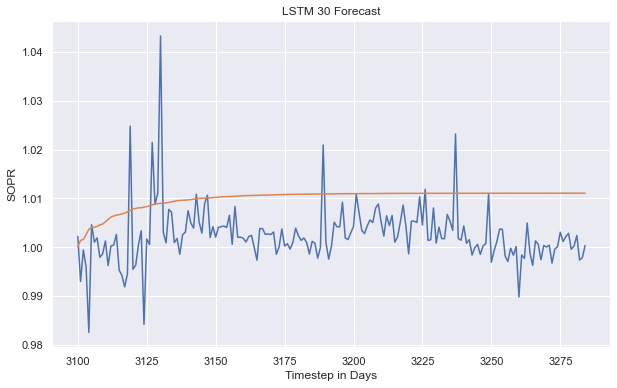

In [65]:
window_size = 30
# plot results
plt.figure(figsize=(10,6))

plt.ylabel('SOPR')
plt.xlabel('Timestep in Days')
plt.title(f'LSTM {window_size} Forecast')
plt.plot(x_test.index, x_test, label="Actual")
plt.plot(x_test.index, rnn_unscaled_forecast, label="Forecast")
plt.show()

In [66]:
# calculate MAE
lstm = mean_absolute_error(x_test, rnn_unscaled_forecast)

# Save to our dictionary of model mae scores
model_mae_scores['LSTM_iterative'] = lstm
model_mae_scores

{'naive': 0.004408076902271792,
 'SMA 20': 0.0033655691445564316,
 'SMA 5': 0.0030284014458080324,
 'ARIMA_recursive_true': 0.028628473741541063,
 'ARIMA_recursive_fake': 0.004259015438665774,
 'ARIMA_forecast': 0.027194289393659907,
 'LSTM_iterative': 0.008444810195474967}

Text(0.5, 1.0, 'Daily Data - Mean Average Error of All Models Tested')

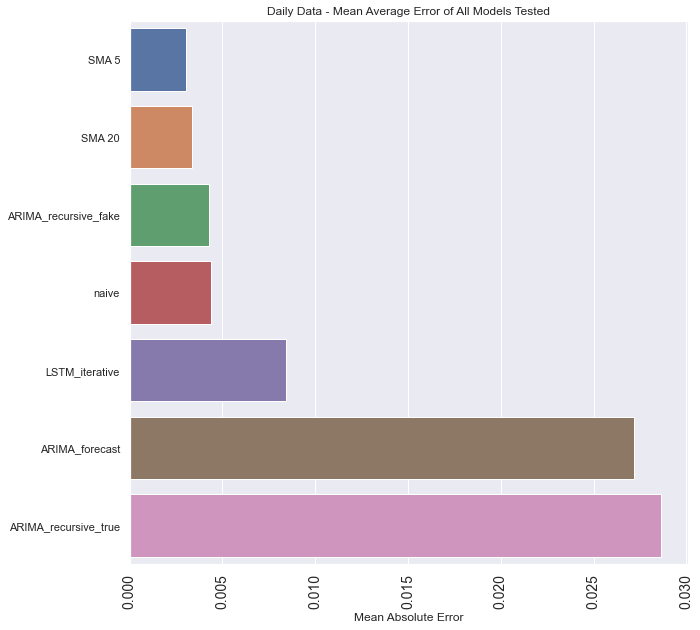

In [67]:
mae_series = pd.Series(model_mae_scores)
model_mae_scores

# Sort vales for clean bar chart
order = mae_series.sort_values()

# Create bar chart for to show MAE of all models side by side
sns.barplot(x=order.values, y = order.index, orient='h')
plt.xlabel('Mean Absolute Error')
plt.xticks(rotation='vertical',fontsize=14)
plt.title('Daily Data - Mean Average Error of All Models Tested')

In [68]:
# recall best model
model = keras.models.load_model("my_checkpoint")
# make predictions
rnn_forecast = model.predict(normalized_x_test[np.newaxis,:])
rnn_forecast = rnn_forecast.flatten()
# Example of how to iverse
rnn_unscaled_forecast = x_train_scaler.inverse_transform(rnn_forecast.reshape(-1,1)).flatten()
rnn_unscaled_forecast.shape

1/1 [==============================] - 1s 1s/step


(185,)

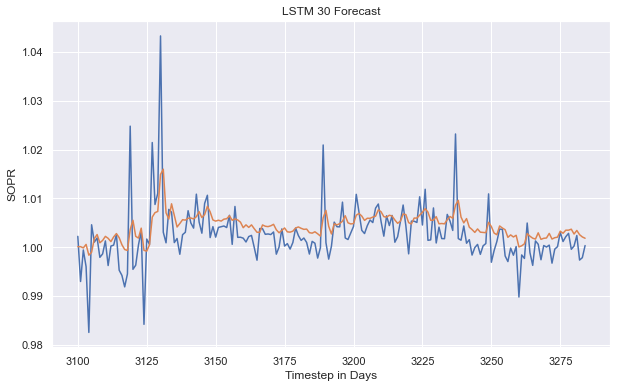

In [69]:
window_size = 30
# plot results
plt.figure(figsize=(10,6))

plt.ylabel('SOPR')
plt.xlabel('Timestep in Days')
plt.title(f'LSTM {window_size} Forecast')
plt.plot(x_test.index, x_test, label="Actual")
plt.plot(x_test.index, rnn_unscaled_forecast, label="Forecast")
plt.show()

Text(0.5, 1.0, 'Daily Data - Mean Average Error of All Models Tested')

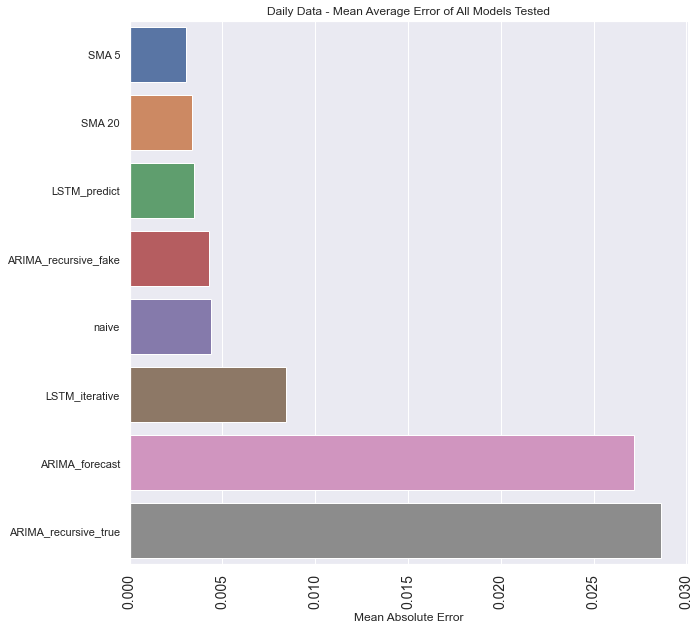

In [70]:
# calculate MAE
lstm = mean_absolute_error(x_test, rnn_unscaled_forecast)

# Save to our dictionary of model mae scores
model_mae_scores['LSTM_predict'] = lstm
model_mae_scores

mae_series = pd.Series(model_mae_scores)
model_mae_scores

# Sort vales for clean bar chart
order = mae_series.sort_values()

# Create bar chart for to show MAE of all models side by side
sns.barplot(x=order.values, y = order.index, orient='h')
plt.xlabel('Mean Absolute Error')
plt.xticks(rotation='vertical',fontsize=14)
plt.title('Daily Data - Mean Average Error of All Models Tested')

# CNN

Full CNNs are becoming more commom to detect trends in NLP and time series modeling. A popular architecture is the WaveNet architecture proposed by Deep Mind in 2016.

In WaveNet, every layer has kernel size 2, stride 1, causal padding, and using ReLU activation functions. However, the 2nd layer uses a dilation rate of 2. This means it skips every other input timestep. The next layer uses a dilation rate of 4 which means it skips every 3 input time steps. The fourth layer uses a dilation rate of 8 which means it skips every 7 timesteps out of 8. This patter continues which enables the lower layers to learn shorter term patterns while the deeper layers learn the longer term patterns.

The last layer acts as a dense layer to output a single value.

In [71]:
def seq2seq_window_dataset(series, window_size, batch_size=128,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)


def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

### Find the learning rate

In [72]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 20
train_set = seq2seq_window_dataset(normalized_x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )

model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))

optimizer = keras.optimizers.Nadam(lr=1e-4)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


/usr/local/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/nadam.py:86: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


23/23 [==============================] - 5s 30ms/step - loss: 0.1006 - mae: 0.4459 - lr: 1.0000e-04
Epoch 2/100
23/23 [==============================] - 1s 31ms/step - loss: 0.0922 - mae: 0.4267 - lr: 1.0798e-04
Epoch 3/100
23/23 [==============================] - 1s 29ms/step - loss: 0.0812 - mae: 0.3999 - lr: 1.1659e-04
Epoch 4/100
23/23 [==============================] - 1s 33ms/step - loss: 0.0631 - mae: 0.3510 - lr: 1.2589e-04
Epoch 5/100
23/23 [==============================] - 1s 29ms/step - loss: 0.0348 - mae: 0.2515 - lr: 1.3594e-04
Epoch 6/100
23/23 [==============================] - 1s 29ms/step - loss: 0.0127 - mae: 0.1295 - lr: 1.4678e-04
Epoch 7/100
23/23 [==============================] - 1s 30ms/step - loss: 0.0070 - mae: 0.0890 - lr: 1.5849e-04
Epoch 8/100
23/23 [==============================] - 1s 30ms/step - loss: 0.0042 - mae: 0.0625 - lr: 1.7113e-04
Epoch 9/100
23/23 [==============================] - 1s 30ms/step - loss: 0.0026 - mae: 0.0468 - lr: 1.8478e-04
Epoc

23/23 [==============================] - 1s 29ms/step - loss: 0.0012 - mae: 0.0312 - lr: 0.0271
Epoch 75/100
23/23 [==============================] - 1s 30ms/step - loss: 0.0012 - mae: 0.0297 - lr: 0.0293
Epoch 76/100
23/23 [==============================] - 1s 28ms/step - loss: 0.0012 - mae: 0.0294 - lr: 0.0316
Epoch 77/100
23/23 [==============================] - 1s 29ms/step - loss: 0.0012 - mae: 0.0298 - lr: 0.0341
Epoch 78/100
23/23 [==============================] - 1s 29ms/step - loss: 0.0012 - mae: 0.0298 - lr: 0.0369
Epoch 79/100
23/23 [==============================] - 1s 31ms/step - loss: 0.0012 - mae: 0.0307 - lr: 0.0398
Epoch 80/100
23/23 [==============================] - 1s 29ms/step - loss: 0.0013 - mae: 0.0317 - lr: 0.0430
Epoch 81/100
23/23 [==============================] - 1s 27ms/step - loss: 0.0014 - mae: 0.0359 - lr: 0.0464
Epoch 82/100
23/23 [==============================] - 1s 29ms/step - loss: 0.0012 - mae: 0.0299 - lr: 0.0501
Epoch 83/100
23/23 [============

(0.0001, 0.1, 0.0, 0.04)

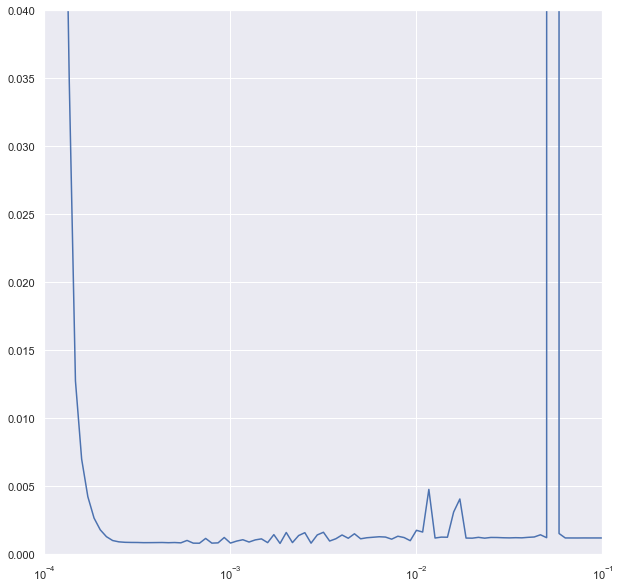

In [73]:
# Plot learning rate
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, .04])

In [74]:
#This is the best learning rate
my_lr = history.history["lr"][history.history["loss"].index(min(history.history["loss"]))]
#Arrotondo a 0.00027

In [75]:
# Clear any background data that may have stored
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Create input sequence batches
window_size = 30
train_set = seq2seq_window_dataset(normalized_x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(normalized_x_valid, window_size,
                                   batch_size=128)

# Create model object and set up wavenet architecture
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=128,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )

# Add final dense layer
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))

# Set Nadam as optimizer
optimizer = keras.optimizers.Nadam(lr=my_lr)

# Compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# save best model 
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)

# set early stopping
early_stopping = keras.callbacks.EarlyStopping(patience=50)

# sav history
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
23/23 [==============================] - 6s 151ms/step - loss: 0.0149 - mae: 0.1219 - val_loss: 0.0012 - val_mae: 0.0424
Epoch 2/500
23/23 [==============================] - 3s 123ms/step - loss: 0.0017 - mae: 0.0453 - val_loss: 6.6497e-04 - val_mae: 0.0313
Epoch 3/500
23/23 [==============================] - 3s 118ms/step - loss: 0.0018 - mae: 0.0479 - val_loss: 0.0013 - val_mae: 0.0461
Epoch 4/500
23/23 [==============================] - 3s 119ms/step - loss: 0.0016 - mae: 0.0439 - val_loss: 3.8678e-04 - val_mae: 0.0223
Epoch 5/500
23/23 [==============================] - 3s 119ms/step - loss: 0.0012 - mae: 0.0340 - val_loss: 0.0013 - val_mae: 0.0452
Epoch 6/500
23/23 [==============================] - 3s 119ms/step - loss: 0.0015 - mae: 0.0409 - val_loss: 3.0591e-04 - val_mae: 0.0185
Epoch 7/500
23/23 [==============================] - 3s 117ms/step - loss: 0.0013 - mae: 0.0349 - val_loss: 0.0013 - val_mae: 0.0460
Epoch 8/500
23/23 [==============================] - 3s 1

23/23 [==============================] - 3s 120ms/step - loss: 6.7253e-04 - mae: 0.0229 - val_loss: 3.7255e-04 - val_mae: 0.0221
Epoch 60/500
23/23 [==============================] - 3s 122ms/step - loss: 6.6389e-04 - mae: 0.0231 - val_loss: 3.0765e-04 - val_mae: 0.0181
Epoch 61/500
23/23 [==============================] - 3s 118ms/step - loss: 6.3433e-04 - mae: 0.0224 - val_loss: 3.1229e-04 - val_mae: 0.0200
Epoch 62/500
23/23 [==============================] - 3s 120ms/step - loss: 6.2024e-04 - mae: 0.0223 - val_loss: 2.7500e-04 - val_mae: 0.0168
Epoch 63/500
23/23 [==============================] - 4s 170ms/step - loss: 6.2259e-04 - mae: 0.0220 - val_loss: 2.4470e-04 - val_mae: 0.0166
Epoch 64/500
23/23 [==============================] - 5s 195ms/step - loss: 6.4913e-04 - mae: 0.0227 - val_loss: 2.4176e-04 - val_mae: 0.0164
Epoch 65/500
23/23 [==============================] - 3s 124ms/step - loss: 5.7763e-04 - mae: 0.0209 - val_loss: 2.5732e-04 - val_mae: 0.0164
Epoch 66/500
23/23 

In [76]:
# recall best model
model = keras.models.load_model("my_checkpoint")
# make predictions
yhat = normalized_x_test[0]
yhat = yhat[np.newaxis, :]
cnn_forecast = []
for i in range(len(normalized_x_test)):
    print(yhat.shape)
    yhat = model.predict(yhat)
    print(yhat.shape)
    print(i, "fatto")
    cnn_forecast.append(yhat)
    
cnn_forecast = np.array(cnn_forecast)
# Example of how to iverse
cnn_unscaled_forecast = x_train_scaler.inverse_transform(cnn_forecast.reshape(-1,1)).flatten()
cnn_unscaled_forecast.shape

(1, 1)
1/1 [==============================] - 2s 2s/step
(1, 1, 1)
0 fatto
(1, 1, 1)
1/1 [==============================] - 1s 1s/step
(1, 1, 1)
1 fatto
(1, 1, 1)
1/1 [==============================] - 0s 20ms/step
(1, 1, 1)
2 fatto
(1, 1, 1)
1/1 [==============================] - 0s 134ms/step
(1, 1, 1)
3 fatto
(1, 1, 1)
1/1 [==============================] - 0s 26ms/step
(1, 1, 1)
4 fatto
(1, 1, 1)
1/1 [==============================] - 0s 28ms/step
(1, 1, 1)
5 fatto
(1, 1, 1)
1/1 [==============================] - 0s 25ms/step
(1, 1, 1)
6 fatto
(1, 1, 1)
1/1 [==============================] - 0s 39ms/step
(1, 1, 1)
7 fatto
(1, 1, 1)
1/1 [==============================] - 0s 21ms/step
(1, 1, 1)
8 fatto
(1, 1, 1)
1/1 [==============================] - 0s 21ms/step
(1, 1, 1)
9 fatto
(1, 1, 1)
1/1 [==============================] - 0s 21ms/step
(1, 1, 1)
10 fatto
(1, 1, 1)
1/1 [==============================] - 0s 24ms/step
(1, 1, 1)
11 fatto
(1, 1, 1)
1/1 [=============================

1/1 [==============================] - 0s 26ms/step
(1, 1, 1)
101 fatto
(1, 1, 1)
1/1 [==============================] - 0s 25ms/step
(1, 1, 1)
102 fatto
(1, 1, 1)
1/1 [==============================] - 0s 22ms/step
(1, 1, 1)
103 fatto
(1, 1, 1)
1/1 [==============================] - 0s 20ms/step
(1, 1, 1)
104 fatto
(1, 1, 1)
1/1 [==============================] - 0s 21ms/step
(1, 1, 1)
105 fatto
(1, 1, 1)
1/1 [==============================] - 0s 34ms/step
(1, 1, 1)
106 fatto
(1, 1, 1)
1/1 [==============================] - 0s 20ms/step
(1, 1, 1)
107 fatto
(1, 1, 1)
1/1 [==============================] - 0s 20ms/step
(1, 1, 1)
108 fatto
(1, 1, 1)
1/1 [==============================] - 0s 21ms/step
(1, 1, 1)
109 fatto
(1, 1, 1)
1/1 [==============================] - 0s 23ms/step
(1, 1, 1)
110 fatto
(1, 1, 1)
1/1 [==============================] - 0s 24ms/step
(1, 1, 1)
111 fatto
(1, 1, 1)
1/1 [==============================] - 0s 20ms/step
(1, 1, 1)
112 fatto
(1, 1, 1)
1/1 [===========

(185,)

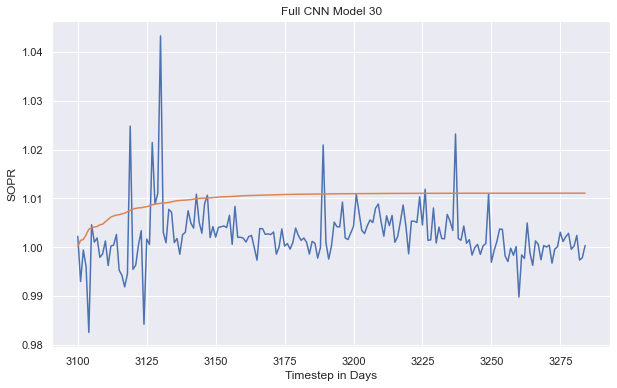

In [77]:
# Plot results
plt.figure(figsize=(10, 6))

plt.ylabel('SOPR')
plt.xlabel('Timestep in Days')
plt.title(f'Full CNN Model {window_size}')
plt.plot(x_test.index, x_test)
plt.plot(x_test.index, cnn_unscaled_forecast)

In [78]:
# Calculate MAE
cnn = mean_absolute_error(x_test, cnn_unscaled_forecast)

# Save to our dictionary of model mae scores
model_mae_scores['CNN_iterative'] = cnn
model_mae_scores

{'naive': 0.004408076902271792,
 'SMA 20': 0.0033655691445564316,
 'SMA 5': 0.0030284014458080324,
 'ARIMA_recursive_true': 0.028628473741541063,
 'ARIMA_recursive_fake': 0.004259015438665774,
 'ARIMA_forecast': 0.027194289393659907,
 'LSTM_iterative': 0.008444810195474967,
 'LSTM_predict': 0.0034616555746209135,
 'CNN_iterative': 0.008444810195474967}

Text(0.5, 1.0, 'Daily Data - Mean Average Error of All Models Tested')

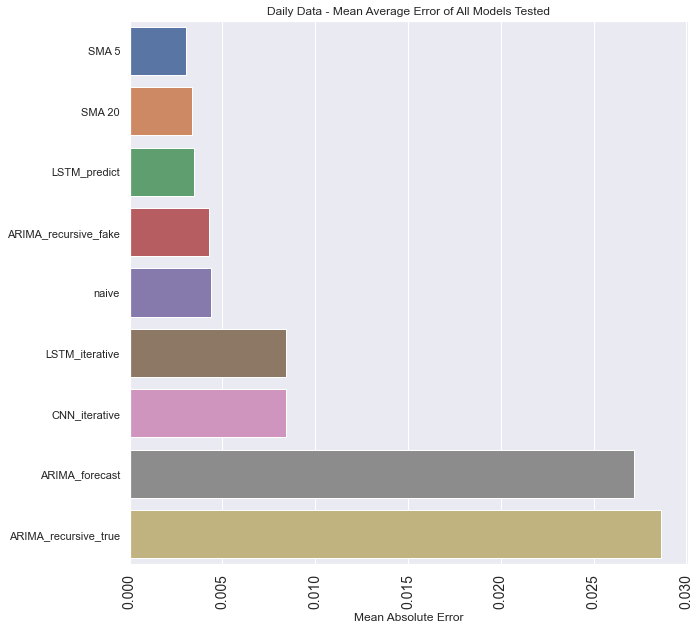

In [79]:
mae_series = pd.Series(model_mae_scores)
model_mae_scores

# Sort vales for clean bar chart
order = mae_series.sort_values()

# Create bar chart for to show MAE of all models side by side
sns.barplot(x=order.values, y = order.index, orient='h')
plt.xlabel('Mean Absolute Error')
plt.xticks(rotation='vertical',fontsize=14)
plt.title('Daily Data - Mean Average Error of All Models Tested')

In [80]:
# reload best model checkpoint
model = keras.models.load_model("my_checkpoint.h5")

# Use best model to get forecasts
cnn_forecast = model_forecast(model, np.concatenate((normalized_x_valid[-29:], normalized_x_test)), window_size)
cnn_forecast = cnn_forecast[:,-1,0]
cnn_forecast.shape
# Scale back to normal
cnn_unscaled_forecast = x_train_scaler.inverse_transform(cnn_forecast.reshape(-1,1)).flatten()
cnn_unscaled_forecast.shape

6/6 [==============================] - 1s 18ms/step


(185,)

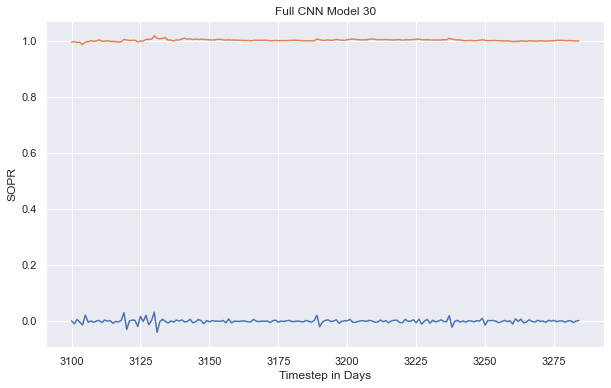

In [81]:
# Plot results
plt.figure(figsize=(10, 6))

plt.ylabel('SOPR')
plt.xlabel('Timestep in Days')
plt.title(f'Full CNN Model {window_size}')
plt.plot(x_test.index, x_test_diff)
plt.plot(x_test.index, cnn_unscaled_forecast)



Text(0.5, 1.0, 'Daily Data - Mean Average Error of All Models Tested')

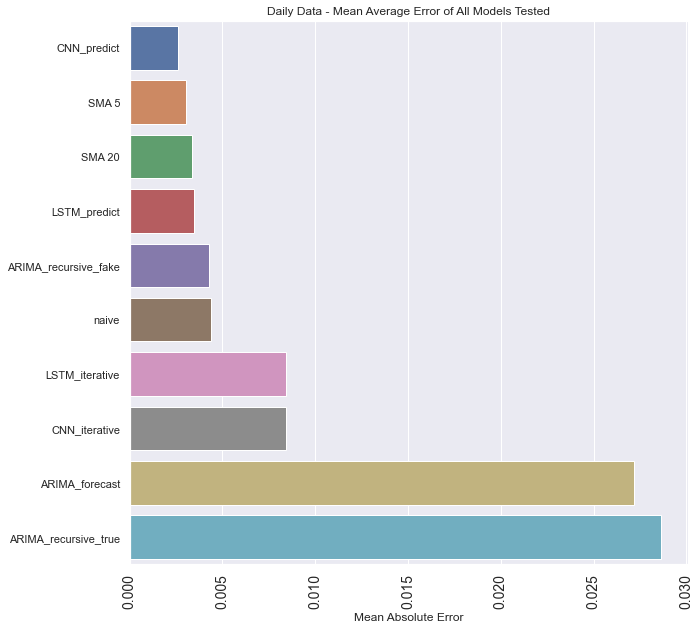

In [82]:
# Calculate MAE
cnn = mean_absolute_error(x_test, cnn_unscaled_forecast)

# Save to our dictionary of model mae scores
model_mae_scores['CNN_predict'] = cnn
model_mae_scores

mae_series = pd.Series(model_mae_scores)
model_mae_scores

# Sort vales for clean bar chart
order = mae_series.sort_values()

# Create bar chart for to show MAE of all models side by side
sns.barplot(x=order.values, y = order.index, orient='h')
plt.xlabel('Mean Absolute Error')
plt.xticks(rotation='vertical',fontsize=14)
plt.title('Daily Data - Mean Average Error of All Models Tested')

## DOWNSAMPLING A SERIE TEMPORALE WEEKLY

In [83]:
SOPR_weekly = SOPR
SOPR_weekly = SOPR_weekly.set_index('Timestamp')

SOPR_weekly = SOPR_weekly.resample('W').mean()
SOPR_weekly


Value    year
Timestamp                   
2013-01-06  1.004138  2013.0
2013-01-13  1.005585  2013.0
2013-01-20  1.009747  2013.0
2013-01-27  1.021318  2013.0
2013-02-03  1.027148  2013.0
...              ...     ...
2021-12-05  0.998839  2021.0
2021-12-12  0.999992  2021.0
2021-12-19  0.999284  2021.0
2021-12-26  1.001545  2021.0
2022-01-02  0.999533  2021.0

[470 rows x 2 columns]

In [84]:
SOPR_weekly["Timestamp"] = SOPR_weekly.index
SOPR_weekly

Value    year  Timestamp
Timestamp                              
2013-01-06  1.004138  2013.0 2013-01-06
2013-01-13  1.005585  2013.0 2013-01-13
2013-01-20  1.009747  2013.0 2013-01-20
2013-01-27  1.021318  2013.0 2013-01-27
2013-02-03  1.027148  2013.0 2013-02-03
...              ...     ...        ...
2021-12-05  0.998839  2021.0 2021-12-05
2021-12-12  0.999992  2021.0 2021-12-12
2021-12-19  0.999284  2021.0 2021-12-19
2021-12-26  1.001545  2021.0 2021-12-26
2022-01-02  0.999533  2021.0 2022-01-02

[470 rows x 3 columns]

In [85]:
SOPR_weekly.reset_index(drop=True, inplace=True)
SOPR_weekly

Value    year  Timestamp
0    1.004138  2013.0 2013-01-06
1    1.005585  2013.0 2013-01-13
2    1.009747  2013.0 2013-01-20
3    1.021318  2013.0 2013-01-27
4    1.027148  2013.0 2013-02-03
..        ...     ...        ...
465  0.998839  2021.0 2021-12-05
466  0.999992  2021.0 2021-12-12
467  0.999284  2021.0 2021-12-19
468  1.001545  2021.0 2021-12-26
469  0.999533  2021.0 2022-01-02

[470 rows x 3 columns]

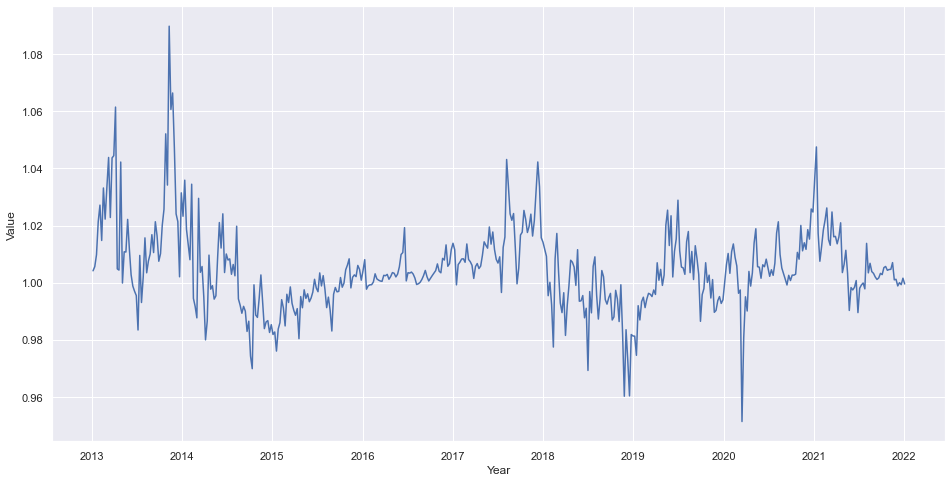

In [86]:
plt.figure(figsize=(16,8))
plt.plot(SOPR_weekly["Timestamp"], SOPR_weekly["Value"])
plt.gca().set(xlabel="Year", ylabel="Value")
#scommentare riga giù per visualizzare in scala log
#plt.yscale('log') 
plt.show()

# TRAIN/VAL/TEST SPLIT

data fine train = 2021-01-03 00:00:00  data inizio test = 2021-07-04 00:00:00


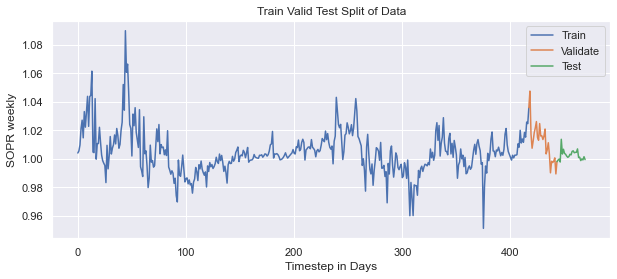

In [87]:
series = SOPR_weekly['Value']

tr_idx_w = SOPR_weekly.index[int((train_split_index/SOPR.shape[0])*SOPR_weekly.shape[0])]
te_idx_w = SOPR_weekly.index[int((test_split_index/SOPR.shape[0])*SOPR_weekly.shape[0])]
print('data fine train =',SOPR_weekly['Timestamp'][tr_idx_w], ' data inizio test =', SOPR_weekly['Timestamp'][te_idx_w])

x_train = SOPR_weekly.loc[:tr_idx_w,'Value']
x_test = SOPR_weekly.loc[te_idx_w:,'Value']
x_valid = SOPR_weekly.loc[tr_idx_w:te_idx_w,'Value']

# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 4]

# Create a plot showing the split of the train, valid, and test data
plt.plot(x_train, label = 'Train')
plt.plot(x_valid, label = 'Validate')
plt.plot(x_test, label = 'Test')
plt.title('Train Valid Test Split of Data')
plt.ylabel('SOPR weekly')
plt.xlabel('Timestep in Days')
plt.legend()

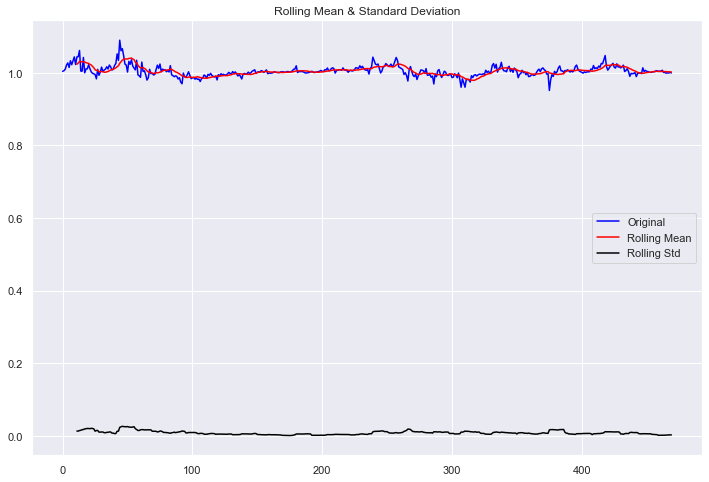

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -5.950465e+00
p-value                        2.153302e-07
#Lags Used                     1.000000e+00
Number of Observations Used    4.680000e+02
Critical Value (1%)           -3.444400e+00
Critical Value (5%)           -2.867736e+00
Critical Value (10%)          -2.570070e+00
dtype: float64


In [88]:
test_stationarity(series)

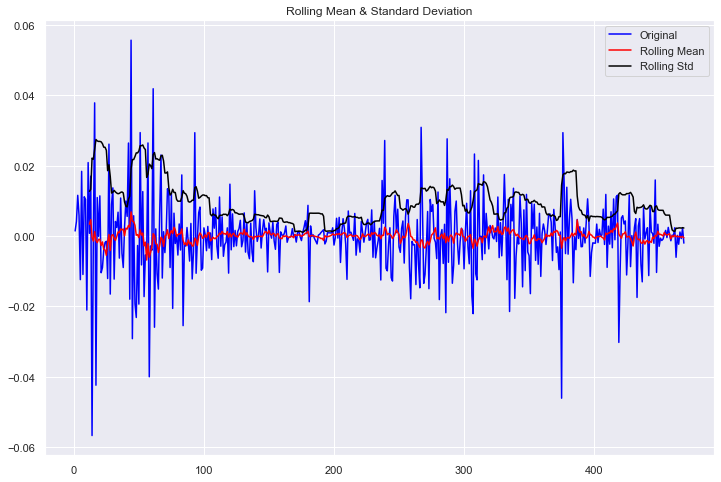

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.037223e+01
p-value                        2.248472e-18
#Lags Used                     8.000000e+00
Number of Observations Used    4.600000e+02
Critical Value (1%)           -3.444646e+00
Critical Value (5%)           -2.867844e+00
Critical Value (10%)          -2.570128e+00
dtype: float64


In [89]:
# Get the difference of each Adj Close point
SOPR_diff_1 = series.diff()
SOPR_diff_1.dropna(inplace=True)

# Plot the tsla Adj Close 1st order difference
test_stationarity(SOPR_diff_1)

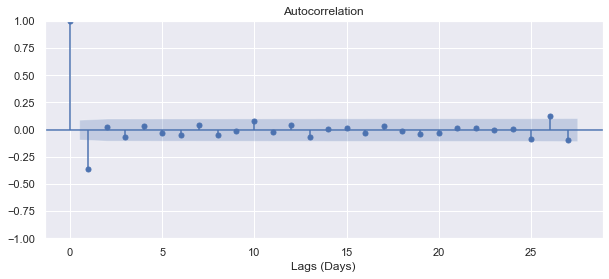

In [90]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(SOPR_diff_1)
plt.xlabel('Lags (Days)')
plt.show()

/usr/local/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


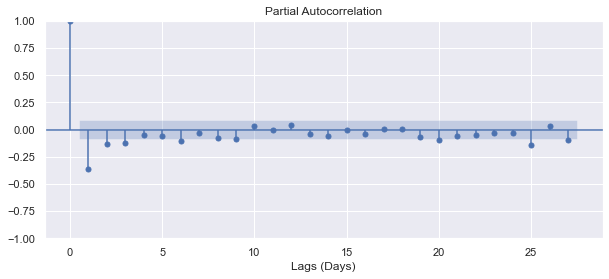

In [91]:
plot_pacf(SOPR_diff_1)
plt.xlabel('Lags (Days)')
plt.show()

------------- Auto SARIMA --------------- 

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[7] intercept   : AIC=-2670.179, Time=0.73 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=-2317.064, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=inf, Time=0.74 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=-2511.238, Time=0.61 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=1191.986, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=-2668.056, Time=0.24 sec
 ARIMA(1,0,1)(1,0,1)[7] intercept   : AIC=-2450.276, Time=1.02 sec
 ARIMA(1,0,1)(0,0,2)[7] intercept   : AIC=-2666.685, Time=1.53 sec
 ARIMA(1,0,1)(1,0,0)[7] intercept   : AIC=-2308.439, Time=0.94 sec
 ARIMA(1,0,1)(1,0,2)[7] intercept   : AIC=inf, Time=2.53 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=-2633.402, Time=0.64 sec
 ARIMA(2,0,1)(0,0,1)[7] intercept   : AIC=-2646.732, Time=0.96 sec
 ARIMA(1,0,2)(0,0,1)[7] intercept   : AIC=-2668.505, Time=1.00 sec
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=-2374.259, Ti

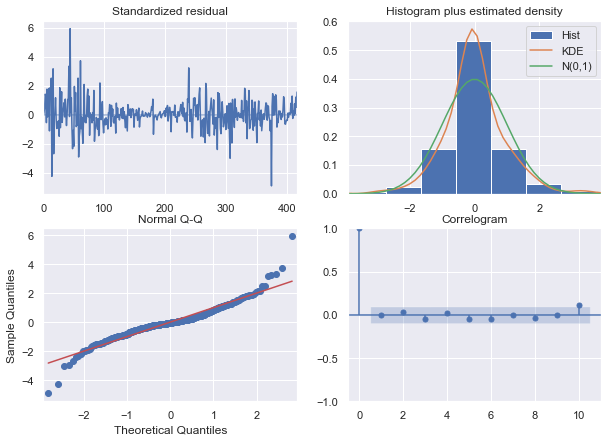

In [92]:
# Forecasting algorithm
input_ts_algo = 'auto_sarima' # choose the forecasting algorithm from 'auto_arima', 'auto_sarima', 'auto_sarimax', 'manual_sarima', 'simple_exponential_smoothing' and 'holt_winters'

input_seasonality = 7

# Get actual values
actuals = x_test.reset_index(drop = True)

# Select the algorithm according to the input provided
if input_ts_algo == 'auto_arima':
    
    print("------------- Auto ARIMA --------------- \n")
    model = model_auto_sarimax(y = x_train, seasonality = input_seasonality, seasonal_flag = False, exogenous_variable = None)
    
elif input_ts_algo == 'auto_sarima':
    
    print("------------- Auto SARIMA --------------- \n")
    model = model_auto_sarimax(y = x_train, seasonality = input_seasonality, seasonal_flag = True, exogenous_variable = None)
    
elif input_ts_algo == 'auto_sarimax':
    
    print("------------- Auto SARIMAX --------------- \n")
    model = model_auto_sarimax(y = x_train, seasonality = input_seasonality, seasonal_flag = False, exogenous_variable = train[input_exogenous_variable].values.reshape(-1, 1))

elif input_ts_algo == 'manual_sarima':
    input_order = (3,1,0)
    input_seasonal_order = (2,1,1,7)
    print("------------- Manual SARIMA --------------- \n")
    model = model_manual_sarima(y = x_train, order = input_order, seasonal_order = input_seasonal_order)

elif input_ts_algo == 'simple_exponential_smoothing':
    
    print("------------- Simple Exponential Smoothing --------------- \n")
    model = model_simple_exponential_smoothing(y = x_train)

In [93]:
# fit model
SOPR_arima = sm.tsa.arima.ARIMA(x_train, order=(3,1,1), seasonal_order=(0,0,2,7))
SOPR_arima_fit = SOPR_arima.fit()
print(SOPR_arima_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                Value   No. Observations:                  418
Model:             ARIMA(3, 1, 1)x(0, 0, [1, 2], 7)   Log Likelihood                1329.338
Date:                              Fri, 11 Nov 2022   AIC                          -2644.677
Time:                                      14:06:20   BIC                          -2616.445
Sample:                                           0   HQIC                         -2633.515
                                              - 418                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0739      0.180      0.411      0.681      -0.278       0.426
ar.L2          0.05

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


NormaltestResult(statistic=978.8469544641596, pvalue=2.7930873906752814e-213)
This distribution is not a normal distribution


/usr/local/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


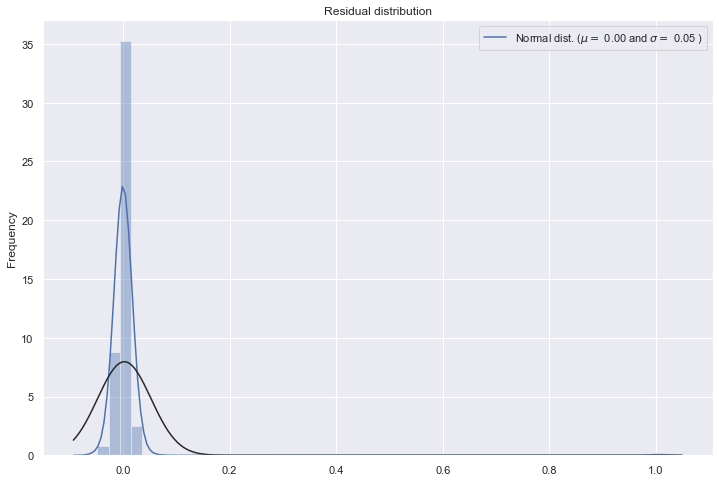

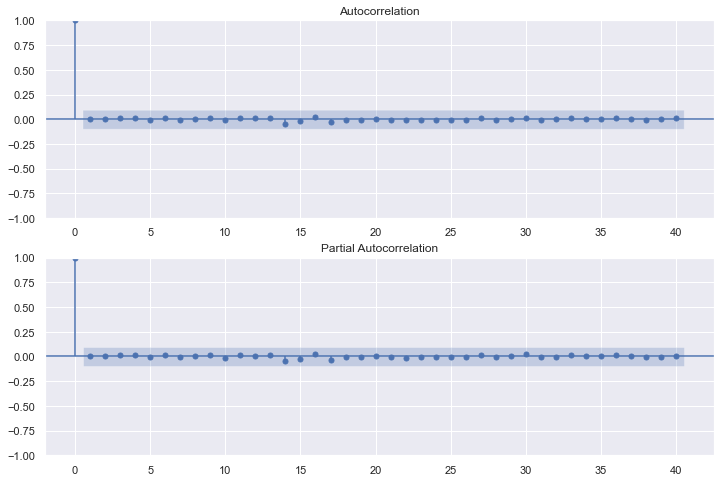

In [94]:
residuals = SOPR_arima_fit.resid
print(normaltest(residuals))
if normaltest(residuals)[1] < .05:
    print('This distribution is not a normal distribution')
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(residuals ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(residuals)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residuals, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residuals, lags=40, ax=ax2)

### Primo tipo di ARIMA: training ricorsivo true: train, predico 1 giorno, appendo la predizione, re-traino e così via

In [95]:
# Create list of x train valuess
history = [x for x in x_train]

In [96]:
# establish list for predictions
model_predictions = []

In [97]:
# Count number of test data points
N_test_observations = len(x_test)

#in questo modo prendo oggi, prevedo domani, appendo la previsione al trainset, retraino, predico ancora. 
#Questo è recursive learning, o autoregressive learning
# loop through every data point
for time_point in list(x_test.index[-N_test_observations:]):
    model = sm.tsa.arima.ARIMA(history, order=(3,1,1), seasonal_order=(0,0,2,7))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = x_test[time_point]
    #history.append(true_test_value)
    history.append(yhat)
    
MAE_error = mean_absolute_error(x_test, model_predictions)
print('Testing Mean Squared Error is {}'.format(MAE_error))

%store model_predictions

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimiz

Testing Mean Squared Error is 0.021973731880362304
Stored 'model_predictions' (list)


/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [98]:
output

array([1.02265025])

In [99]:
# %store model_predictions
%store -r model_predictions

# Check to see if it reloaded
model_predictions[:5]

[1.029103090002759,
 1.0298913567593166,
 1.029032601105362,
 1.0254587259828738,
 1.024869649531346]

In [100]:
model_predictions

[1.029103090002759,
 1.0298913567593166,
 1.029032601105362,
 1.0254587259828738,
 1.024869649531346,
 1.024212938654135,
 1.0252755118707948,
 1.0245385652527323,
 1.0249165915835245,
 1.0246015713738543,
 1.024754582915532,
 1.0246918965033407,
 1.0246073204069048,
 1.0242461222758221,
 1.024438903850488,
 1.0242257829178834,
 1.0243426267798397,
 1.0236125617134892,
 1.0231779669937984,
 1.0226946485913733,
 1.0227832897447422,
 1.022740462910921,
 1.0229384330813927,
 1.0229791261773604,
 1.0229322900212,
 1.0230339327595284,
 1.0226502525008934]

In [101]:
model_predictions = np.array(model_predictions).flatten()

# Calculate MAE
arima_mae = mean_absolute_error(x_test, model_predictions)

# Save to our dictionary of model mae scores
model_mae_scores_weekly = {}
model_mae_scores_weekly['ARIMA_weekly_recursive_true'] = arima_mae
model_mae_scores['ARIMA_weekly_recursive_true'] = arima_mae
model_mae_scores

{'naive': 0.004408076902271792,
 'SMA 20': 0.0033655691445564316,
 'SMA 5': 0.0030284014458080324,
 'ARIMA_recursive_true': 0.028628473741541063,
 'ARIMA_recursive_fake': 0.004259015438665774,
 'ARIMA_forecast': 0.027194289393659907,
 'LSTM_iterative': 0.008444810195474967,
 'LSTM_predict': 0.0034616555746209135,
 'CNN_iterative': 0.008444810195474967,
 'CNN_predict': 0.002628205132554232,
 'ARIMA_weekly_recursive_true': 0.021973731880362304}

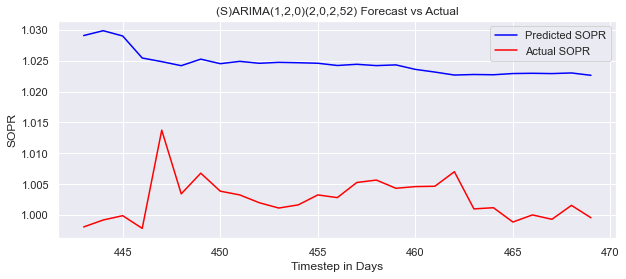

<Figure size 720x432 with 0 Axes>

In [102]:
# Plot our predictions against the actual values for a visual comparison.
plt.plot(x_test.index[-N_test_observations:], model_predictions[-N_test_observations:], color='blue',label='Predicted SOPR')
plt.plot(x_test.index[-N_test_observations:], x_test[-N_test_observations:], color='red', label='Actual SOPR')
plt.ylabel('SOPR')
plt.xlabel('Timestep in Days')
plt.title('(S)ARIMA(1,2,0)(2,0,2,52) Forecast vs Actual')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

In [103]:
# Find the Error in the ARIMA Model
arima_error = model_predictions - x_test

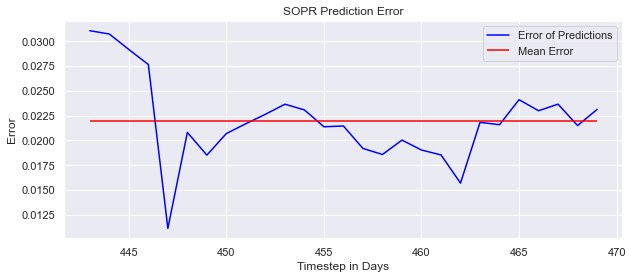

<Figure size 720x432 with 0 Axes>

In [104]:
plt.plot(x_test.index, arima_error, color='blue',label='Error of Predictions')
plt.hlines(np.mean(arima_error),xmin=x_test.index.min(),xmax=x_test.index.max(), color = 'red', label = 'Mean Error')
# plt.plot(x_valid.index, x_valid, color='red', label='Actual Price')
plt.title('SOPR Prediction Error')
plt.xlabel('Timestep in Days')
plt.ylabel('Error')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

In [105]:
mae_series = pd.Series(model_mae_scores)
model_mae_scores

{'naive': 0.004408076902271792,
 'SMA 20': 0.0033655691445564316,
 'SMA 5': 0.0030284014458080324,
 'ARIMA_recursive_true': 0.028628473741541063,
 'ARIMA_recursive_fake': 0.004259015438665774,
 'ARIMA_forecast': 0.027194289393659907,
 'LSTM_iterative': 0.008444810195474967,
 'LSTM_predict': 0.0034616555746209135,
 'CNN_iterative': 0.008444810195474967,
 'CNN_predict': 0.002628205132554232,
 'ARIMA_weekly_recursive_true': 0.021973731880362304}

### Secondo tipo di ARIMA: predizione ricorsiva fake: train, predico, aggiungo al trainset il primo valore VERO del test set e ricomincio (quindi sarebbe una predizione di un giorno, visto che appendo il valore vero del test set)

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimiz

Testing Mean Squared Error is 0.0038598671725004856
Stored 'model_predictions' (list)


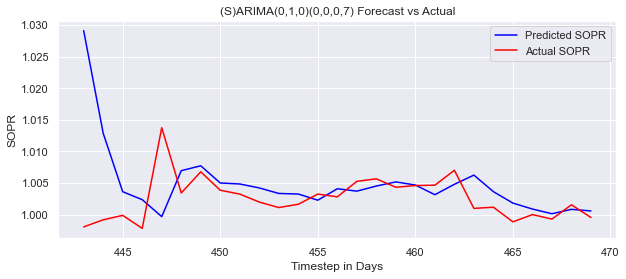

<Figure size 720x432 with 0 Axes>

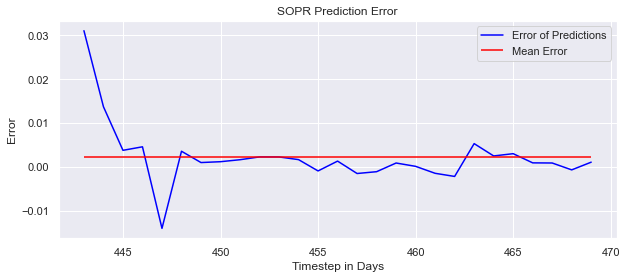

<Figure size 720x432 with 0 Axes>

{'naive': 0.004408076902271792,
 'SMA 20': 0.0033655691445564316,
 'SMA 5': 0.0030284014458080324,
 'ARIMA_recursive_true': 0.028628473741541063,
 'ARIMA_recursive_fake': 0.004259015438665774,
 'ARIMA_forecast': 0.027194289393659907,
 'LSTM_iterative': 0.008444810195474967,
 'LSTM_predict': 0.0034616555746209135,
 'CNN_iterative': 0.008444810195474967,
 'CNN_predict': 0.002628205132554232,
 'ARIMA_weekly_recursive_true': 0.021973731880362304,
 'ARIMA_weekly_recursive_fake': 0.0038598671725004856}

In [106]:
# Create list of x train valuess
history = [x for x in x_train]

# establish list for predictions
model_predictions = []

# Count number of test data points
N_test_observations = len(x_test)

#Invece qui sotto faccio training e finisco. 
#Poi predico domani, metto in input la predizione e predico dopodomani, accumulando l'errore.
#Spiegata in matematichese per bene qui, su iterative forecasting:
#https://thuijskens.github.io/2016/08/03/time-series-forecasting/
# loop through every data point
for time_point in list(x_test.index[-N_test_observations:]):
    model = sm.tsa.arima.ARIMA(history, order=(3,1,1), seasonal_order=(0,0,2,7))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = x_test[time_point]
    history.append(true_test_value)
    #history.append(yhat)
    
MAE_error = mean_absolute_error(x_test, model_predictions)
print('Testing Mean Squared Error is {}'.format(MAE_error))

%store model_predictions

# %store model_predictions
%store -r model_predictions

# Check to see if it reloaded
model_predictions[:5]

model_predictions = np.array(model_predictions).flatten()

# Calculate MAE
arima_mae = mean_absolute_error(x_test, model_predictions)

# Save to our dictionary of model mae scores
model_mae_scores_weekly['ARIMA_weekly_recursive_fake'] = arima_mae
model_mae_scores['ARIMA_weekly_recursive_fake'] = arima_mae
model_mae_scores

# Plot our predictions against the actual values for a visual comparison.
plt.plot(x_test.index[-N_test_observations:], model_predictions[-N_test_observations:], color='blue',label='Predicted SOPR')
plt.plot(x_test.index[-N_test_observations:], x_test[-N_test_observations:], color='red', label='Actual SOPR')
plt.ylabel('SOPR')
plt.xlabel('Timestep in Days')
plt.title('(S)ARIMA(0,1,0)(0,0,0,7) Forecast vs Actual')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

# Find the Error in the ARIMA Model
arima_error = model_predictions - x_test

plt.plot(x_test.index, arima_error, color='blue',label='Error of Predictions')
plt.hlines(np.mean(arima_error),xmin=x_test.index.min(),xmax=x_test.index.max(), color = 'red', label = 'Mean Error')
# plt.plot(x_valid.index, x_valid, color='red', label='Actual Price')
plt.title('SOPR Prediction Error')
plt.xlabel('Timestep in Days')
plt.ylabel('Error')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

mae_series = pd.Series(model_mae_scores)
model_mae_scores

### Terzo tipo di ARIMA: predizione ricorsiva true: train, predico, aggiungo al trainset il primo valore PREDETTO del test set e ricomincio

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing Mean Squared Error is 0.02638916067747538
Stored 'model_predictions' (ndarray)


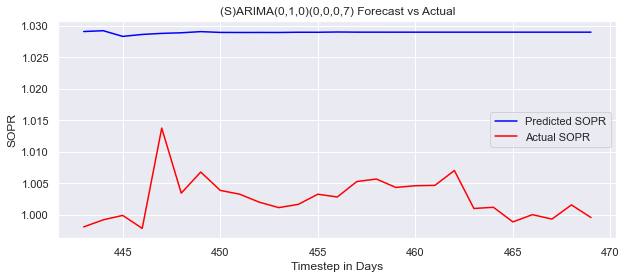

<Figure size 720x432 with 0 Axes>

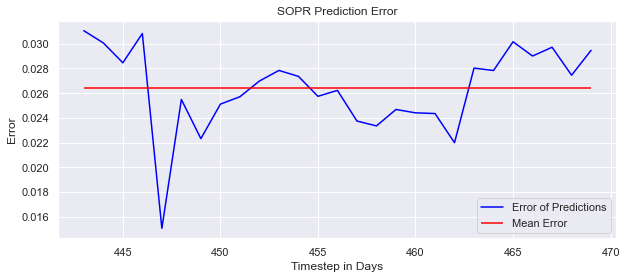

<Figure size 720x432 with 0 Axes>

{'naive': 0.004408076902271792,
 'SMA 20': 0.0033655691445564316,
 'SMA 5': 0.0030284014458080324,
 'ARIMA_recursive_true': 0.028628473741541063,
 'ARIMA_recursive_fake': 0.004259015438665774,
 'ARIMA_forecast': 0.027194289393659907,
 'LSTM_iterative': 0.008444810195474967,
 'LSTM_predict': 0.0034616555746209135,
 'CNN_iterative': 0.008444810195474967,
 'CNN_predict': 0.002628205132554232,
 'ARIMA_weekly_recursive_true': 0.021973731880362304,
 'ARIMA_weekly_recursive_fake': 0.0038598671725004856,
 'ARIMA_weekly_forecast': 0.02638916067747538}

In [107]:
# Create list of x train valuess
history = [x for x in x_train]

# establish list for predictions
model_predictions = []

# Count number of test data points
N_test_observations = len(x_test)

#Invece qui sotto faccio training e finisco. 
#Poi predico domani, metto in input la predizione e predico dopodomani, accumulando l'errore.
#Spiegata in matematichese per bene qui, su iterative forecasting:
#https://thuijskens.github.io/2016/08/03/time-series-forecasting/
# loop through every data point
model = sm.tsa.arima.ARIMA(history, order=(3,1,1), seasonal_order=(0,0,2,7))
model_fit = model.fit()
output = model_fit.forecast(len(x_test))
#yhat = output[0]
model_predictions = output
    
MAE_error = mean_absolute_error(x_test, model_predictions)
print('Testing Mean Squared Error is {}'.format(MAE_error))

%store model_predictions

# %store model_predictions
%store -r model_predictions

# Check to see if it reloaded
model_predictions[:5]

model_predictions = np.array(model_predictions).flatten()

# Calculate MAE
arima_mae = mean_absolute_error(x_test, model_predictions)

# Save to our dictionary of model mae scores
model_mae_scores_weekly['ARIMA_weekly_forecast'] = arima_mae
model_mae_scores['ARIMA_weekly_forecast'] = arima_mae
model_mae_scores

# Plot our predictions against the actual values for a visual comparison.
plt.plot(x_test.index[-N_test_observations:], model_predictions[-N_test_observations:], color='blue',label='Predicted SOPR')
plt.plot(x_test.index[-N_test_observations:], x_test[-N_test_observations:], color='red', label='Actual SOPR')
plt.ylabel('SOPR')
plt.xlabel('Timestep in Days')
plt.title('(S)ARIMA(0,1,0)(0,0,0,7) Forecast vs Actual')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

# Find the Error in the ARIMA Model
arima_error = model_predictions - x_test

plt.plot(x_test.index, arima_error, color='blue',label='Error of Predictions')
plt.hlines(np.mean(arima_error),xmin=x_test.index.min(),xmax=x_test.index.max(), color = 'red', label = 'Mean Error')
# plt.plot(x_valid.index, x_valid, color='red', label='Actual Price')
plt.title('SOPR Prediction Error')
plt.xlabel('Timestep in Days')
plt.ylabel('Error')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

mae_series = pd.Series(model_mae_scores)
model_mae_scores

# LSTM

In [108]:
# Reshape values
x_train_values = x_train.values.reshape(-1, 1)
x_valid_values = x_valid.values.reshape(-1, 1)
x_test_values = x_test.values.reshape(-1, 1)

#  Create Scaler Object
x_train_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit x_train values
normalized_x_train = x_train_scaler.fit_transform(x_train_values)

# Fit x_valid values
normalized_x_valid = x_train_scaler.transform(x_valid_values)

# Fit x_test values
normalized_x_test = x_train_scaler.transform(x_test_values)

# All values normalized to training data
spy_normalized_to_traindata = x_train_scaler.transform(series.values.reshape(-1, 1))

# Example of how to iverse
# inversed = scaler.inverse_transform(normalized_x_train).flatten()

In [109]:
# reset any stored data
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Set window size and create input batch sequences
window_size = 20
train_set = sequential_window_dataset(normalized_x_train, window_size)

# create model
model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
])

# create lr
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))
reset_states = ResetStatesCallback()

# choose optimizer
optimizer = keras.optimizers.Nadam(lr=1e-5)

# compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# set history
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/100


/usr/local/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/nadam.py:86: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


20/20 [==============================] - 10s 18ms/step - loss: 0.0695 - mae: 0.3573 - lr: 1.0000e-05
Epoch 2/100
20/20 [==============================] - 0s 16ms/step - loss: 0.0641 - mae: 0.3419 - lr: 1.1220e-05
Epoch 3/100
20/20 [==============================] - 0s 20ms/step - loss: 0.0577 - mae: 0.3228 - lr: 1.2589e-05
Epoch 4/100
20/20 [==============================] - 0s 17ms/step - loss: 0.0506 - mae: 0.3003 - lr: 1.4125e-05
Epoch 5/100
20/20 [==============================] - 0s 20ms/step - loss: 0.0427 - mae: 0.2732 - lr: 1.5849e-05
Epoch 6/100
20/20 [==============================] - 0s 16ms/step - loss: 0.0339 - mae: 0.2393 - lr: 1.7783e-05
Epoch 7/100
20/20 [==============================] - 0s 15ms/step - loss: 0.0246 - mae: 0.1965 - lr: 1.9953e-05
Epoch 8/100
20/20 [==============================] - 0s 15ms/step - loss: 0.0156 - mae: 0.1449 - lr: 2.2387e-05
Epoch 9/100
20/20 [==============================] - 0s 16ms/step - loss: 0.0094 - mae: 0.0980 - lr: 2.5119e-05
Epo

Epoch 75/100
20/20 [==============================] - 0s 15ms/step - loss: 0.0043 - mae: 0.0642 - lr: 0.0501
Epoch 76/100
20/20 [==============================] - 0s 15ms/step - loss: 0.0040 - mae: 0.0618 - lr: 0.0562
Epoch 77/100
20/20 [==============================] - 0s 20ms/step - loss: 0.0041 - mae: 0.0625 - lr: 0.0631
Epoch 78/100
20/20 [==============================] - 0s 24ms/step - loss: 0.0043 - mae: 0.0641 - lr: 0.0708
Epoch 79/100
20/20 [==============================] - 0s 17ms/step - loss: 0.0037 - mae: 0.0604 - lr: 0.0794
Epoch 80/100
20/20 [==============================] - 0s 25ms/step - loss: 0.0039 - mae: 0.0614 - lr: 0.0891
Epoch 81/100
20/20 [==============================] - 0s 21ms/step - loss: 0.0041 - mae: 0.0637 - lr: 0.1000
Epoch 82/100
20/20 [==============================] - 0s 22ms/step - loss: 0.0043 - mae: 0.0654 - lr: 0.1122
Epoch 83/100
20/20 [==============================] - 0s 19ms/step - loss: 0.0050 - mae: 0.0703 - lr: 0.1259
Epoch 84/100
20/20 

In [110]:
#This is the best learning rate
my_lr = history.history["lr"][history.history["loss"].index(min(history.history["loss"]))]
#Arrotondo a 0.001

In [111]:
# reset any stored data
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# set window size and create input batch sequence
window_size = 30
train_set = sequential_window_dataset(normalized_x_train, window_size)
valid_set = sequential_window_dataset(normalized_x_valid, window_size)

# create model
model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
])

# set optimizer
optimizer = keras.optimizers.Nadam(lr=my_lr)

# compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# reset states
reset_states = ResetStatesCallback()

#set up save best only checkpoint
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)

early_stopping = keras.callbacks.EarlyStopping(patience=50)

# fit model
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
     12/Unknown - 10s 22ms/step - loss: 0.0205 - mae: 0.1447WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 12s 180ms/step - loss: 0.0193 - mae: 0.1379
Epoch 2/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0048 - mae: 0.0672WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 28ms/step - loss: 0.0048 - mae: 0.0662
Epoch 3/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0042 - mae: 0.0649WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 27ms/step - loss: 0.0042 - mae: 0.0641
Epoch 4/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0041 - mae: 0.0646WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 28ms/step - loss: 0.0041 - mae: 0.0639
Epoch 5/500
11/13 [========================>.....] - ETA: 0s - loss: 0.0039 - mae: 0.0625WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 31ms/step - loss: 0.0040 - mae: 0.0639
Epoch 6/500
13/13 [==============================] - ETA: 0s - loss: 0.0040 - mae: 0.0639WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 42ms/step - loss: 0.0040 - mae: 0.0639
Epoch 7/500
13/13 [==============================] - ETA: 0s - loss: 0.0039 - mae: 0.0638WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 42ms/step - loss: 0.0039 - mae: 0.0638
Epoch 8/500
13/13 [==============================] - ETA: 0s - loss: 0.0039 - mae: 0.0637WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 46ms/step - loss: 0.0039 - mae: 0.0637
Epoch 9/500
13/13 [==============================] - ETA: 0s - loss: 0.0038 - mae: 0.0634WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 36ms/step - loss: 0.0038 - mae: 0.0634
Epoch 10/500
13/13 [==============================] - ETA: 0s - loss: 0.0038 - mae: 0.0629WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 35ms/step - loss: 0.0038 - mae: 0.0629
Epoch 11/500
13/13 [==============================] - ETA: 0s - loss: 0.0037 - mae: 0.0623WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 42ms/step - loss: 0.0037 - mae: 0.0623
Epoch 12/500
13/13 [==============================] - ETA: 0s - loss: 0.0036 - mae: 0.0615WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 39ms/step - loss: 0.0036 - mae: 0.0615
Epoch 13/500
13/13 [==============================] - ETA: 0s - loss: 0.0035 - mae: 0.0606WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 40ms/step - loss: 0.0035 - mae: 0.0606
Epoch 14/500
13/13 [==============================] - ETA: 0s - loss: 0.0034 - mae: 0.0598WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 41ms/step - loss: 0.0034 - mae: 0.0598
Epoch 15/500
11/13 [========================>.....] - ETA: 0s - loss: 0.0032 - mae: 0.0587WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 36ms/step - loss: 0.0033 - mae: 0.0589
Epoch 16/500
13/13 [==============================] - ETA: 0s - loss: 0.0032 - mae: 0.0582WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 42ms/step - loss: 0.0032 - mae: 0.0582
Epoch 17/500
13/13 [==============================] - ETA: 0s - loss: 0.0032 - mae: 0.0576WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 28ms/step - loss: 0.0032 - mae: 0.0576
Epoch 18/500
13/13 [==============================] - ETA: 0s - loss: 0.0031 - mae: 0.0570WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 35ms/step - loss: 0.0031 - mae: 0.0570
Epoch 19/500
13/13 [==============================] - ETA: 0s - loss: 0.0031 - mae: 0.0565WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 39ms/step - loss: 0.0031 - mae: 0.0565
Epoch 20/500
11/13 [========================>.....] - ETA: 0s - loss: 0.0030 - mae: 0.0558WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 36ms/step - loss: 0.0030 - mae: 0.0561
Epoch 21/500
13/13 [==============================] - ETA: 0s - loss: 0.0030 - mae: 0.0557WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 33ms/step - loss: 0.0030 - mae: 0.0557
Epoch 22/500
13/13 [==============================] - ETA: 0s - loss: 0.0030 - mae: 0.0554WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 35ms/step - loss: 0.0030 - mae: 0.0554
Epoch 23/500
13/13 [==============================] - ETA: 0s - loss: 0.0030 - mae: 0.0552WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 41ms/step - loss: 0.0030 - mae: 0.0552
Epoch 24/500
13/13 [==============================] - ETA: 0s - loss: 0.0029 - mae: 0.0550WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 29ms/step - loss: 0.0029 - mae: 0.0550
Epoch 25/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0029 - mae: 0.0557WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 31ms/step - loss: 0.0029 - mae: 0.0548
Epoch 26/500
11/13 [========================>.....] - ETA: 0s - loss: 0.0028 - mae: 0.0543WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 27ms/step - loss: 0.0029 - mae: 0.0546
Epoch 27/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0029 - mae: 0.0552WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 26ms/step - loss: 0.0029 - mae: 0.0544
Epoch 28/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0029 - mae: 0.0551WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 32ms/step - loss: 0.0029 - mae: 0.0543
Epoch 29/500
13/13 [==============================] - ETA: 0s - loss: 0.0029 - mae: 0.0541WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 36ms/step - loss: 0.0029 - mae: 0.0541
Epoch 30/500
13/13 [==============================] - ETA: 0s - loss: 0.0029 - mae: 0.0540WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 24ms/step - loss: 0.0029 - mae: 0.0540
Epoch 31/500
13/13 [==============================] - ETA: 0s - loss: 0.0029 - mae: 0.0539WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 22ms/step - loss: 0.0029 - mae: 0.0539
Epoch 32/500
13/13 [==============================] - ETA: 0s - loss: 0.0029 - mae: 0.0538WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 21ms/step - loss: 0.0029 - mae: 0.0538
Epoch 33/500
13/13 [==============================] - ETA: 0s - loss: 0.0029 - mae: 0.0537WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 22ms/step - loss: 0.0029 - mae: 0.0537
Epoch 34/500
13/13 [==============================] - ETA: 0s - loss: 0.0029 - mae: 0.0536WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 22ms/step - loss: 0.0029 - mae: 0.0536
Epoch 35/500
13/13 [==============================] - ETA: 0s - loss: 0.0028 - mae: 0.0535WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 23ms/step - loss: 0.0028 - mae: 0.0535
Epoch 36/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0028 - mae: 0.0543WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 28ms/step - loss: 0.0028 - mae: 0.0535
Epoch 37/500
13/13 [==============================] - ETA: 0s - loss: 0.0028 - mae: 0.0532WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 40ms/step - loss: 0.0028 - mae: 0.0532
Epoch 38/500
11/13 [========================>.....] - ETA: 0s - loss: 0.0027 - mae: 0.0525WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 36ms/step - loss: 0.0028 - mae: 0.0528
Epoch 39/500
13/13 [==============================] - ETA: 0s - loss: 0.0029 - mae: 0.0534WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 34ms/step - loss: 0.0029 - mae: 0.0534
Epoch 40/500
13/13 [==============================] - ETA: 0s - loss: 0.0028 - mae: 0.0539WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 35ms/step - loss: 0.0028 - mae: 0.0539
Epoch 41/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0028 - mae: 0.0539WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 26ms/step - loss: 0.0028 - mae: 0.0531
Epoch 42/500
13/13 [==============================] - ETA: 0s - loss: 0.0028 - mae: 0.0529WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 39ms/step - loss: 0.0028 - mae: 0.0529
Epoch 43/500
13/13 [==============================] - ETA: 0s - loss: 0.0028 - mae: 0.0528WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 37ms/step - loss: 0.0028 - mae: 0.0528
Epoch 44/500
13/13 [==============================] - ETA: 0s - loss: 0.0028 - mae: 0.0526WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 37ms/step - loss: 0.0028 - mae: 0.0526
Epoch 45/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0029 - mae: 0.0538WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 44ms/step - loss: 0.0029 - mae: 0.0530
Epoch 46/500
13/13 [==============================] - ETA: 0s - loss: 0.0028 - mae: 0.0526WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 30ms/step - loss: 0.0028 - mae: 0.0526
Epoch 47/500
13/13 [==============================] - ETA: 0s - loss: 0.0028 - mae: 0.0526WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 30ms/step - loss: 0.0028 - mae: 0.0526
Epoch 48/500
13/13 [==============================] - ETA: 0s - loss: 0.0027 - mae: 0.0517WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 23ms/step - loss: 0.0027 - mae: 0.0517
Epoch 49/500
13/13 [==============================] - ETA: 0s - loss: 0.0029 - mae: 0.0538WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 22ms/step - loss: 0.0029 - mae: 0.0538
Epoch 50/500
13/13 [==============================] - ETA: 0s - loss: 0.0027 - mae: 0.0524WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 21ms/step - loss: 0.0027 - mae: 0.0524
Epoch 51/500
13/13 [==============================] - ETA: 0s - loss: 0.0028 - mae: 0.0526WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 32ms/step - loss: 0.0028 - mae: 0.0526
Epoch 52/500
13/13 [==============================] - ETA: 0s - loss: 0.0027 - mae: 0.0523WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 35ms/step - loss: 0.0027 - mae: 0.0523
Epoch 53/500
13/13 [==============================] - ETA: 0s - loss: 0.0028 - mae: 0.0518WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 36ms/step - loss: 0.0028 - mae: 0.0518
Epoch 54/500
13/13 [==============================] - ETA: 0s - loss: 0.0028 - mae: 0.0520WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 34ms/step - loss: 0.0028 - mae: 0.0520
Epoch 55/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0027 - mae: 0.0521WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 28ms/step - loss: 0.0027 - mae: 0.0515
Epoch 56/500
13/13 [==============================] - ETA: 0s - loss: 0.0028 - mae: 0.0523WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 35ms/step - loss: 0.0028 - mae: 0.0523
Epoch 57/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0030 - mae: 0.0552WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 35ms/step - loss: 0.0039 - mae: 0.0632
Epoch 58/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0059 - mae: 0.0823WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 30ms/step - loss: 0.0057 - mae: 0.0793
Epoch 59/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0034 - mae: 0.0603WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 42ms/step - loss: 0.0034 - mae: 0.0589
Epoch 60/500
13/13 [==============================] - ETA: 0s - loss: 0.0030 - mae: 0.0554WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 40ms/step - loss: 0.0030 - mae: 0.0554
Epoch 61/500
13/13 [==============================] - ETA: 0s - loss: 0.0028 - mae: 0.0533WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 30ms/step - loss: 0.0028 - mae: 0.0533
Epoch 62/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0027 - mae: 0.0530WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 30ms/step - loss: 0.0027 - mae: 0.0522
Epoch 63/500
13/13 [==============================] - ETA: 0s - loss: 0.0027 - mae: 0.0518WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 23ms/step - loss: 0.0027 - mae: 0.0518
Epoch 64/500
13/13 [==============================] - ETA: 0s - loss: 0.0027 - mae: 0.0515WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 40ms/step - loss: 0.0027 - mae: 0.0515
Epoch 65/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0026 - mae: 0.0519WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 28ms/step - loss: 0.0027 - mae: 0.0513
Epoch 66/500
13/13 [==============================] - ETA: 0s - loss: 0.0026 - mae: 0.0511WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.0511
Epoch 67/500
11/13 [========================>.....] - ETA: 0s - loss: 0.0026 - mae: 0.0508WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 29ms/step - loss: 0.0026 - mae: 0.0509
Epoch 68/500
13/13 [==============================] - ETA: 0s - loss: 0.0026 - mae: 0.0507WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 27ms/step - loss: 0.0026 - mae: 0.0507
Epoch 69/500
13/13 [==============================] - ETA: 0s - loss: 0.0026 - mae: 0.0505WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 25ms/step - loss: 0.0026 - mae: 0.0505
Epoch 70/500
13/13 [==============================] - ETA: 0s - loss: 0.0026 - mae: 0.0503WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 39ms/step - loss: 0.0026 - mae: 0.0503
Epoch 71/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0025 - mae: 0.0507WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 33ms/step - loss: 0.0026 - mae: 0.0501
Epoch 72/500
13/13 [==============================] - ETA: 0s - loss: 0.0026 - mae: 0.0501WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 23ms/step - loss: 0.0026 - mae: 0.0501
Epoch 73/500
11/13 [========================>.....] - ETA: 0s - loss: 0.0026 - mae: 0.0508WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 31ms/step - loss: 0.0026 - mae: 0.0506
Epoch 74/500
13/13 [==============================] - ETA: 0s - loss: 0.0026 - mae: 0.0507WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 32ms/step - loss: 0.0026 - mae: 0.0507
Epoch 75/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0026 - mae: 0.0505WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 46ms/step - loss: 0.0026 - mae: 0.0499
Epoch 76/500
13/13 [==============================] - ETA: 0s - loss: 0.0029 - mae: 0.0526WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 32ms/step - loss: 0.0029 - mae: 0.0526
Epoch 77/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0027 - mae: 0.0521WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 41ms/step - loss: 0.0027 - mae: 0.0514
Epoch 78/500
13/13 [==============================] - ETA: 0s - loss: 0.0025 - mae: 0.0498WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 38ms/step - loss: 0.0025 - mae: 0.0498
Epoch 79/500
13/13 [==============================] - ETA: 0s - loss: 0.0026 - mae: 0.0500WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 33ms/step - loss: 0.0026 - mae: 0.0500
Epoch 80/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0025 - mae: 0.0508WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 31ms/step - loss: 0.0026 - mae: 0.0503
Epoch 81/500
13/13 [==============================] - ETA: 0s - loss: 0.0025 - mae: 0.0499WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 33ms/step - loss: 0.0025 - mae: 0.0499
Epoch 82/500
13/13 [==============================] - ETA: 0s - loss: 0.0025 - mae: 0.0492WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 34ms/step - loss: 0.0025 - mae: 0.0492
Epoch 83/500
13/13 [==============================] - ETA: 0s - loss: 0.0025 - mae: 0.0495WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 35ms/step - loss: 0.0025 - mae: 0.0495
Epoch 84/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0024 - mae: 0.0494WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 33ms/step - loss: 0.0025 - mae: 0.0492
Epoch 85/500
13/13 [==============================] - ETA: 0s - loss: 0.0028 - mae: 0.0518WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 33ms/step - loss: 0.0028 - mae: 0.0518
Epoch 86/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0026 - mae: 0.0514WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 38ms/step - loss: 0.0026 - mae: 0.0508
Epoch 87/500
13/13 [==============================] - ETA: 0s - loss: 0.0025 - mae: 0.0501WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 35ms/step - loss: 0.0025 - mae: 0.0501
Epoch 88/500
13/13 [==============================] - ETA: 0s - loss: 0.0026 - mae: 0.0500WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.0500
Epoch 89/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0025 - mae: 0.0509WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 43ms/step - loss: 0.0026 - mae: 0.0504
Epoch 90/500
13/13 [==============================] - ETA: 0s - loss: 0.0025 - mae: 0.0489WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 37ms/step - loss: 0.0025 - mae: 0.0489
Epoch 91/500
13/13 [==============================] - ETA: 0s - loss: 0.0026 - mae: 0.0503WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 37ms/step - loss: 0.0026 - mae: 0.0503
Epoch 92/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0027 - mae: 0.0534WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 35ms/step - loss: 0.0027 - mae: 0.0526
Epoch 93/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0024 - mae: 0.0503WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 38ms/step - loss: 0.0025 - mae: 0.0497
Epoch 94/500
13/13 [==============================] - ETA: 0s - loss: 0.0028 - mae: 0.0516WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 30ms/step - loss: 0.0028 - mae: 0.0516
Epoch 95/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0025 - mae: 0.0510WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 33ms/step - loss: 0.0025 - mae: 0.0504
Epoch 96/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0024 - mae: 0.0495WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 36ms/step - loss: 0.0024 - mae: 0.0491
Epoch 97/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0025 - mae: 0.0496WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 53ms/step - loss: 0.0025 - mae: 0.0492
Epoch 98/500
13/13 [==============================] - ETA: 0s - loss: 0.0027 - mae: 0.0507WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 22ms/step - loss: 0.0027 - mae: 0.0507
Epoch 99/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0026 - mae: 0.0515WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 24ms/step - loss: 0.0027 - mae: 0.0509
Epoch 100/500
13/13 [==============================] - ETA: 0s - loss: 0.0026 - mae: 0.0496WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 30ms/step - loss: 0.0026 - mae: 0.0496
Epoch 101/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0027 - mae: 0.0523WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 26ms/step - loss: 0.0027 - mae: 0.0515
Epoch 102/500
11/13 [========================>.....] - ETA: 0s - loss: 0.0026 - mae: 0.0509WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 31ms/step - loss: 0.0026 - mae: 0.0506
Epoch 103/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0025 - mae: 0.0500WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 47ms/step - loss: 0.0025 - mae: 0.0494
Epoch 104/500
13/13 [==============================] - ETA: 0s - loss: 0.0025 - mae: 0.0492WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 35ms/step - loss: 0.0025 - mae: 0.0492
Epoch 105/500
13/13 [==============================] - ETA: 0s - loss: 0.0025 - mae: 0.0496WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 38ms/step - loss: 0.0025 - mae: 0.0496
Epoch 106/500
13/13 [==============================] - ETA: 0s - loss: 0.0025 - mae: 0.0496WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 28ms/step - loss: 0.0025 - mae: 0.0496
Epoch 107/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0026 - mae: 0.0509WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 32ms/step - loss: 0.0026 - mae: 0.0502
Epoch 108/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0026 - mae: 0.0504WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 36ms/step - loss: 0.0026 - mae: 0.0497
Epoch 109/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0025 - mae: 0.0505WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 32ms/step - loss: 0.0026 - mae: 0.0498
Epoch 110/500
13/13 [==============================] - ETA: 0s - loss: 0.0027 - mae: 0.0507WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 38ms/step - loss: 0.0027 - mae: 0.0507
Epoch 111/500
13/13 [==============================] - ETA: 0s - loss: 0.0025 - mae: 0.0500WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 32ms/step - loss: 0.0025 - mae: 0.0500
Epoch 112/500
13/13 [==============================] - ETA: 0s - loss: 0.0025 - mae: 0.0496WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 34ms/step - loss: 0.0025 - mae: 0.0496
Epoch 113/500
13/13 [==============================] - ETA: 0s - loss: 0.0027 - mae: 0.0497WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 41ms/step - loss: 0.0027 - mae: 0.0497
Epoch 114/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0025 - mae: 0.0502WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 32ms/step - loss: 0.0025 - mae: 0.0495
Epoch 115/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0025 - mae: 0.0501WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 33ms/step - loss: 0.0025 - mae: 0.0495
Epoch 116/500
13/13 [==============================] - ETA: 0s - loss: 0.0025 - mae: 0.0500WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 45ms/step - loss: 0.0025 - mae: 0.0500
Epoch 117/500
13/13 [==============================] - ETA: 0s - loss: 0.0025 - mae: 0.0496WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 46ms/step - loss: 0.0025 - mae: 0.0496
Epoch 118/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0026 - mae: 0.0504WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 32ms/step - loss: 0.0026 - mae: 0.0498
Epoch 119/500
13/13 [==============================] - ETA: 0s - loss: 0.0025 - mae: 0.0492WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 36ms/step - loss: 0.0025 - mae: 0.0492
Epoch 120/500
13/13 [==============================] - ETA: 0s - loss: 0.0025 - mae: 0.0491WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 36ms/step - loss: 0.0025 - mae: 0.0491
Epoch 121/500
13/13 [==============================] - ETA: 0s - loss: 0.0027 - mae: 0.0506WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 39ms/step - loss: 0.0027 - mae: 0.0506
Epoch 122/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0025 - mae: 0.0502WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 36ms/step - loss: 0.0025 - mae: 0.0495
Epoch 123/500
13/13 [==============================] - ETA: 0s - loss: 0.0025 - mae: 0.0489WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 50ms/step - loss: 0.0025 - mae: 0.0489
Epoch 124/500
13/13 [==============================] - ETA: 0s - loss: 0.0027 - mae: 0.0510WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 42ms/step - loss: 0.0027 - mae: 0.0510
Epoch 125/500
13/13 [==============================] - ETA: 0s - loss: 0.0025 - mae: 0.0486WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 42ms/step - loss: 0.0025 - mae: 0.0486
Epoch 126/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0025 - mae: 0.0497WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 39ms/step - loss: 0.0025 - mae: 0.0491
Epoch 127/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0024 - mae: 0.0486WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 48ms/step - loss: 0.0024 - mae: 0.0484
Epoch 128/500
13/13 [==============================] - ETA: 0s - loss: 0.0024 - mae: 0.0491WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 37ms/step - loss: 0.0024 - mae: 0.0491
Epoch 129/500
13/13 [==============================] - ETA: 0s - loss: 0.0030 - mae: 0.0545WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 43ms/step - loss: 0.0030 - mae: 0.0545
Epoch 130/500
13/13 [==============================] - ETA: 0s - loss: 0.0027 - mae: 0.0510WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 57ms/step - loss: 0.0027 - mae: 0.0510
Epoch 131/500
13/13 [==============================] - ETA: 0s - loss: 0.0025 - mae: 0.0497WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 31ms/step - loss: 0.0025 - mae: 0.0497
Epoch 132/500
13/13 [==============================] - ETA: 0s - loss: 0.0025 - mae: 0.0486WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 25ms/step - loss: 0.0025 - mae: 0.0486
Epoch 133/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0023 - mae: 0.0482WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 23ms/step - loss: 0.0023 - mae: 0.0479
Epoch 134/500
13/13 [==============================] - ETA: 0s - loss: 0.0024 - mae: 0.0483WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 22ms/step - loss: 0.0024 - mae: 0.0483
Epoch 135/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0022 - mae: 0.0478WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 34ms/step - loss: 0.0023 - mae: 0.0475
Epoch 136/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0023 - mae: 0.0482WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 26ms/step - loss: 0.0024 - mae: 0.0479
Epoch 137/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0023 - mae: 0.0486WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 30ms/step - loss: 0.0024 - mae: 0.0480
Epoch 138/500
13/13 [==============================] - ETA: 0s - loss: 0.0025 - mae: 0.0486WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 22ms/step - loss: 0.0025 - mae: 0.0486
Epoch 139/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0024 - mae: 0.0483WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 27ms/step - loss: 0.0024 - mae: 0.0479
Epoch 140/500
10/13 [======================>.......] - ETA: 0s - loss: 0.0022 - mae: 0.0471WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 20ms/step - loss: 0.0023 - mae: 0.0476
Epoch 141/500
13/13 [==============================] - ETA: 0s - loss: 0.0024 - mae: 0.0476WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 34ms/step - loss: 0.0024 - mae: 0.0476
Epoch 142/500
13/13 [==============================] - ETA: 0s - loss: 0.0024 - mae: 0.0482WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 42ms/step - loss: 0.0024 - mae: 0.0482
Epoch 143/500
13/13 [==============================] - ETA: 0s - loss: 0.0023 - mae: 0.0473WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 34ms/step - loss: 0.0023 - mae: 0.0473
Epoch 144/500
13/13 [==============================] - ETA: 0s - loss: 0.0024 - mae: 0.0487WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 55ms/step - loss: 0.0024 - mae: 0.0487
Epoch 145/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0023 - mae: 0.0486WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 53ms/step - loss: 0.0023 - mae: 0.0482
Epoch 146/500
13/13 [==============================] - ETA: 0s - loss: 0.0022 - mae: 0.0474WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 48ms/step - loss: 0.0022 - mae: 0.0474
Epoch 147/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0022 - mae: 0.0480WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 41ms/step - loss: 0.0023 - mae: 0.0487
Epoch 148/500
13/13 [==============================] - ETA: 0s - loss: 0.0023 - mae: 0.0498WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 52ms/step - loss: 0.0023 - mae: 0.0498
Epoch 149/500
13/13 [==============================] - ETA: 0s - loss: 0.0027 - mae: 0.0532WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 43ms/step - loss: 0.0027 - mae: 0.0532
Epoch 150/500
11/13 [========================>.....] - ETA: 0s - loss: 0.0028 - mae: 0.0544WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 40ms/step - loss: 0.0028 - mae: 0.0540
Epoch 151/500
13/13 [==============================] - ETA: 0s - loss: 0.0025 - mae: 0.0498WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 39ms/step - loss: 0.0025 - mae: 0.0498
Epoch 152/500
13/13 [==============================] - ETA: 0s - loss: 0.0023 - mae: 0.0473WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 44ms/step - loss: 0.0023 - mae: 0.0473
Epoch 153/500
13/13 [==============================] - ETA: 0s - loss: 0.0023 - mae: 0.0473WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 34ms/step - loss: 0.0023 - mae: 0.0473
Epoch 154/500
13/13 [==============================] - ETA: 0s - loss: 0.0022 - mae: 0.0472WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 33ms/step - loss: 0.0022 - mae: 0.0472
Epoch 155/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0025 - mae: 0.0500WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 42ms/step - loss: 0.0025 - mae: 0.0495
Epoch 156/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0022 - mae: 0.0484WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 32ms/step - loss: 0.0023 - mae: 0.0482
Epoch 157/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0022 - mae: 0.0486WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 38ms/step - loss: 0.0023 - mae: 0.0483
Epoch 158/500
13/13 [==============================] - ETA: 0s - loss: 0.0025 - mae: 0.0491WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 43ms/step - loss: 0.0025 - mae: 0.0491
Epoch 159/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0023 - mae: 0.0479WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 34ms/step - loss: 0.0023 - mae: 0.0476
Epoch 160/500
13/13 [==============================] - ETA: 0s - loss: 0.0023 - mae: 0.0493WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 40ms/step - loss: 0.0023 - mae: 0.0493
Epoch 161/500
13/13 [==============================] - ETA: 0s - loss: 0.0022 - mae: 0.0465WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 37ms/step - loss: 0.0022 - mae: 0.0465
Epoch 162/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0022 - mae: 0.0477WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 37ms/step - loss: 0.0023 - mae: 0.0481
Epoch 163/500
13/13 [==============================] - ETA: 0s - loss: 0.0021 - mae: 0.0463WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 48ms/step - loss: 0.0021 - mae: 0.0463
Epoch 164/500
13/13 [==============================] - ETA: 0s - loss: 0.0025 - mae: 0.0493WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 43ms/step - loss: 0.0025 - mae: 0.0493
Epoch 165/500
13/13 [==============================] - ETA: 0s - loss: 0.0021 - mae: 0.0469WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 41ms/step - loss: 0.0021 - mae: 0.0469
Epoch 166/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0020 - mae: 0.0453WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.0454
Epoch 167/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0021 - mae: 0.0467WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 25ms/step - loss: 0.0022 - mae: 0.0474
Epoch 168/500
13/13 [==============================] - ETA: 0s - loss: 0.0020 - mae: 0.0466WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 28ms/step - loss: 0.0020 - mae: 0.0466
Epoch 169/500
13/13 [==============================] - ETA: 0s - loss: 0.0021 - mae: 0.0474WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 30ms/step - loss: 0.0021 - mae: 0.0474
Epoch 170/500
13/13 [==============================] - ETA: 0s - loss: 0.0020 - mae: 0.0455WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 37ms/step - loss: 0.0020 - mae: 0.0455
Epoch 171/500
13/13 [==============================] - ETA: 0s - loss: 0.0020 - mae: 0.0461WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 38ms/step - loss: 0.0020 - mae: 0.0461
Epoch 172/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0019 - mae: 0.0456WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.0455
Epoch 173/500
13/13 [==============================] - ETA: 0s - loss: 0.0021 - mae: 0.0460WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 41ms/step - loss: 0.0021 - mae: 0.0460
Epoch 174/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0019 - mae: 0.0452WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 41ms/step - loss: 0.0020 - mae: 0.0458
Epoch 175/500
13/13 [==============================] - ETA: 0s - loss: 0.0023 - mae: 0.0488WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 32ms/step - loss: 0.0023 - mae: 0.0488
Epoch 176/500
11/13 [========================>.....] - ETA: 0s - loss: 0.0019 - mae: 0.0454WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 30ms/step - loss: 0.0020 - mae: 0.0465
Epoch 177/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0018 - mae: 0.0449WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 31ms/step - loss: 0.0019 - mae: 0.0454
Epoch 178/500
11/13 [========================>.....] - ETA: 0s - loss: 0.0018 - mae: 0.0433WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 38ms/step - loss: 0.0020 - mae: 0.0451
Epoch 179/500
13/13 [==============================] - ETA: 0s - loss: 0.0021 - mae: 0.0482WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 28ms/step - loss: 0.0021 - mae: 0.0482
Epoch 180/500
13/13 [==============================] - ETA: 0s - loss: 0.0025 - mae: 0.0504WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 36ms/step - loss: 0.0025 - mae: 0.0504
Epoch 181/500
13/13 [==============================] - ETA: 0s - loss: 0.0024 - mae: 0.0487WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 42ms/step - loss: 0.0024 - mae: 0.0487
Epoch 182/500
13/13 [==============================] - ETA: 0s - loss: 0.0023 - mae: 0.0488WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 35ms/step - loss: 0.0023 - mae: 0.0488
Epoch 183/500
13/13 [==============================] - ETA: 0s - loss: 0.0021 - mae: 0.0466WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 34ms/step - loss: 0.0021 - mae: 0.0466
Epoch 184/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0017 - mae: 0.0433WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.0436
Epoch 185/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0018 - mae: 0.0435WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 31ms/step - loss: 0.0019 - mae: 0.0437
Epoch 186/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0020 - mae: 0.0466WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 28ms/step - loss: 0.0021 - mae: 0.0463
Epoch 187/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0017 - mae: 0.0427WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 29ms/step - loss: 0.0018 - mae: 0.0429
Epoch 188/500
13/13 [==============================] - ETA: 0s - loss: 0.0017 - mae: 0.0428WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 29ms/step - loss: 0.0017 - mae: 0.0428
Epoch 189/500
13/13 [==============================] - ETA: 0s - loss: 0.0016 - mae: 0.0422WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 30ms/step - loss: 0.0016 - mae: 0.0422
Epoch 190/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0015 - mae: 0.0416WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.0420
Epoch 191/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0016 - mae: 0.0429WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.0430
Epoch 192/500
13/13 [==============================] - ETA: 0s - loss: 0.0018 - mae: 0.0443WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 39ms/step - loss: 0.0018 - mae: 0.0443
Epoch 193/500
13/13 [==============================] - ETA: 0s - loss: 0.0017 - mae: 0.0414WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 32ms/step - loss: 0.0017 - mae: 0.0414
Epoch 194/500
13/13 [==============================] - ETA: 0s - loss: 0.0019 - mae: 0.0455WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 31ms/step - loss: 0.0019 - mae: 0.0455
Epoch 195/500
13/13 [==============================] - ETA: 0s - loss: 0.0015 - mae: 0.0410WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 38ms/step - loss: 0.0015 - mae: 0.0410
Epoch 196/500
13/13 [==============================] - ETA: 0s - loss: 0.0015 - mae: 0.0393WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 37ms/step - loss: 0.0015 - mae: 0.0393
Epoch 197/500
13/13 [==============================] - ETA: 0s - loss: 0.0015 - mae: 0.0406WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 31ms/step - loss: 0.0015 - mae: 0.0406
Epoch 198/500
13/13 [==============================] - ETA: 0s - loss: 0.0019 - mae: 0.0455WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 39ms/step - loss: 0.0019 - mae: 0.0455
Epoch 199/500
13/13 [==============================] - ETA: 0s - loss: 0.0018 - mae: 0.0430WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 27ms/step - loss: 0.0018 - mae: 0.0430
Epoch 200/500
13/13 [==============================] - ETA: 0s - loss: 0.0015 - mae: 0.0401WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.0401
Epoch 201/500
13/13 [==============================] - ETA: 0s - loss: 0.0014 - mae: 0.0385WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 31ms/step - loss: 0.0014 - mae: 0.0385
Epoch 202/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0012 - mae: 0.0373 WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 26ms/step - loss: 0.0013 - mae: 0.0376
Epoch 203/500
13/13 [==============================] - ETA: 0s - loss: 0.0014 - mae: 0.0391WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 33ms/step - loss: 0.0014 - mae: 0.0391
Epoch 204/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0021 - mae: 0.0478WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 29ms/step - loss: 0.0022 - mae: 0.0480
Epoch 205/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0017 - mae: 0.0443WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 41ms/step - loss: 0.0018 - mae: 0.0446
Epoch 206/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0015 - mae: 0.0416WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 33ms/step - loss: 0.0016 - mae: 0.0413
Epoch 207/500
13/13 [==============================] - ETA: 0s - loss: 0.0014 - mae: 0.0384WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 47ms/step - loss: 0.0014 - mae: 0.0384
Epoch 208/500
13/13 [==============================] - ETA: 0s - loss: 0.0017 - mae: 0.0431WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 40ms/step - loss: 0.0017 - mae: 0.0431
Epoch 209/500
11/13 [========================>.....] - ETA: 0s - loss: 0.0018 - mae: 0.0446WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.0467
Epoch 210/500
13/13 [==============================] - ETA: 0s - loss: 0.0017 - mae: 0.0421WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 29ms/step - loss: 0.0017 - mae: 0.0421
Epoch 211/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0014 - mae: 0.0392WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 32ms/step - loss: 0.0014 - mae: 0.0389
Epoch 212/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0014 - mae: 0.0396WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 31ms/step - loss: 0.0015 - mae: 0.0392
Epoch 213/500
11/13 [========================>.....] - ETA: 0s - loss: 0.0014 - mae: 0.0381 WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 28ms/step - loss: 0.0015 - mae: 0.0388
Epoch 214/500
13/13 [==============================] - ETA: 0s - loss: 0.0015 - mae: 0.0404 WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 26ms/step - loss: 0.0015 - mae: 0.0404
Epoch 215/500
11/13 [========================>.....] - ETA: 0s - loss: 0.0013 - mae: 0.0384WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 28ms/step - loss: 0.0014 - mae: 0.0396
Epoch 216/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0012 - mae: 0.0354    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 28ms/step - loss: 0.0012 - mae: 0.0354
Epoch 217/500
13/13 [==============================] - ETA: 0s - loss: 0.0013 - mae: 0.0362 WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 25ms/step - loss: 0.0013 - mae: 0.0362
Epoch 218/500
13/13 [==============================] - ETA: 0s - loss: 0.0013 - mae: 0.0370WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 44ms/step - loss: 0.0013 - mae: 0.0370
Epoch 219/500
13/13 [==============================] - ETA: 0s - loss: 0.0012 - mae: 0.0357   WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 31ms/step - loss: 0.0012 - mae: 0.0357
Epoch 220/500
13/13 [==============================] - ETA: 0s - loss: 0.0014 - mae: 0.0398 WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 25ms/step - loss: 0.0014 - mae: 0.0398
Epoch 221/500
13/13 [==============================] - ETA: 0s - loss: 0.0013 - mae: 0.0376   WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 26ms/step - loss: 0.0013 - mae: 0.0376
Epoch 222/500
13/13 [==============================] - ETA: 0s - loss: 0.0011 - mae: 0.0323    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 30ms/step - loss: 0.0011 - mae: 0.0323
Epoch 223/500
12/13 [==========================>...] - ETA: 0s - loss: 9.0136e-04 - mae: 0.0308WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 46ms/step - loss: 9.8317e-04 - mae: 0.0314
Epoch 224/500
12/13 [==========================>...] - ETA: 0s - loss: 9.6335e-04 - mae: 0.0333WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0342
Epoch 225/500
11/13 [========================>.....] - ETA: 0s - loss: 0.0013 - mae: 0.0374WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 28ms/step - loss: 0.0014 - mae: 0.0389
Epoch 226/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0013 - mae: 0.0365WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 27ms/step - loss: 0.0013 - mae: 0.0365
Epoch 227/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0014 - mae: 0.0390WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 27ms/step - loss: 0.0015 - mae: 0.0398
Epoch 228/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0019 - mae: 0.0473WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 27ms/step - loss: 0.0019 - mae: 0.0469
Epoch 229/500
13/13 [==============================] - ETA: 0s - loss: 0.0017 - mae: 0.0428WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 30ms/step - loss: 0.0017 - mae: 0.0428
Epoch 230/500
11/13 [========================>.....] - ETA: 0s - loss: 0.0010 - mae: 0.0340    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 30ms/step - loss: 0.0012 - mae: 0.0355
Epoch 231/500
13/13 [==============================] - ETA: 0s - loss: 0.0011 - mae: 0.0354   WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 29ms/step - loss: 0.0011 - mae: 0.0354
Epoch 232/500
11/13 [========================>.....] - ETA: 0s - loss: 8.0696e-04 - mae: 0.0303WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 26ms/step - loss: 8.9654e-04 - mae: 0.0308
Epoch 233/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0011 - mae: 0.0355WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 25ms/step - loss: 0.0012 - mae: 0.0355
Epoch 234/500
13/13 [==============================] - ETA: 0s - loss: 9.2890e-04 - mae: 0.0317WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 24ms/step - loss: 9.2890e-04 - mae: 0.0317
Epoch 235/500
11/13 [========================>.....] - ETA: 0s - loss: 7.6411e-04 - mae: 0.0295WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 25ms/step - loss: 8.9068e-04 - mae: 0.0310
Epoch 236/500
12/13 [==========================>...] - ETA: 0s - loss: 8.6472e-04 - mae: 0.0314WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 26ms/step - loss: 9.3838e-04 - mae: 0.0320
Epoch 237/500
13/13 [==============================] - ETA: 0s - loss: 0.0011 - mae: 0.0339    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 23ms/step - loss: 0.0011 - mae: 0.0339
Epoch 238/500
13/13 [==============================] - ETA: 0s - loss: 0.0010 - mae: 0.0349    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 25ms/step - loss: 0.0010 - mae: 0.0349
Epoch 239/500
13/13 [==============================] - ETA: 0s - loss: 0.0014 - mae: 0.0382   WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 25ms/step - loss: 0.0014 - mae: 0.0382
Epoch 240/500
13/13 [==============================] - ETA: 0s - loss: 0.0010 - mae: 0.0349    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 25ms/step - loss: 0.0010 - mae: 0.0349
Epoch 241/500
12/13 [==========================>...] - ETA: 0s - loss: 0.0012 - mae: 0.0378 WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 26ms/step - loss: 0.0012 - mae: 0.0374
Epoch 242/500
13/13 [==============================] - ETA: 0s - loss: 0.0013 - mae: 0.0373WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 42ms/step - loss: 0.0013 - mae: 0.0373
Epoch 243/500
13/13 [==============================] - ETA: 0s - loss: 0.0011 - mae: 0.0342    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0342
Epoch 244/500
12/13 [==========================>...] - ETA: 0s - loss: 8.8339e-04 - mae: 0.0327WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 27ms/step - loss: 9.3552e-04 - mae: 0.0329
Epoch 245/500
13/13 [==============================] - ETA: 0s - loss: 7.7789e-04 - mae: 0.0294WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 35ms/step - loss: 7.7789e-04 - mae: 0.0294
Epoch 246/500
12/13 [==========================>...] - ETA: 0s - loss: 7.8457e-04 - mae: 0.0301WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 30ms/step - loss: 8.6207e-04 - mae: 0.0308
Epoch 247/500
13/13 [==============================] - ETA: 0s - loss: 0.0010 - mae: 0.0338    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 29ms/step - loss: 0.0010 - mae: 0.0338
Epoch 248/500
13/13 [==============================] - ETA: 0s - loss: 9.6987e-04 - mae: 0.0325WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 26ms/step - loss: 9.6987e-04 - mae: 0.0325
Epoch 249/500
13/13 [==============================] - ETA: 0s - loss: 7.8731e-04 - mae: 0.0311WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 45ms/step - loss: 7.8731e-04 - mae: 0.0311
Epoch 250/500
12/13 [==========================>...] - ETA: 0s - loss: 7.6383e-04 - mae: 0.0299WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 32ms/step - loss: 7.9931e-04 - mae: 0.0302
Epoch 251/500
13/13 [==============================] - ETA: 0s - loss: 9.6256e-04 - mae: 0.0321WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 27ms/step - loss: 9.6256e-04 - mae: 0.0321
Epoch 252/500
13/13 [==============================] - ETA: 0s - loss: 0.0011 - mae: 0.0361    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 24ms/step - loss: 0.0011 - mae: 0.0361
Epoch 253/500
13/13 [==============================] - ETA: 0s - loss: 9.3527e-04 - mae: 0.0332WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 28ms/step - loss: 9.3527e-04 - mae: 0.0332
Epoch 254/500
12/13 [==========================>...] - ETA: 0s - loss: 6.3211e-04 - mae: 0.0266WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 31ms/step - loss: 6.4618e-04 - mae: 0.0269
Epoch 255/500
13/13 [==============================] - ETA: 0s - loss: 7.8656e-04 - mae: 0.0302WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 29ms/step - loss: 7.8656e-04 - mae: 0.0302
Epoch 256/500
12/13 [==========================>...] - ETA: 0s - loss: 6.6172e-04 - mae: 0.0283WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 29ms/step - loss: 6.7677e-04 - mae: 0.0282
Epoch 257/500
13/13 [==============================] - ETA: 0s - loss: 7.3067e-04 - mae: 0.0289WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 32ms/step - loss: 7.3067e-04 - mae: 0.0289
Epoch 258/500
13/13 [==============================] - ETA: 0s - loss: 8.1302e-04 - mae: 0.0305WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 26ms/step - loss: 8.1302e-04 - mae: 0.0305
Epoch 259/500
11/13 [========================>.....] - ETA: 0s - loss: 7.5572e-04 - mae: 0.0296WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 30ms/step - loss: 8.2640e-04 - mae: 0.0300
Epoch 260/500
13/13 [==============================] - ETA: 0s - loss: 6.4292e-04 - mae: 0.0270WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 21ms/step - loss: 6.4292e-04 - mae: 0.0270
Epoch 261/500
13/13 [==============================] - ETA: 0s - loss: 4.7483e-04 - mae: 0.0226WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 26ms/step - loss: 4.7483e-04 - mae: 0.0226
Epoch 262/500
12/13 [==========================>...] - ETA: 0s - loss: 4.3250e-04 - mae: 0.0224WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 35ms/step - loss: 4.5323e-04 - mae: 0.0229
Epoch 263/500
11/13 [========================>.....] - ETA: 0s - loss: 5.6401e-04 - mae: 0.0255WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 29ms/step - loss: 5.9671e-04 - mae: 0.0260
Epoch 264/500
12/13 [==========================>...] - ETA: 0s - loss: 5.8681e-04 - mae: 0.0263WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 27ms/step - loss: 6.1865e-04 - mae: 0.0269
Epoch 265/500
13/13 [==============================] - ETA: 0s - loss: 5.4665e-04 - mae: 0.0250WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 29ms/step - loss: 5.4665e-04 - mae: 0.0250
Epoch 266/500
13/13 [==============================] - ETA: 0s - loss: 4.7548e-04 - mae: 0.0232WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 26ms/step - loss: 4.7548e-04 - mae: 0.0232
Epoch 267/500
12/13 [==========================>...] - ETA: 0s - loss: 4.7128e-04 - mae: 0.0224WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 26ms/step - loss: 4.6965e-04 - mae: 0.0225
Epoch 268/500
12/13 [==========================>...] - ETA: 0s - loss: 3.2502e-04 - mae: 0.0186WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 41ms/step - loss: 3.3268e-04 - mae: 0.0190
Epoch 269/500
12/13 [==========================>...] - ETA: 0s - loss: 4.2738e-04 - mae: 0.0224WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 31ms/step - loss: 4.3015e-04 - mae: 0.0225
Epoch 270/500
12/13 [==========================>...] - ETA: 0s - loss: 4.1179e-04 - mae: 0.0218WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 37ms/step - loss: 4.2602e-04 - mae: 0.0223
Epoch 271/500
13/13 [==============================] - ETA: 0s - loss: 5.6292e-04 - mae: 0.0262WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 45ms/step - loss: 5.6292e-04 - mae: 0.0262
Epoch 272/500
12/13 [==========================>...] - ETA: 0s - loss: 5.2383e-04 - mae: 0.0245WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 33ms/step - loss: 5.3789e-04 - mae: 0.0249
Epoch 273/500
13/13 [==============================] - ETA: 0s - loss: 4.3669e-04 - mae: 0.0222WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 34ms/step - loss: 4.3669e-04 - mae: 0.0222
Epoch 274/500
12/13 [==========================>...] - ETA: 0s - loss: 4.2822e-04 - mae: 0.0226WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 25ms/step - loss: 4.4883e-04 - mae: 0.0226
Epoch 275/500
13/13 [==============================] - ETA: 0s - loss: 3.1609e-04 - mae: 0.0190WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 31ms/step - loss: 3.1609e-04 - mae: 0.0190
Epoch 276/500
13/13 [==============================] - ETA: 0s - loss: 3.4032e-04 - mae: 0.0194WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 26ms/step - loss: 3.4032e-04 - mae: 0.0194
Epoch 277/500
13/13 [==============================] - ETA: 0s - loss: 4.3904e-04 - mae: 0.0226WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 23ms/step - loss: 4.3904e-04 - mae: 0.0226
Epoch 278/500
13/13 [==============================] - ETA: 0s - loss: 5.2623e-04 - mae: 0.0248WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 25ms/step - loss: 5.2623e-04 - mae: 0.0248
Epoch 279/500
13/13 [==============================] - ETA: 0s - loss: 6.1495e-04 - mae: 0.0270WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 29ms/step - loss: 6.1495e-04 - mae: 0.0270
Epoch 280/500
13/13 [==============================] - ETA: 0s - loss: 6.1450e-04 - mae: 0.0269WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 23ms/step - loss: 6.1450e-04 - mae: 0.0269
Epoch 281/500
13/13 [==============================] - ETA: 0s - loss: 6.6487e-04 - mae: 0.0280WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 25ms/step - loss: 6.6487e-04 - mae: 0.0280
Epoch 282/500
13/13 [==============================] - ETA: 0s - loss: 7.4560e-04 - mae: 0.0291WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 25ms/step - loss: 7.4560e-04 - mae: 0.0291
Epoch 283/500
12/13 [==========================>...] - ETA: 0s - loss: 7.5070e-04 - mae: 0.0299WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 26ms/step - loss: 8.7386e-04 - mae: 0.0305
Epoch 284/500
12/13 [==========================>...] - ETA: 0s - loss: 7.0154e-04 - mae: 0.0282WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 24ms/step - loss: 7.9068e-04 - mae: 0.0291
Epoch 285/500
13/13 [==============================] - ETA: 0s - loss: 5.7888e-04 - mae: 0.0252WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 25ms/step - loss: 5.7888e-04 - mae: 0.0252
Epoch 286/500
13/13 [==============================] - ETA: 0s - loss: 5.4553e-04 - mae: 0.0245WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 25ms/step - loss: 5.4553e-04 - mae: 0.0245
Epoch 287/500
13/13 [==============================] - ETA: 0s - loss: 3.8243e-04 - mae: 0.0208WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 25ms/step - loss: 3.8243e-04 - mae: 0.0208
Epoch 288/500
13/13 [==============================] - ETA: 0s - loss: 3.0251e-04 - mae: 0.0186WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 25ms/step - loss: 3.0251e-04 - mae: 0.0186
Epoch 289/500
13/13 [==============================] - ETA: 0s - loss: 2.7847e-04 - mae: 0.0169WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 25ms/step - loss: 2.7847e-04 - mae: 0.0169
Epoch 290/500
13/13 [==============================] - ETA: 0s - loss: 2.4299e-04 - mae: 0.0163WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 24ms/step - loss: 2.4299e-04 - mae: 0.0163
Epoch 291/500
12/13 [==========================>...] - ETA: 0s - loss: 2.1373e-04 - mae: 0.0156WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 26ms/step - loss: 2.1646e-04 - mae: 0.0157
Epoch 292/500
11/13 [========================>.....] - ETA: 0s - loss: 2.1861e-04 - mae: 0.0159WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 43ms/step - loss: 2.4340e-04 - mae: 0.0162
Epoch 293/500
13/13 [==============================] - ETA: 0s - loss: 2.4227e-04 - mae: 0.0167WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 30ms/step - loss: 2.4227e-04 - mae: 0.0167
Epoch 294/500
13/13 [==============================] - ETA: 0s - loss: 3.4249e-04 - mae: 0.0195WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 26ms/step - loss: 3.4249e-04 - mae: 0.0195
Epoch 295/500
13/13 [==============================] - ETA: 0s - loss: 3.8116e-04 - mae: 0.0213WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 24ms/step - loss: 3.8116e-04 - mae: 0.0213
Epoch 296/500
13/13 [==============================] - ETA: 0s - loss: 4.5744e-04 - mae: 0.0227WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 24ms/step - loss: 4.5744e-04 - mae: 0.0227
Epoch 297/500
12/13 [==========================>...] - ETA: 0s - loss: 4.2461e-04 - mae: 0.0214WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 26ms/step - loss: 4.2161e-04 - mae: 0.0215
Epoch 298/500
12/13 [==========================>...] - ETA: 0s - loss: 3.1189e-04 - mae: 0.0187WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 29ms/step - loss: 3.1594e-04 - mae: 0.0189
Epoch 299/500
12/13 [==========================>...] - ETA: 0s - loss: 2.7438e-04 - mae: 0.0175WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 31ms/step - loss: 2.7334e-04 - mae: 0.0174
Epoch 300/500
12/13 [==========================>...] - ETA: 0s - loss: 2.0954e-04 - mae: 0.0150WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 27ms/step - loss: 2.0981e-04 - mae: 0.0150
Epoch 301/500
13/13 [==============================] - ETA: 0s - loss: 2.3253e-04 - mae: 0.0163WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 24ms/step - loss: 2.3253e-04 - mae: 0.0163
Epoch 302/500
13/13 [==============================] - ETA: 0s - loss: 2.7906e-04 - mae: 0.0181WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 24ms/step - loss: 2.7906e-04 - mae: 0.0181
Epoch 303/500
13/13 [==============================] - ETA: 0s - loss: 2.6486e-04 - mae: 0.0174WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 23ms/step - loss: 2.6486e-04 - mae: 0.0174
Epoch 304/500
12/13 [==========================>...] - ETA: 0s - loss: 2.0344e-04 - mae: 0.0147WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 29ms/step - loss: 2.1118e-04 - mae: 0.0151
Epoch 305/500
13/13 [==============================] - ETA: 0s - loss: 2.2778e-04 - mae: 0.0161WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 33ms/step - loss: 2.2778e-04 - mae: 0.0161
Epoch 306/500
11/13 [========================>.....] - ETA: 0s - loss: 1.9331e-04 - mae: 0.0150WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 29ms/step - loss: 2.1402e-04 - mae: 0.0153
Epoch 307/500
13/13 [==============================] - ETA: 0s - loss: 2.4207e-04 - mae: 0.0166WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 36ms/step - loss: 2.4207e-04 - mae: 0.0166
Epoch 308/500
12/13 [==========================>...] - ETA: 0s - loss: 2.8329e-04 - mae: 0.0177WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 40ms/step - loss: 2.7488e-04 - mae: 0.0174
Epoch 309/500
12/13 [==========================>...] - ETA: 0s - loss: 3.0261e-04 - mae: 0.0187WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 34ms/step - loss: 3.1518e-04 - mae: 0.0191
Epoch 310/500
11/13 [========================>.....] - ETA: 0s - loss: 3.9522e-04 - mae: 0.0213WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 34ms/step - loss: 4.7545e-04 - mae: 0.0230
Epoch 311/500
13/13 [==============================] - ETA: 0s - loss: 4.9745e-04 - mae: 0.0244WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 47ms/step - loss: 4.9745e-04 - mae: 0.0244
Epoch 312/500
13/13 [==============================] - ETA: 0s - loss: 4.1137e-04 - mae: 0.0220WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 37ms/step - loss: 4.1137e-04 - mae: 0.0220
Epoch 313/500
11/13 [========================>.....] - ETA: 0s - loss: 4.4007e-04 - mae: 0.0231WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 35ms/step - loss: 4.5282e-04 - mae: 0.0231
Epoch 314/500
13/13 [==============================] - ETA: 0s - loss: 4.1908e-04 - mae: 0.0218WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 39ms/step - loss: 4.1908e-04 - mae: 0.0218
Epoch 315/500
13/13 [==============================] - ETA: 0s - loss: 4.0221e-04 - mae: 0.0217WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 30ms/step - loss: 4.0221e-04 - mae: 0.0217
Epoch 316/500
12/13 [==========================>...] - ETA: 0s - loss: 2.3745e-04 - mae: 0.0168WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 32ms/step - loss: 2.2924e-04 - mae: 0.0166
Epoch 317/500
13/13 [==============================] - ETA: 0s - loss: 2.2673e-04 - mae: 0.0155WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 33ms/step - loss: 2.2673e-04 - mae: 0.0155
Epoch 318/500
12/13 [==========================>...] - ETA: 0s - loss: 3.0288e-04 - mae: 0.0182WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 32ms/step - loss: 3.0205e-04 - mae: 0.0182
Epoch 319/500
13/13 [==============================] - ETA: 0s - loss: 3.4980e-04 - mae: 0.0195WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 34ms/step - loss: 3.4980e-04 - mae: 0.0195
Epoch 320/500
13/13 [==============================] - ETA: 0s - loss: 2.3924e-04 - mae: 0.0158WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 41ms/step - loss: 2.3924e-04 - mae: 0.0158
Epoch 321/500
13/13 [==============================] - ETA: 0s - loss: 2.2546e-04 - mae: 0.0152WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 40ms/step - loss: 2.2546e-04 - mae: 0.0152
Epoch 322/500
11/13 [========================>.....] - ETA: 0s - loss: 2.0706e-04 - mae: 0.0155WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 30ms/step - loss: 2.3190e-04 - mae: 0.0155
Epoch 323/500
13/13 [==============================] - ETA: 0s - loss: 2.2190e-04 - mae: 0.0151WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 29ms/step - loss: 2.2190e-04 - mae: 0.0151
Epoch 324/500
13/13 [==============================] - ETA: 0s - loss: 2.3066e-04 - mae: 0.0159WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 20ms/step - loss: 2.3066e-04 - mae: 0.0159
Epoch 325/500
13/13 [==============================] - ETA: 0s - loss: 2.0953e-04 - mae: 0.0155WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 22ms/step - loss: 2.0953e-04 - mae: 0.0155
Epoch 326/500
13/13 [==============================] - ETA: 0s - loss: 1.4477e-04 - mae: 0.0121WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 22ms/step - loss: 1.4477e-04 - mae: 0.0121
Epoch 327/500
13/13 [==============================] - ETA: 0s - loss: 1.6509e-04 - mae: 0.0134WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 21ms/step - loss: 1.6509e-04 - mae: 0.0134
Epoch 328/500
10/13 [======================>.......] - ETA: 0s - loss: 1.0179e-04 - mae: 0.0105WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 21ms/step - loss: 1.2943e-04 - mae: 0.0115
Epoch 329/500
11/13 [========================>.....] - ETA: 0s - loss: 1.2703e-04 - mae: 0.0119WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 20ms/step - loss: 1.4496e-04 - mae: 0.0122
Epoch 330/500
11/13 [========================>.....] - ETA: 0s - loss: 1.1631e-04 - mae: 0.0116WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 21ms/step - loss: 1.2880e-04 - mae: 0.0116
Epoch 331/500
11/13 [========================>.....] - ETA: 0s - loss: 1.1524e-04 - mae: 0.0116WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 21ms/step - loss: 1.3597e-04 - mae: 0.0121
Epoch 332/500
13/13 [==============================] - ETA: 0s - loss: 1.5409e-04 - mae: 0.0130WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 21ms/step - loss: 1.5409e-04 - mae: 0.0130
Epoch 333/500
13/13 [==============================] - ETA: 0s - loss: 1.8378e-04 - mae: 0.0142WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 21ms/step - loss: 1.8378e-04 - mae: 0.0142
Epoch 334/500
13/13 [==============================] - ETA: 0s - loss: 1.7847e-04 - mae: 0.0139WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 21ms/step - loss: 1.7847e-04 - mae: 0.0139
Epoch 335/500
13/13 [==============================] - ETA: 0s - loss: 2.0395e-04 - mae: 0.0151WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 21ms/step - loss: 2.0395e-04 - mae: 0.0151
Epoch 336/500
13/13 [==============================] - ETA: 0s - loss: 2.1168e-04 - mae: 0.0159WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 21ms/step - loss: 2.1168e-04 - mae: 0.0159
Epoch 337/500
13/13 [==============================] - ETA: 0s - loss: 3.0229e-04 - mae: 0.0191WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 23ms/step - loss: 3.0229e-04 - mae: 0.0191
Epoch 338/500
13/13 [==============================] - ETA: 0s - loss: 3.5399e-04 - mae: 0.0200WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 22ms/step - loss: 3.5399e-04 - mae: 0.0200
Epoch 339/500
11/13 [========================>.....] - ETA: 0s - loss: 3.9349e-04 - mae: 0.0217WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 21ms/step - loss: 3.9551e-04 - mae: 0.0217
Epoch 340/500
13/13 [==============================] - ETA: 0s - loss: 5.2357e-04 - mae: 0.0241WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 21ms/step - loss: 5.2357e-04 - mae: 0.0241
Epoch 341/500
13/13 [==============================] - ETA: 0s - loss: 5.3765e-04 - mae: 0.0245WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 25ms/step - loss: 5.3765e-04 - mae: 0.0245
Epoch 342/500
13/13 [==============================] - ETA: 0s - loss: 4.2753e-04 - mae: 0.0219WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 23ms/step - loss: 4.2753e-04 - mae: 0.0219
Epoch 343/500
13/13 [==============================] - ETA: 0s - loss: 3.5122e-04 - mae: 0.0203WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 21ms/step - loss: 3.5122e-04 - mae: 0.0203
Epoch 344/500
13/13 [==============================] - ETA: 0s - loss: 3.7327e-04 - mae: 0.0201WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 22ms/step - loss: 3.7327e-04 - mae: 0.0201
Epoch 345/500
13/13 [==============================] - ETA: 0s - loss: 3.0527e-04 - mae: 0.0190WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 21ms/step - loss: 3.0527e-04 - mae: 0.0190
Epoch 346/500
13/13 [==============================] - ETA: 0s - loss: 4.0511e-04 - mae: 0.0215WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 21ms/step - loss: 4.0511e-04 - mae: 0.0215
Epoch 347/500
13/13 [==============================] - ETA: 0s - loss: 4.6512e-04 - mae: 0.0242WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 22ms/step - loss: 4.6512e-04 - mae: 0.0242
Epoch 348/500
13/13 [==============================] - ETA: 0s - loss: 3.5764e-04 - mae: 0.0207WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 22ms/step - loss: 3.5764e-04 - mae: 0.0207
Epoch 349/500
13/13 [==============================] - ETA: 0s - loss: 2.6022e-04 - mae: 0.0172WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 20ms/step - loss: 2.6022e-04 - mae: 0.0172
Epoch 350/500
13/13 [==============================] - ETA: 0s - loss: 1.8462e-04 - mae: 0.0141WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 21ms/step - loss: 1.8462e-04 - mae: 0.0141
Epoch 351/500
13/13 [==============================] - ETA: 0s - loss: 1.1746e-04 - mae: 0.0109WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 21ms/step - loss: 1.1746e-04 - mae: 0.0109
Epoch 352/500
13/13 [==============================] - ETA: 0s - loss: 1.0781e-04 - mae: 0.0104WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 27ms/step - loss: 1.0781e-04 - mae: 0.0104
Epoch 353/500
12/13 [==========================>...] - ETA: 0s - loss: 9.1613e-05 - mae: 0.0094WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 32ms/step - loss: 9.0278e-05 - mae: 0.0094
Epoch 354/500
12/13 [==========================>...] - ETA: 0s - loss: 9.2784e-05 - mae: 0.0091WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 30ms/step - loss: 9.1631e-05 - mae: 0.0091
Epoch 355/500
12/13 [==========================>...] - ETA: 0s - loss: 7.2465e-05 - mae: 0.0079WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 33ms/step - loss: 7.1469e-05 - mae: 0.0079
Epoch 356/500
11/13 [========================>.....] - ETA: 0s - loss: 7.3747e-05 - mae: 0.0086WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 34ms/step - loss: 8.0720e-05 - mae: 0.0086
Epoch 357/500
13/13 [==============================] - ETA: 0s - loss: 1.0342e-04 - mae: 0.0102WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 30ms/step - loss: 1.0342e-04 - mae: 0.0102
Epoch 358/500
12/13 [==========================>...] - ETA: 0s - loss: 1.6402e-04 - mae: 0.0133WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 28ms/step - loss: 1.5826e-04 - mae: 0.0130
Epoch 359/500
13/13 [==============================] - ETA: 0s - loss: 2.4512e-04 - mae: 0.0164WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 29ms/step - loss: 2.4512e-04 - mae: 0.0164
Epoch 360/500
12/13 [==========================>...] - ETA: 0s - loss: 2.2271e-04 - mae: 0.0158WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 35ms/step - loss: 2.3011e-04 - mae: 0.0158
Epoch 361/500
11/13 [========================>.....] - ETA: 0s - loss: 2.4859e-04 - mae: 0.0177WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 25ms/step - loss: 2.5280e-04 - mae: 0.0175
Epoch 362/500
11/13 [========================>.....] - ETA: 0s - loss: 2.5348e-04 - mae: 0.0173WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 21ms/step - loss: 2.5219e-04 - mae: 0.0171
Epoch 363/500
13/13 [==============================] - ETA: 0s - loss: 2.7102e-04 - mae: 0.0179WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 22ms/step - loss: 2.7102e-04 - mae: 0.0179
Epoch 364/500
13/13 [==============================] - ETA: 0s - loss: 2.9649e-04 - mae: 0.0178WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 26ms/step - loss: 2.9649e-04 - mae: 0.0178
Epoch 365/500
13/13 [==============================] - ETA: 0s - loss: 2.9794e-04 - mae: 0.0182WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 22ms/step - loss: 2.9794e-04 - mae: 0.0182
Epoch 366/500
13/13 [==============================] - ETA: 0s - loss: 2.1325e-04 - mae: 0.0156WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 21ms/step - loss: 2.1325e-04 - mae: 0.0156
Epoch 367/500
13/13 [==============================] - ETA: 0s - loss: 1.6289e-04 - mae: 0.0130WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 24ms/step - loss: 1.6289e-04 - mae: 0.0130
Epoch 368/500
13/13 [==============================] - ETA: 0s - loss: 1.4482e-04 - mae: 0.0128WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 30ms/step - loss: 1.4482e-04 - mae: 0.0128
Epoch 369/500
13/13 [==============================] - ETA: 0s - loss: 1.4051e-04 - mae: 0.0128WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 22ms/step - loss: 1.4051e-04 - mae: 0.0128
Epoch 370/500
13/13 [==============================] - ETA: 0s - loss: 1.9180e-04 - mae: 0.0153WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 21ms/step - loss: 1.9180e-04 - mae: 0.0153
Epoch 371/500
13/13 [==============================] - ETA: 0s - loss: 2.3680e-04 - mae: 0.0166WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 21ms/step - loss: 2.3680e-04 - mae: 0.0166
Epoch 372/500
11/13 [========================>.....] - ETA: 0s - loss: 2.2021e-04 - mae: 0.0159WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 25ms/step - loss: 2.5430e-04 - mae: 0.0167
Epoch 373/500
12/13 [==========================>...] - ETA: 0s - loss: 2.1686e-04 - mae: 0.0161WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 34ms/step - loss: 2.4068e-04 - mae: 0.0166
Epoch 374/500
13/13 [==============================] - ETA: 0s - loss: 2.0816e-04 - mae: 0.0157WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 48ms/step - loss: 2.0816e-04 - mae: 0.0157
Epoch 375/500
12/13 [==========================>...] - ETA: 0s - loss: 1.7083e-04 - mae: 0.0139WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 36ms/step - loss: 1.7278e-04 - mae: 0.0140
Epoch 376/500
12/13 [==========================>...] - ETA: 0s - loss: 1.4762e-04 - mae: 0.0128WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 46ms/step - loss: 1.5178e-04 - mae: 0.0128
Epoch 377/500
13/13 [==============================] - ETA: 0s - loss: 1.7271e-04 - mae: 0.0133WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 37ms/step - loss: 1.7271e-04 - mae: 0.0133
Epoch 378/500
13/13 [==============================] - ETA: 0s - loss: 1.5322e-04 - mae: 0.0132WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 37ms/step - loss: 1.5322e-04 - mae: 0.0132
Epoch 379/500
13/13 [==============================] - ETA: 0s - loss: 1.3648e-04 - mae: 0.0127WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 29ms/step - loss: 1.3648e-04 - mae: 0.0127
Epoch 380/500
11/13 [========================>.....] - ETA: 0s - loss: 1.3608e-04 - mae: 0.0122WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 29ms/step - loss: 1.4071e-04 - mae: 0.0122
Epoch 381/500
13/13 [==============================] - ETA: 0s - loss: 1.3130e-04 - mae: 0.0120WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 24ms/step - loss: 1.3130e-04 - mae: 0.0120
Epoch 382/500
11/13 [========================>.....] - ETA: 0s - loss: 1.3531e-04 - mae: 0.0124WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 30ms/step - loss: 1.3694e-04 - mae: 0.0123
Epoch 383/500
13/13 [==============================] - ETA: 0s - loss: 1.3629e-04 - mae: 0.0127WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 21ms/step - loss: 1.3629e-04 - mae: 0.0127
Epoch 384/500
13/13 [==============================] - ETA: 0s - loss: 1.4566e-04 - mae: 0.0129WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 20ms/step - loss: 1.4566e-04 - mae: 0.0129
Epoch 385/500
13/13 [==============================] - ETA: 0s - loss: 2.0924e-04 - mae: 0.0157WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 21ms/step - loss: 2.0924e-04 - mae: 0.0157
Epoch 386/500
13/13 [==============================] - ETA: 0s - loss: 2.4040e-04 - mae: 0.0167WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 23ms/step - loss: 2.4040e-04 - mae: 0.0167
Epoch 387/500
11/13 [========================>.....] - ETA: 0s - loss: 2.6257e-04 - mae: 0.0176WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 27ms/step - loss: 2.7334e-04 - mae: 0.0177
Epoch 388/500
12/13 [==========================>...] - ETA: 0s - loss: 2.3398e-04 - mae: 0.0159WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 20ms/step - loss: 2.3444e-04 - mae: 0.0160
Epoch 389/500
13/13 [==============================] - ETA: 0s - loss: 1.7358e-04 - mae: 0.0142WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 20ms/step - loss: 1.7358e-04 - mae: 0.0142
Epoch 390/500
11/13 [========================>.....] - ETA: 0s - loss: 1.6188e-04 - mae: 0.0134WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 21ms/step - loss: 1.6726e-04 - mae: 0.0135
Epoch 391/500
13/13 [==============================] - ETA: 0s - loss: 1.9678e-04 - mae: 0.0151WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 21ms/step - loss: 1.9678e-04 - mae: 0.0151
Epoch 392/500
11/13 [========================>.....] - ETA: 0s - loss: 2.4890e-04 - mae: 0.0173WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 27ms/step - loss: 2.6535e-04 - mae: 0.0176
Epoch 393/500
13/13 [==============================] - ETA: 0s - loss: 2.3147e-04 - mae: 0.0163WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 22ms/step - loss: 2.3147e-04 - mae: 0.0163
Epoch 394/500
13/13 [==============================] - ETA: 0s - loss: 2.0639e-04 - mae: 0.0157WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 21ms/step - loss: 2.0639e-04 - mae: 0.0157
Epoch 395/500
13/13 [==============================] - ETA: 0s - loss: 1.9795e-04 - mae: 0.0146WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 21ms/step - loss: 1.9795e-04 - mae: 0.0146
Epoch 396/500
13/13 [==============================] - ETA: 0s - loss: 1.5655e-04 - mae: 0.0135WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 24ms/step - loss: 1.5655e-04 - mae: 0.0135
Epoch 397/500
13/13 [==============================] - ETA: 0s - loss: 1.8598e-04 - mae: 0.0144WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 21ms/step - loss: 1.8598e-04 - mae: 0.0144
Epoch 398/500
11/13 [========================>.....] - ETA: 0s - loss: 2.3226e-04 - mae: 0.0173WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 27ms/step - loss: 2.4712e-04 - mae: 0.0176
Epoch 399/500
13/13 [==============================] - ETA: 0s - loss: 2.3781e-04 - mae: 0.0167WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 22ms/step - loss: 2.3781e-04 - mae: 0.0167
Epoch 400/500
13/13 [==============================] - ETA: 0s - loss: 2.3964e-04 - mae: 0.0166WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 21ms/step - loss: 2.3964e-04 - mae: 0.0166
Epoch 401/500
11/13 [========================>.....] - ETA: 0s - loss: 1.6121e-04 - mae: 0.0138WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 47ms/step - loss: 1.8115e-04 - mae: 0.0144
Epoch 402/500
12/13 [==========================>...] - ETA: 0s - loss: 1.5464e-04 - mae: 0.0131WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 33ms/step - loss: 1.5274e-04 - mae: 0.0130
Epoch 403/500
12/13 [==========================>...] - ETA: 0s - loss: 1.6508e-04 - mae: 0.0134WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 40ms/step - loss: 1.6039e-04 - mae: 0.0132
Epoch 404/500
12/13 [==========================>...] - ETA: 0s - loss: 1.9735e-04 - mae: 0.0153WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 32ms/step - loss: 1.9353e-04 - mae: 0.0152
Epoch 405/500
12/13 [==========================>...] - ETA: 0s - loss: 2.0100e-04 - mae: 0.0150WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 25ms/step - loss: 1.9260e-04 - mae: 0.0146
Epoch 406/500
13/13 [==============================] - ETA: 0s - loss: 1.3907e-04 - mae: 0.0127WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 31ms/step - loss: 1.3907e-04 - mae: 0.0127
Epoch 407/500
13/13 [==============================] - ETA: 0s - loss: 1.5119e-04 - mae: 0.0134WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 34ms/step - loss: 1.5119e-04 - mae: 0.0134
Epoch 408/500
13/13 [==============================] - ETA: 0s - loss: 1.3537e-04 - mae: 0.0124WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 36ms/step - loss: 1.3537e-04 - mae: 0.0124
Epoch 409/500
12/13 [==========================>...] - ETA: 0s - loss: 1.4879e-04 - mae: 0.0132WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 29ms/step - loss: 1.4555e-04 - mae: 0.0132
Epoch 410/500
13/13 [==============================] - ETA: 0s - loss: 1.5568e-04 - mae: 0.0136WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 37ms/step - loss: 1.5568e-04 - mae: 0.0136
Epoch 411/500
13/13 [==============================] - ETA: 0s - loss: 1.5196e-04 - mae: 0.0133WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 44ms/step - loss: 1.5196e-04 - mae: 0.0133
Epoch 412/500
12/13 [==========================>...] - ETA: 0s - loss: 1.7561e-04 - mae: 0.0145WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 34ms/step - loss: 1.9085e-04 - mae: 0.0148
Epoch 413/500
13/13 [==============================] - ETA: 0s - loss: 1.8724e-04 - mae: 0.0145WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 28ms/step - loss: 1.8724e-04 - mae: 0.0145
Epoch 414/500
13/13 [==============================] - ETA: 0s - loss: 2.1967e-04 - mae: 0.0162WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 35ms/step - loss: 2.1967e-04 - mae: 0.0162
Epoch 415/500
13/13 [==============================] - ETA: 0s - loss: 1.9818e-04 - mae: 0.0157WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 40ms/step - loss: 1.9818e-04 - mae: 0.0157
Epoch 416/500
12/13 [==========================>...] - ETA: 0s - loss: 1.7775e-04 - mae: 0.0140WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 40ms/step - loss: 1.7779e-04 - mae: 0.0140
Epoch 417/500
13/13 [==============================] - ETA: 0s - loss: 1.8547e-04 - mae: 0.0143WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 32ms/step - loss: 1.8547e-04 - mae: 0.0143
Epoch 418/500
12/13 [==========================>...] - ETA: 0s - loss: 3.2140e-04 - mae: 0.0200WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 45ms/step - loss: 3.1267e-04 - mae: 0.0197
Epoch 419/500
13/13 [==============================] - ETA: 0s - loss: 3.4262e-04 - mae: 0.0198WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 38ms/step - loss: 3.4262e-04 - mae: 0.0198
Epoch 420/500
13/13 [==============================] - ETA: 0s - loss: 3.8275e-04 - mae: 0.0211WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 43ms/step - loss: 3.8275e-04 - mae: 0.0211
Epoch 421/500
12/13 [==========================>...] - ETA: 0s - loss: 4.5390e-04 - mae: 0.0243WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 35ms/step - loss: 4.3634e-04 - mae: 0.0237
Epoch 422/500
13/13 [==============================] - ETA: 0s - loss: 4.8121e-04 - mae: 0.0238WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 28ms/step - loss: 4.8121e-04 - mae: 0.0238
Epoch 423/500
11/13 [========================>.....] - ETA: 0s - loss: 3.2436e-04 - mae: 0.0194WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 34ms/step - loss: 3.5449e-04 - mae: 0.0201
Epoch 424/500
13/13 [==============================] - ETA: 0s - loss: 3.8861e-04 - mae: 0.0211WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 34ms/step - loss: 3.8861e-04 - mae: 0.0211
Epoch 425/500
12/13 [==========================>...] - ETA: 0s - loss: 5.5478e-04 - mae: 0.0249WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 36ms/step - loss: 5.2312e-04 - mae: 0.0241
Epoch 426/500
13/13 [==============================] - ETA: 0s - loss: 4.7920e-04 - mae: 0.0224WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 38ms/step - loss: 4.7920e-04 - mae: 0.0224
Epoch 427/500
13/13 [==============================] - ETA: 0s - loss: 3.9598e-04 - mae: 0.0217WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 22ms/step - loss: 3.9598e-04 - mae: 0.0217
Epoch 428/500
13/13 [==============================] - ETA: 0s - loss: 3.8339e-04 - mae: 0.0219WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 22ms/step - loss: 3.8339e-04 - mae: 0.0219
Epoch 429/500
13/13 [==============================] - ETA: 0s - loss: 4.0949e-04 - mae: 0.0216WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 22ms/step - loss: 4.0949e-04 - mae: 0.0216
Epoch 430/500
13/13 [==============================] - ETA: 0s - loss: 2.2849e-04 - mae: 0.0166WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 21ms/step - loss: 2.2849e-04 - mae: 0.0166
Epoch 431/500
13/13 [==============================] - ETA: 0s - loss: 1.6468e-04 - mae: 0.0138WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 20ms/step - loss: 1.6468e-04 - mae: 0.0138
Epoch 432/500
13/13 [==============================] - ETA: 0s - loss: 1.1430e-04 - mae: 0.0112WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 21ms/step - loss: 1.1430e-04 - mae: 0.0112
Epoch 433/500
12/13 [==========================>...] - ETA: 0s - loss: 1.1784e-04 - mae: 0.0115WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 24ms/step - loss: 1.1413e-04 - mae: 0.0114
Epoch 434/500
13/13 [==============================] - ETA: 0s - loss: 6.6690e-05 - mae: 0.0082WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 32ms/step - loss: 6.6690e-05 - mae: 0.0082
Epoch 435/500
13/13 [==============================] - ETA: 0s - loss: 7.5761e-05 - mae: 0.0092WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 39ms/step - loss: 7.5761e-05 - mae: 0.0092
Epoch 436/500
13/13 [==============================] - ETA: 0s - loss: 5.4041e-05 - mae: 0.0074WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 43ms/step - loss: 5.4041e-05 - mae: 0.0074
Epoch 437/500
13/13 [==============================] - ETA: 0s - loss: 4.4461e-05 - mae: 0.0066WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 48ms/step - loss: 4.4461e-05 - mae: 0.0066
Epoch 438/500
12/13 [==========================>...] - ETA: 0s - loss: 3.8610e-05 - mae: 0.0061WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 42ms/step - loss: 3.7449e-05 - mae: 0.0060
Epoch 439/500
12/13 [==========================>...] - ETA: 0s - loss: 3.0357e-05 - mae: 0.0057WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 34ms/step - loss: 3.1177e-05 - mae: 0.0058
Epoch 440/500
13/13 [==============================] - ETA: 0s - loss: 3.8910e-05 - mae: 0.0067WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 26ms/step - loss: 3.8910e-05 - mae: 0.0067
Epoch 441/500
13/13 [==============================] - ETA: 0s - loss: 4.5953e-05 - mae: 0.0074WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 29ms/step - loss: 4.5953e-05 - mae: 0.0074
Epoch 442/500
12/13 [==========================>...] - ETA: 0s - loss: 8.1277e-05 - mae: 0.0103WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 42ms/step - loss: 7.8400e-05 - mae: 0.0101
Epoch 443/500
12/13 [==========================>...] - ETA: 0s - loss: 1.1643e-04 - mae: 0.0121WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 43ms/step - loss: 1.1590e-04 - mae: 0.0120
Epoch 444/500
12/13 [==========================>...] - ETA: 0s - loss: 1.1458e-04 - mae: 0.0114WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 35ms/step - loss: 1.1196e-04 - mae: 0.0114
Epoch 445/500
13/13 [==============================] - ETA: 0s - loss: 1.5964e-04 - mae: 0.0140WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 42ms/step - loss: 1.5964e-04 - mae: 0.0140
Epoch 446/500
12/13 [==========================>...] - ETA: 0s - loss: 1.1900e-04 - mae: 0.0120WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 35ms/step - loss: 1.1599e-04 - mae: 0.0118
Epoch 447/500
13/13 [==============================] - ETA: 0s - loss: 1.2583e-04 - mae: 0.0122WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 30ms/step - loss: 1.2583e-04 - mae: 0.0122
Epoch 448/500
12/13 [==========================>...] - ETA: 0s - loss: 9.6649e-05 - mae: 0.0108WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 33ms/step - loss: 9.9769e-05 - mae: 0.0109
Epoch 449/500
12/13 [==========================>...] - ETA: 0s - loss: 1.2465e-04 - mae: 0.0120WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 27ms/step - loss: 1.1967e-04 - mae: 0.0117
Epoch 450/500
13/13 [==============================] - ETA: 0s - loss: 1.0459e-04 - mae: 0.0112WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 27ms/step - loss: 1.0459e-04 - mae: 0.0112
Epoch 451/500
12/13 [==========================>...] - ETA: 0s - loss: 1.0256e-04 - mae: 0.0112WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 39ms/step - loss: 9.8162e-05 - mae: 0.0109
Epoch 452/500
13/13 [==============================] - ETA: 0s - loss: 1.0824e-04 - mae: 0.0115WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 36ms/step - loss: 1.0824e-04 - mae: 0.0115
Epoch 453/500
13/13 [==============================] - ETA: 0s - loss: 1.1506e-04 - mae: 0.0120WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 23ms/step - loss: 1.1506e-04 - mae: 0.0120
Epoch 454/500
10/13 [======================>.......] - ETA: 0s - loss: 1.6606e-04 - mae: 0.0135WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 20ms/step - loss: 1.6783e-04 - mae: 0.0137
Epoch 455/500
11/13 [========================>.....] - ETA: 0s - loss: 2.3577e-04 - mae: 0.0173WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 20ms/step - loss: 2.2958e-04 - mae: 0.0170
Epoch 456/500
13/13 [==============================] - ETA: 0s - loss: 2.4577e-04 - mae: 0.0174WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 21ms/step - loss: 2.4577e-04 - mae: 0.0174
Epoch 457/500
10/13 [======================>.......] - ETA: 0s - loss: 3.2370e-04 - mae: 0.0191WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 21ms/step - loss: 2.9219e-04 - mae: 0.0180
Epoch 458/500
11/13 [========================>.....] - ETA: 0s - loss: 3.6490e-04 - mae: 0.0205WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 27ms/step - loss: 3.3670e-04 - mae: 0.0196
Epoch 459/500
13/13 [==============================] - ETA: 0s - loss: 3.7569e-04 - mae: 0.0210WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 23ms/step - loss: 3.7569e-04 - mae: 0.0210
Epoch 460/500
12/13 [==========================>...] - ETA: 0s - loss: 2.6688e-04 - mae: 0.0178WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 23ms/step - loss: 2.5535e-04 - mae: 0.0173
Epoch 461/500
13/13 [==============================] - ETA: 0s - loss: 2.9633e-04 - mae: 0.0183WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 20ms/step - loss: 2.9633e-04 - mae: 0.0183
Epoch 462/500
13/13 [==============================] - ETA: 0s - loss: 2.5427e-04 - mae: 0.0175WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 32ms/step - loss: 2.5427e-04 - mae: 0.0175
Epoch 463/500
11/13 [========================>.....] - ETA: 0s - loss: 1.9411e-04 - mae: 0.0148WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 33ms/step - loss: 1.9783e-04 - mae: 0.0152
Epoch 464/500
13/13 [==============================] - ETA: 0s - loss: 2.0664e-04 - mae: 0.0151WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 33ms/step - loss: 2.0664e-04 - mae: 0.0151
Epoch 465/500
12/13 [==========================>...] - ETA: 0s - loss: 2.0602e-04 - mae: 0.0155WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 24ms/step - loss: 1.9413e-04 - mae: 0.0150
Epoch 466/500
13/13 [==============================] - ETA: 0s - loss: 1.9676e-04 - mae: 0.0154WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 40ms/step - loss: 1.9676e-04 - mae: 0.0154
Epoch 467/500
12/13 [==========================>...] - ETA: 0s - loss: 1.6028e-04 - mae: 0.0139WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 41ms/step - loss: 1.5721e-04 - mae: 0.0138
Epoch 468/500
11/13 [========================>.....] - ETA: 0s - loss: 1.3119e-04 - mae: 0.0127WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 29ms/step - loss: 1.3380e-04 - mae: 0.0125
Epoch 469/500
12/13 [==========================>...] - ETA: 0s - loss: 1.2537e-04 - mae: 0.0121WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 28ms/step - loss: 1.2223e-04 - mae: 0.0120
Epoch 470/500
13/13 [==============================] - ETA: 0s - loss: 1.2901e-04 - mae: 0.0124WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 45ms/step - loss: 1.2901e-04 - mae: 0.0124
Epoch 471/500
13/13 [==============================] - ETA: 0s - loss: 1.0730e-04 - mae: 0.0115WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 37ms/step - loss: 1.0730e-04 - mae: 0.0115
Epoch 472/500
13/13 [==============================] - ETA: 0s - loss: 1.0922e-04 - mae: 0.0111WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 21ms/step - loss: 1.0922e-04 - mae: 0.0111
Epoch 473/500
13/13 [==============================] - ETA: 0s - loss: 6.8223e-05 - mae: 0.0090WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 22ms/step - loss: 6.8223e-05 - mae: 0.0090
Epoch 474/500
11/13 [========================>.....] - ETA: 0s - loss: 4.4519e-05 - mae: 0.0073WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 39ms/step - loss: 4.7897e-05 - mae: 0.0072
Epoch 475/500
12/13 [==========================>...] - ETA: 0s - loss: 3.5968e-05 - mae: 0.0064WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 35ms/step - loss: 3.4869e-05 - mae: 0.0063
Epoch 476/500
11/13 [========================>.....] - ETA: 0s - loss: 4.0178e-05 - mae: 0.0070WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 27ms/step - loss: 3.9587e-05 - mae: 0.0068
Epoch 477/500
11/13 [========================>.....] - ETA: 0s - loss: 4.0220e-05 - mae: 0.0071WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 29ms/step - loss: 4.7615e-05 - mae: 0.0073
Epoch 478/500
12/13 [==========================>...] - ETA: 0s - loss: 5.5588e-05 - mae: 0.0080WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 28ms/step - loss: 5.6729e-05 - mae: 0.0081
Epoch 479/500
13/13 [==============================] - ETA: 0s - loss: 6.1628e-05 - mae: 0.0086WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 25ms/step - loss: 6.1628e-05 - mae: 0.0086
Epoch 480/500
13/13 [==============================] - ETA: 0s - loss: 5.8854e-05 - mae: 0.0080WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 24ms/step - loss: 5.8854e-05 - mae: 0.0080
Epoch 481/500
12/13 [==========================>...] - ETA: 0s - loss: 6.6047e-05 - mae: 0.0089WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 26ms/step - loss: 6.4638e-05 - mae: 0.0088
Epoch 482/500
13/13 [==============================] - ETA: 0s - loss: 5.7189e-05 - mae: 0.0081WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 41ms/step - loss: 5.7189e-05 - mae: 0.0081
Epoch 483/500
12/13 [==========================>...] - ETA: 0s - loss: 6.8179e-05 - mae: 0.0088WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 41ms/step - loss: 6.7834e-05 - mae: 0.0089
Epoch 484/500
12/13 [==========================>...] - ETA: 0s - loss: 7.7154e-05 - mae: 0.0094WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 42ms/step - loss: 7.8362e-05 - mae: 0.0094
Epoch 485/500
13/13 [==============================] - ETA: 0s - loss: 8.6929e-05 - mae: 0.0100WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 42ms/step - loss: 8.6929e-05 - mae: 0.0100
Epoch 486/500
12/13 [==========================>...] - ETA: 0s - loss: 1.1943e-04 - mae: 0.0119WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 40ms/step - loss: 1.1966e-04 - mae: 0.0119
Epoch 487/500
13/13 [==============================] - ETA: 0s - loss: 1.2096e-04 - mae: 0.0116WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 40ms/step - loss: 1.2096e-04 - mae: 0.0116
Epoch 488/500
13/13 [==============================] - ETA: 0s - loss: 1.2479e-04 - mae: 0.0119WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 44ms/step - loss: 1.2479e-04 - mae: 0.0119
Epoch 489/500
12/13 [==========================>...] - ETA: 0s - loss: 1.4494e-04 - mae: 0.0133WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 45ms/step - loss: 1.7193e-04 - mae: 0.0138
Epoch 490/500
12/13 [==========================>...] - ETA: 0s - loss: 2.3428e-04 - mae: 0.0166WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 50ms/step - loss: 2.3536e-04 - mae: 0.0165
Epoch 491/500
13/13 [==============================] - ETA: 0s - loss: 2.9495e-04 - mae: 0.0185WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 42ms/step - loss: 2.9495e-04 - mae: 0.0185
Epoch 492/500
12/13 [==========================>...] - ETA: 0s - loss: 2.3116e-04 - mae: 0.0169WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 49ms/step - loss: 2.4169e-04 - mae: 0.0170
Epoch 493/500
13/13 [==============================] - ETA: 0s - loss: 2.1131e-04 - mae: 0.0156WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 35ms/step - loss: 2.1131e-04 - mae: 0.0156
Epoch 494/500
13/13 [==============================] - ETA: 0s - loss: 1.7941e-04 - mae: 0.0148WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 37ms/step - loss: 1.7941e-04 - mae: 0.0148
Epoch 495/500
12/13 [==========================>...] - ETA: 0s - loss: 1.2187e-04 - mae: 0.0120WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 32ms/step - loss: 1.2388e-04 - mae: 0.0121
Epoch 496/500
13/13 [==============================] - ETA: 0s - loss: 1.0063e-04 - mae: 0.0113WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 26ms/step - loss: 1.0063e-04 - mae: 0.0113
Epoch 497/500
12/13 [==========================>...] - ETA: 0s - loss: 1.3464e-04 - mae: 0.0128WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 1s 41ms/step - loss: 1.3476e-04 - mae: 0.0127
Epoch 498/500
11/13 [========================>.....] - ETA: 0s - loss: 9.2419e-05 - mae: 0.0103WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 35ms/step - loss: 1.1109e-04 - mae: 0.0109
Epoch 499/500
12/13 [==========================>...] - ETA: 0s - loss: 1.2884e-04 - mae: 0.0125WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 23ms/step - loss: 1.2261e-04 - mae: 0.0122
Epoch 500/500
13/13 [==============================] - ETA: 0s - loss: 9.3141e-05 - mae: 0.0106WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


13/13 [==============================] - 0s 21ms/step - loss: 9.3141e-05 - mae: 0.0106


(1, 1)
1/1 [==============================] - 2s 2s/step
(1, 1, 1)
0 fatto
(1, 1, 1)
1/1 [==============================] - 2s 2s/step
(1, 1, 1)
1 fatto
(1, 1, 1)
1/1 [==============================] - 0s 30ms/step
(1, 1, 1)
2 fatto
(1, 1, 1)
1/1 [==============================] - 0s 46ms/step
(1, 1, 1)
3 fatto
(1, 1, 1)
1/1 [==============================] - 0s 37ms/step
(1, 1, 1)
4 fatto
(1, 1, 1)
1/1 [==============================] - 0s 51ms/step
(1, 1, 1)
5 fatto
(1, 1, 1)
1/1 [==============================] - 0s 49ms/step
(1, 1, 1)
6 fatto
(1, 1, 1)
1/1 [==============================] - 0s 33ms/step
(1, 1, 1)
7 fatto
(1, 1, 1)
1/1 [==============================] - 0s 28ms/step
(1, 1, 1)
8 fatto
(1, 1, 1)
1/1 [==============================] - 0s 34ms/step
(1, 1, 1)
9 fatto
(1, 1, 1)
1/1 [==============================] - 0s 33ms/step
(1, 1, 1)
10 fatto
(1, 1, 1)
1/1 [==============================] - 0s 31ms/step
(1, 1, 1)
11 fatto
(1, 1, 1)
1/1 [==============================

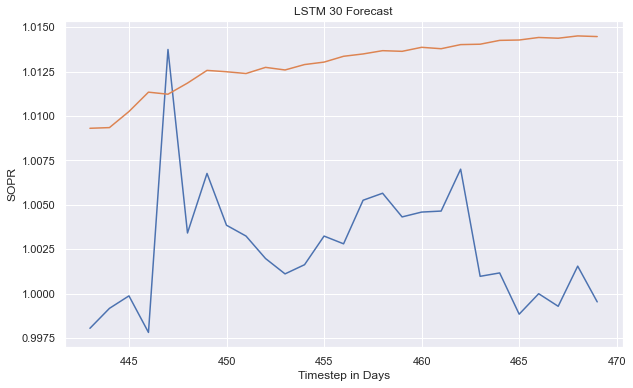

Text(0.5, 1.0, 'Mean Average Error of All Models Tested')

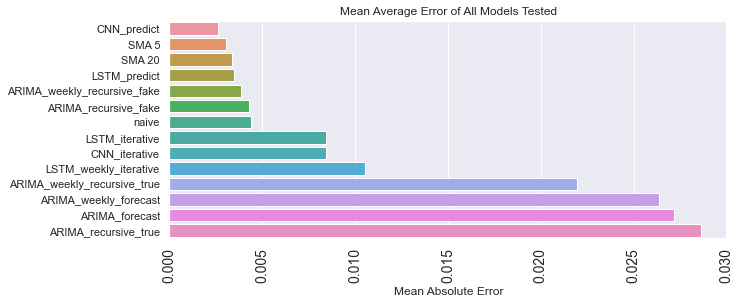

In [112]:
# recall best model
model = keras.models.load_model("my_checkpoint")
# make predictions
yhat = normalized_x_test[0]
yhat = yhat[np.newaxis, :]
rnn_forecast = []
for i in range(len(normalized_x_test)):
    print(yhat.shape)
    yhat = model.predict(yhat)
    print(yhat.shape)
    print(i, "fatto")
    rnn_forecast.append(yhat)
    
rnn_forecast = np.array(rnn_forecast)
# Example of how to iverse
rnn_unscaled_forecast = x_train_scaler.inverse_transform(rnn_forecast.reshape(-1,1)).flatten()
rnn_unscaled_forecast.shape

window_size = 30
# plot results
plt.figure(figsize=(10,6))

plt.ylabel('SOPR')
plt.xlabel('Timestep in Days')
plt.title(f'LSTM {window_size} Forecast')
plt.plot(x_test.index, x_test, label="Actual")
plt.plot(x_test.index, rnn_unscaled_forecast, label="Forecast")
plt.show()

# calculate MAE
lstm = mean_absolute_error(x_test, rnn_unscaled_forecast)

# Save to our dictionary of model mae scores
model_mae_scores_weekly['LSTM_weekly_iterative'] = lstm
model_mae_scores['LSTM_weekly_iterative'] = lstm
model_mae_scores



mae_series = pd.Series(model_mae_scores)
model_mae_scores

# Sort vales for clean bar chart
order = mae_series.sort_values()

# Create bar chart for to show MAE of all models side by side
sns.barplot(x=order.values, y = order.index, orient='h')
plt.xlabel('Mean Absolute Error')
plt.xticks(rotation='vertical',fontsize=14)
plt.title('Mean Average Error of All Models Tested')

1/1 [==============================] - 1s 1s/step


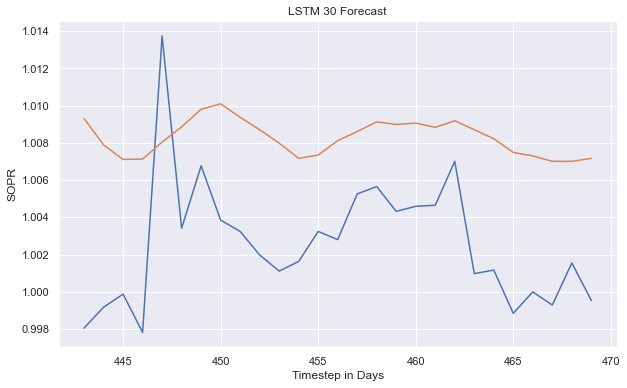

In [113]:
# recall best model
model = keras.models.load_model("my_checkpoint")
# make predictions
rnn_forecast = model.predict(normalized_x_test[np.newaxis,:])
rnn_forecast = rnn_forecast.flatten()
# Example of how to iverse
rnn_unscaled_forecast = x_train_scaler.inverse_transform(rnn_forecast.reshape(-1,1)).flatten()
rnn_unscaled_forecast.shape



window_size = 30
# plot results
plt.figure(figsize=(10,6))

plt.ylabel('SOPR')
plt.xlabel('Timestep in Days')
plt.title(f'LSTM {window_size} Forecast')
plt.plot(x_test.index, x_test, label="Actual")
plt.plot(x_test.index, rnn_unscaled_forecast, label="Forecast")
plt.show()

Text(0.5, 1.0, 'Mean Average Error of All Models Tested')

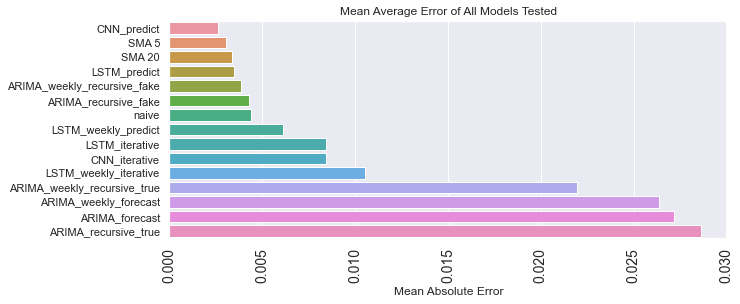

In [114]:
# calculate MAE
lstm = mean_absolute_error(x_test, rnn_unscaled_forecast)

# Save to our dictionary of model mae scores
model_mae_scores_weekly['LSTM_weekly_predict'] = lstm
model_mae_scores['LSTM_weekly_predict'] = lstm
model_mae_scores



mae_series = pd.Series(model_mae_scores)
model_mae_scores

# Sort vales for clean bar chart
order = mae_series.sort_values()

# Create bar chart for to show MAE of all models side by side
sns.barplot(x=order.values, y = order.index, orient='h')
plt.xlabel('Mean Absolute Error')
plt.xticks(rotation='vertical',fontsize=14)
plt.title('Mean Average Error of All Models Tested')


Epoch 1/100


/usr/local/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/nadam.py:86: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


4/4 [==============================] - 7s 43ms/step - loss: 0.0732 - mae: 0.3679 - lr: 1.0000e-04
Epoch 2/100
4/4 [==============================] - 0s 56ms/step - loss: 0.0719 - mae: 0.3645 - lr: 1.0798e-04
Epoch 3/100
4/4 [==============================] - 0s 36ms/step - loss: 0.0704 - mae: 0.3602 - lr: 1.1659e-04
Epoch 4/100
4/4 [==============================] - 0s 35ms/step - loss: 0.0683 - mae: 0.3544 - lr: 1.2589e-04
Epoch 5/100
4/4 [==============================] - 0s 33ms/step - loss: 0.0658 - mae: 0.3474 - lr: 1.3594e-04
Epoch 6/100
4/4 [==============================] - 0s 32ms/step - loss: 0.0628 - mae: 0.3388 - lr: 1.4678e-04
Epoch 7/100
4/4 [==============================] - 0s 34ms/step - loss: 0.0591 - mae: 0.3278 - lr: 1.5849e-04
Epoch 8/100
4/4 [==============================] - 0s 34ms/step - loss: 0.0548 - mae: 0.3144 - lr: 1.7113e-04
Epoch 9/100
4/4 [==============================] - 0s 38ms/step - loss: 0.0495 - mae: 0.2976 - lr: 1.8478e-04
Epoch 10/100
4/4 [====

4/4 [==============================] - 0s 26ms/step - loss: 0.0068 - mae: 0.0932 - lr: 0.0316
Epoch 77/100
4/4 [==============================] - 0s 39ms/step - loss: 0.0373 - mae: 0.2313 - lr: 0.0341
Epoch 78/100
4/4 [==============================] - 0s 32ms/step - loss: 0.0187 - mae: 0.1612 - lr: 0.0369
Epoch 79/100
4/4 [==============================] - 0s 40ms/step - loss: 0.0067 - mae: 0.0847 - lr: 0.0398
Epoch 80/100
4/4 [==============================] - 0s 31ms/step - loss: 0.0064 - mae: 0.0820 - lr: 0.0430
Epoch 81/100
4/4 [==============================] - 0s 36ms/step - loss: 0.0058 - mae: 0.0764 - lr: 0.0464
Epoch 82/100
4/4 [==============================] - 0s 34ms/step - loss: 0.0063 - mae: 0.0810 - lr: 0.0501
Epoch 83/100
4/4 [==============================] - 0s 49ms/step - loss: 0.0064 - mae: 0.0810 - lr: 0.0541
Epoch 84/100
4/4 [==============================] - 0s 33ms/step - loss: 0.0070 - mae: 0.0864 - lr: 0.0584
Epoch 85/100
4/4 [==============================] 

4/4 [==============================] - 8s 500ms/step - loss: 0.0536 - mae: 0.3036
Epoch 2/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0108 - mae: 0.1154WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 93ms/step - loss: 0.0107 - mae: 0.1152
Epoch 3/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0071 - mae: 0.0918WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 95ms/step - loss: 0.0070 - mae: 0.0916
Epoch 4/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0059 - mae: 0.0829WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 157ms/step - loss: 0.0059 - mae: 0.0826
Epoch 5/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0042 - mae: 0.0679WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 92ms/step - loss: 0.0042 - mae: 0.0677
Epoch 6/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0037 - mae: 0.0602WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 103ms/step - loss: 0.0037 - mae: 0.0603
Epoch 7/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0064 - mae: 0.0894WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 101ms/step - loss: 0.0063 - mae: 0.0892
Epoch 8/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0039 - mae: 0.0631WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 96ms/step - loss: 0.0039 - mae: 0.0632
Epoch 9/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0041 - mae: 0.0665WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 126ms/step - loss: 0.0041 - mae: 0.0666
Epoch 10/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0053 - mae: 0.0769WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 95ms/step - loss: 0.0053 - mae: 0.0769
Epoch 11/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0046 - mae: 0.0725WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 92ms/step - loss: 0.0046 - mae: 0.0726
Epoch 12/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0044 - mae: 0.0709WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 94ms/step - loss: 0.0044 - mae: 0.0710
Epoch 13/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0042 - mae: 0.0694WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 95ms/step - loss: 0.0042 - mae: 0.0693
Epoch 14/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0031 - mae: 0.0558WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 112ms/step - loss: 0.0031 - mae: 0.0558
Epoch 15/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0047 - mae: 0.0756WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 151ms/step - loss: 0.0046 - mae: 0.0755
Epoch 16/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0041 - mae: 0.0695WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 133ms/step - loss: 0.0041 - mae: 0.0693
Epoch 17/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0025 - mae: 0.0482WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 140ms/step - loss: 0.0025 - mae: 0.0481
Epoch 18/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0066 - mae: 0.0931WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 160ms/step - loss: 0.0066 - mae: 0.0927
Epoch 19/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0029 - mae: 0.0549WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 159ms/step - loss: 0.0029 - mae: 0.0549
Epoch 20/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0042 - mae: 0.0719WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 150ms/step - loss: 0.0042 - mae: 0.0717
Epoch 21/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0025 - mae: 0.0483WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 163ms/step - loss: 0.0025 - mae: 0.0482
Epoch 22/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0025 - mae: 0.0485WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 153ms/step - loss: 0.0024 - mae: 0.0483
Epoch 23/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0033 - mae: 0.0604WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 142ms/step - loss: 0.0033 - mae: 0.0603
Epoch 24/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0036 - mae: 0.0642WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 155ms/step - loss: 0.0036 - mae: 0.0642
Epoch 25/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0038 - mae: 0.0666WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 181ms/step - loss: 0.0038 - mae: 0.0665
Epoch 26/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0033 - mae: 0.0610WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 167ms/step - loss: 0.0033 - mae: 0.0611
Epoch 27/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0032 - mae: 0.0591WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 185ms/step - loss: 0.0032 - mae: 0.0591
Epoch 28/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0028 - mae: 0.0544WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 194ms/step - loss: 0.0028 - mae: 0.0542
Epoch 29/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0025 - mae: 0.0507WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 197ms/step - loss: 0.0025 - mae: 0.0507
Epoch 30/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0025 - mae: 0.0503WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 183ms/step - loss: 0.0025 - mae: 0.0503
Epoch 31/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0035 - mae: 0.0639WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 161ms/step - loss: 0.0035 - mae: 0.0638
Epoch 32/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0027 - mae: 0.0536WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 165ms/step - loss: 0.0027 - mae: 0.0535
Epoch 33/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0028 - mae: 0.0541WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 150ms/step - loss: 0.0028 - mae: 0.0541
Epoch 34/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0025 - mae: 0.0504WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 149ms/step - loss: 0.0025 - mae: 0.0503
Epoch 35/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0023 - mae: 0.0477WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 159ms/step - loss: 0.0023 - mae: 0.0477
Epoch 36/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0030 - mae: 0.0579WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 164ms/step - loss: 0.0030 - mae: 0.0579
Epoch 37/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0035 - mae: 0.0638WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 184ms/step - loss: 0.0035 - mae: 0.0639
Epoch 38/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0033 - mae: 0.0608WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 153ms/step - loss: 0.0032 - mae: 0.0606
Epoch 39/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0024 - mae: 0.0497WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 156ms/step - loss: 0.0025 - mae: 0.0498
Epoch 40/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0023 - mae: 0.0470WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 156ms/step - loss: 0.0023 - mae: 0.0472
Epoch 41/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0022 - mae: 0.0453WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 180ms/step - loss: 0.0022 - mae: 0.0454
Epoch 42/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0027 - mae: 0.0528WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 153ms/step - loss: 0.0027 - mae: 0.0528
Epoch 43/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0029 - mae: 0.0565WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 153ms/step - loss: 0.0029 - mae: 0.0565
Epoch 44/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0025 - mae: 0.0507WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 160ms/step - loss: 0.0025 - mae: 0.0506
Epoch 45/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0026 - mae: 0.0529WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 142ms/step - loss: 0.0026 - mae: 0.0528
Epoch 46/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0028 - mae: 0.0561WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 202ms/step - loss: 0.0028 - mae: 0.0559
Epoch 47/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0024 - mae: 0.0506WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 152ms/step - loss: 0.0024 - mae: 0.0507
Epoch 48/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0026 - mae: 0.0531WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 154ms/step - loss: 0.0026 - mae: 0.0530
Epoch 49/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0025 - mae: 0.0512WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 163ms/step - loss: 0.0025 - mae: 0.0512
Epoch 50/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0022 - mae: 0.0476WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 144ms/step - loss: 0.0022 - mae: 0.0476
Epoch 51/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0023 - mae: 0.0483WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 140ms/step - loss: 0.0023 - mae: 0.0483
Epoch 52/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0026 - mae: 0.0527WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 146ms/step - loss: 0.0026 - mae: 0.0526
Epoch 53/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0019 - mae: 0.0424WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 120ms/step - loss: 0.0019 - mae: 0.0424
Epoch 54/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0020 - mae: 0.0436WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 131ms/step - loss: 0.0020 - mae: 0.0437
Epoch 55/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0031 - mae: 0.0600WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 150ms/step - loss: 0.0031 - mae: 0.0599
Epoch 56/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0026 - mae: 0.0535WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 156ms/step - loss: 0.0026 - mae: 0.0534
Epoch 57/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0023 - mae: 0.0487WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 134ms/step - loss: 0.0024 - mae: 0.0489
Epoch 58/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0020 - mae: 0.0446WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 142ms/step - loss: 0.0020 - mae: 0.0446
Epoch 59/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0019 - mae: 0.0426WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 146ms/step - loss: 0.0019 - mae: 0.0426
Epoch 60/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0019 - mae: 0.0430WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 163ms/step - loss: 0.0019 - mae: 0.0430
Epoch 61/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0018 - mae: 0.0415WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 154ms/step - loss: 0.0018 - mae: 0.0415
Epoch 62/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0020 - mae: 0.0448WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 166ms/step - loss: 0.0020 - mae: 0.0448
Epoch 63/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0049 - mae: 0.0791WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 143ms/step - loss: 0.0049 - mae: 0.0788
Epoch 64/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0030 - mae: 0.0596WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 149ms/step - loss: 0.0030 - mae: 0.0594
Epoch 65/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0019 - mae: 0.0435WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 166ms/step - loss: 0.0019 - mae: 0.0435
Epoch 66/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0019 - mae: 0.0435WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 164ms/step - loss: 0.0019 - mae: 0.0434
Epoch 67/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0019 - mae: 0.0439WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 163ms/step - loss: 0.0019 - mae: 0.0439
Epoch 68/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0017 - mae: 0.0409WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 139ms/step - loss: 0.0017 - mae: 0.0410
Epoch 69/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0019 - mae: 0.0443WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 157ms/step - loss: 0.0019 - mae: 0.0444
Epoch 70/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0022 - mae: 0.0490WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 168ms/step - loss: 0.0022 - mae: 0.0490
Epoch 71/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0022 - mae: 0.0489WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 164ms/step - loss: 0.0022 - mae: 0.0489
Epoch 72/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0020 - mae: 0.0465WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 184ms/step - loss: 0.0020 - mae: 0.0465
Epoch 73/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0018 - mae: 0.0416WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 137ms/step - loss: 0.0018 - mae: 0.0415
Epoch 74/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0016 - mae: 0.0378WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 146ms/step - loss: 0.0016 - mae: 0.0379
Epoch 75/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0021 - mae: 0.0473WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 119ms/step - loss: 0.0021 - mae: 0.0473
Epoch 76/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0022 - mae: 0.0489WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 129ms/step - loss: 0.0022 - mae: 0.0488
Epoch 77/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0019 - mae: 0.0447WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 130ms/step - loss: 0.0019 - mae: 0.0447
Epoch 78/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0016 - mae: 0.0397WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 145ms/step - loss: 0.0016 - mae: 0.0397
Epoch 79/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0016 - mae: 0.0389WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 164ms/step - loss: 0.0016 - mae: 0.0388
Epoch 80/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0015 - mae: 0.0382WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 159ms/step - loss: 0.0015 - mae: 0.0381
Epoch 81/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0014 - mae: 0.0360WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 138ms/step - loss: 0.0014 - mae: 0.0361
Epoch 82/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0016 - mae: 0.0405WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 140ms/step - loss: 0.0016 - mae: 0.0405
Epoch 83/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0033 - mae: 0.0623WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 128ms/step - loss: 0.0033 - mae: 0.0623
Epoch 84/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0019 - mae: 0.0435WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 140ms/step - loss: 0.0019 - mae: 0.0434
Epoch 85/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0016 - mae: 0.0402WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 137ms/step - loss: 0.0016 - mae: 0.0403
Epoch 86/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0022 - mae: 0.0494WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 167ms/step - loss: 0.0022 - mae: 0.0495
Epoch 87/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0030 - mae: 0.0594WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 135ms/step - loss: 0.0029 - mae: 0.0594
Epoch 88/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0022 - mae: 0.0478WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 158ms/step - loss: 0.0022 - mae: 0.0476
Epoch 89/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0018 - mae: 0.0420WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 141ms/step - loss: 0.0018 - mae: 0.0420
Epoch 90/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0014 - mae: 0.0367WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 134ms/step - loss: 0.0014 - mae: 0.0367
Epoch 91/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0014 - mae: 0.0365WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 129ms/step - loss: 0.0014 - mae: 0.0365
Epoch 92/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0013 - mae: 0.0347WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 138ms/step - loss: 0.0013 - mae: 0.0347
Epoch 93/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0013 - mae: 0.0339WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 163ms/step - loss: 0.0013 - mae: 0.0339
Epoch 94/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0013 - mae: 0.0337WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 143ms/step - loss: 0.0013 - mae: 0.0338
Epoch 95/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0014 - mae: 0.0365WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 136ms/step - loss: 0.0014 - mae: 0.0365
Epoch 96/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0024 - mae: 0.0531WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 122ms/step - loss: 0.0024 - mae: 0.0531
Epoch 97/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0020 - mae: 0.0467WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 150ms/step - loss: 0.0020 - mae: 0.0466
Epoch 98/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0012 - mae: 0.0333WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 128ms/step - loss: 0.0012 - mae: 0.0334
Epoch 99/500
4/4 [==============================] - ETA: 0s - loss: 0.0015 - mae: 0.0382WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 193ms/step - loss: 0.0015 - mae: 0.0382
Epoch 100/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0023 - mae: 0.0520WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 201ms/step - loss: 0.0023 - mae: 0.0520
Epoch 101/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0021 - mae: 0.0484WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 131ms/step - loss: 0.0021 - mae: 0.0482
Epoch 102/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0012 - mae: 0.0339WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 149ms/step - loss: 0.0012 - mae: 0.0338
Epoch 103/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0012 - mae: 0.0323WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 171ms/step - loss: 0.0012 - mae: 0.0323
Epoch 104/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0012 - mae: 0.0336WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 141ms/step - loss: 0.0012 - mae: 0.0336
Epoch 105/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0013 - mae: 0.0342WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 124ms/step - loss: 0.0013 - mae: 0.0342
Epoch 106/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0013 - mae: 0.0364WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 154ms/step - loss: 0.0013 - mae: 0.0364
Epoch 107/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0015 - mae: 0.0376WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 137ms/step - loss: 0.0015 - mae: 0.0376
Epoch 108/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0015 - mae: 0.0388WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 144ms/step - loss: 0.0015 - mae: 0.0390
Epoch 109/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0024 - mae: 0.0529WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 166ms/step - loss: 0.0024 - mae: 0.0527
Epoch 110/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0013 - mae: 0.0362WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 181ms/step - loss: 0.0013 - mae: 0.0362
Epoch 111/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0011 - mae: 0.0318WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 137ms/step - loss: 0.0011 - mae: 0.0319
Epoch 112/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0012 - mae: 0.0332WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 164ms/step - loss: 0.0012 - mae: 0.0332
Epoch 113/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0013 - mae: 0.0355WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 155ms/step - loss: 0.0013 - mae: 0.0356
Epoch 114/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0050 - mae: 0.0752WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 158ms/step - loss: 0.0050 - mae: 0.0749
Epoch 115/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0022 - mae: 0.0479WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 155ms/step - loss: 0.0022 - mae: 0.0478
Epoch 116/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0013 - mae: 0.0354WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 158ms/step - loss: 0.0013 - mae: 0.0354
Epoch 117/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0012 - mae: 0.0338WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 153ms/step - loss: 0.0013 - mae: 0.0338
Epoch 118/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0012 - mae: 0.0326WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 175ms/step - loss: 0.0012 - mae: 0.0326
Epoch 119/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0014 - mae: 0.0371WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 166ms/step - loss: 0.0014 - mae: 0.0371
Epoch 120/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0015 - mae: 0.0406WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 161ms/step - loss: 0.0015 - mae: 0.0405
Epoch 121/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0013 - mae: 0.0353WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 149ms/step - loss: 0.0013 - mae: 0.0353
Epoch 122/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0012 - mae: 0.0334WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 148ms/step - loss: 0.0012 - mae: 0.0334
Epoch 123/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0011 - mae: 0.0314WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 131ms/step - loss: 0.0011 - mae: 0.0314
Epoch 124/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0011 - mae: 0.0324WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 146ms/step - loss: 0.0011 - mae: 0.0324
Epoch 125/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0011 - mae: 0.0333WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 152ms/step - loss: 0.0011 - mae: 0.0333
Epoch 126/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0011 - mae: 0.0322WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 143ms/step - loss: 0.0011 - mae: 0.0321
Epoch 127/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0012 - mae: 0.0347WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 143ms/step - loss: 0.0012 - mae: 0.0347
Epoch 128/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0011 - mae: 0.0317WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 141ms/step - loss: 0.0011 - mae: 0.0316
Epoch 129/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0010 - mae: 0.0311   WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 135ms/step - loss: 0.0010 - mae: 0.0311
Epoch 130/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0013 - mae: 0.0358WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 139ms/step - loss: 0.0013 - mae: 0.0359
Epoch 131/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0016 - mae: 0.0399WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 138ms/step - loss: 0.0016 - mae: 0.0398
Epoch 132/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0012 - mae: 0.0344WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 151ms/step - loss: 0.0012 - mae: 0.0343
Epoch 133/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0011 - mae: 0.0334WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 137ms/step - loss: 0.0011 - mae: 0.0334
Epoch 134/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0011 - mae: 0.0318WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 138ms/step - loss: 0.0011 - mae: 0.0318
Epoch 135/500
3/4 [=====================>........] - ETA: 0s - loss: 9.8253e-04 - mae: 0.0296WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 140ms/step - loss: 9.8128e-04 - mae: 0.0296
Epoch 136/500
3/4 [=====================>........] - ETA: 0s - loss: 9.3755e-04 - mae: 0.0284WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 139ms/step - loss: 9.3334e-04 - mae: 0.0283
Epoch 137/500
3/4 [=====================>........] - ETA: 0s - loss: 9.1240e-04 - mae: 0.0281WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 150ms/step - loss: 9.1405e-04 - mae: 0.0281
Epoch 138/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0011 - mae: 0.0331WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 124ms/step - loss: 0.0011 - mae: 0.0332
Epoch 139/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0015 - mae: 0.0409WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 131ms/step - loss: 0.0015 - mae: 0.0409
Epoch 140/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0014 - mae: 0.0376WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 143ms/step - loss: 0.0014 - mae: 0.0376
Epoch 141/500
3/4 [=====================>........] - ETA: 0s - loss: 8.8741e-04 - mae: 0.0280WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 135ms/step - loss: 8.8600e-04 - mae: 0.0280
Epoch 142/500
3/4 [=====================>........] - ETA: 0s - loss: 8.6881e-04 - mae: 0.0276WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 130ms/step - loss: 8.6419e-04 - mae: 0.0275
Epoch 143/500
3/4 [=====================>........] - ETA: 0s - loss: 8.5636e-04 - mae: 0.0272WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 145ms/step - loss: 8.5291e-04 - mae: 0.0271
Epoch 144/500
3/4 [=====================>........] - ETA: 0s - loss: 8.6419e-04 - mae: 0.0278WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 159ms/step - loss: 8.6445e-04 - mae: 0.0278
Epoch 145/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0012 - mae: 0.0368WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 128ms/step - loss: 0.0012 - mae: 0.0368
Epoch 146/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0015 - mae: 0.0412WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 130ms/step - loss: 0.0015 - mae: 0.0411
Epoch 147/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0012 - mae: 0.0358WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 131ms/step - loss: 0.0012 - mae: 0.0358
Epoch 148/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0010 - mae: 0.0316WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 134ms/step - loss: 0.0010 - mae: 0.0315
Epoch 149/500
3/4 [=====================>........] - ETA: 0s - loss: 9.1090e-04 - mae: 0.0289WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 134ms/step - loss: 9.0807e-04 - mae: 0.0289
Epoch 150/500
3/4 [=====================>........] - ETA: 0s - loss: 9.4676e-04 - mae: 0.0291WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 137ms/step - loss: 9.4283e-04 - mae: 0.0290
Epoch 151/500
3/4 [=====================>........] - ETA: 0s - loss: 8.7228e-04 - mae: 0.0283WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 132ms/step - loss: 8.7500e-04 - mae: 0.0283
Epoch 152/500
3/4 [=====================>........] - ETA: 0s - loss: 8.7935e-04 - mae: 0.0276WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 152ms/step - loss: 8.7988e-04 - mae: 0.0277
Epoch 153/500
3/4 [=====================>........] - ETA: 0s - loss: 8.9816e-04 - mae: 0.0283WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 137ms/step - loss: 8.9336e-04 - mae: 0.0283
Epoch 154/500
3/4 [=====================>........] - ETA: 0s - loss: 8.3862e-04 - mae: 0.0268WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 136ms/step - loss: 8.4050e-04 - mae: 0.0268
Epoch 155/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0011 - mae: 0.0330   WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 128ms/step - loss: 0.0011 - mae: 0.0331
Epoch 156/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0014 - mae: 0.0392WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 145ms/step - loss: 0.0014 - mae: 0.0392
Epoch 157/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0017 - mae: 0.0427WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 150ms/step - loss: 0.0017 - mae: 0.0426
Epoch 158/500
3/4 [=====================>........] - ETA: 0s - loss: 9.2790e-04 - mae: 0.0286WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 133ms/step - loss: 9.2510e-04 - mae: 0.0286
Epoch 159/500
3/4 [=====================>........] - ETA: 0s - loss: 7.5826e-04 - mae: 0.0249WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 145ms/step - loss: 7.5800e-04 - mae: 0.0249
Epoch 160/500
3/4 [=====================>........] - ETA: 0s - loss: 8.5767e-04 - mae: 0.0274WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 158ms/step - loss: 8.5828e-04 - mae: 0.0274
Epoch 161/500
3/4 [=====================>........] - ETA: 0s - loss: 7.7800e-04 - mae: 0.0254WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 169ms/step - loss: 7.7538e-04 - mae: 0.0254
Epoch 162/500
3/4 [=====================>........] - ETA: 0s - loss: 7.4719e-04 - mae: 0.0248WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 178ms/step - loss: 7.4819e-04 - mae: 0.0248
Epoch 163/500
3/4 [=====================>........] - ETA: 0s - loss: 8.7515e-04 - mae: 0.0279WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 144ms/step - loss: 8.7152e-04 - mae: 0.0279
Epoch 164/500
3/4 [=====================>........] - ETA: 0s - loss: 9.0257e-04 - mae: 0.0297WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 171ms/step - loss: 9.0219e-04 - mae: 0.0297
Epoch 165/500
3/4 [=====================>........] - ETA: 0s - loss: 9.5403e-04 - mae: 0.0301WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 139ms/step - loss: 9.5699e-04 - mae: 0.0301
Epoch 166/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0011 - mae: 0.0325WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 131ms/step - loss: 0.0011 - mae: 0.0324
Epoch 167/500
3/4 [=====================>........] - ETA: 0s - loss: 8.7618e-04 - mae: 0.0286WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 131ms/step - loss: 8.7435e-04 - mae: 0.0286
Epoch 168/500
3/4 [=====================>........] - ETA: 0s - loss: 8.7535e-04 - mae: 0.0283WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 176ms/step - loss: 8.7464e-04 - mae: 0.0283
Epoch 169/500
3/4 [=====================>........] - ETA: 0s - loss: 9.3152e-04 - mae: 0.0296WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 124ms/step - loss: 9.3607e-04 - mae: 0.0296
Epoch 170/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0012 - mae: 0.0358WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 168ms/step - loss: 0.0012 - mae: 0.0357
Epoch 171/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0011 - mae: 0.0332WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 182ms/step - loss: 0.0011 - mae: 0.0332
Epoch 172/500
3/4 [=====================>........] - ETA: 0s - loss: 9.3745e-04 - mae: 0.0297WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 144ms/step - loss: 9.3596e-04 - mae: 0.0296
Epoch 173/500
3/4 [=====================>........] - ETA: 0s - loss: 8.7706e-04 - mae: 0.0281WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 153ms/step - loss: 8.7641e-04 - mae: 0.0281
Epoch 174/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0012 - mae: 0.0359WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 147ms/step - loss: 0.0012 - mae: 0.0359
Epoch 175/500
3/4 [=====================>........] - ETA: 0s - loss: 8.7491e-04 - mae: 0.0283WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 126ms/step - loss: 8.7771e-04 - mae: 0.0283
Epoch 176/500
3/4 [=====================>........] - ETA: 0s - loss: 8.7068e-04 - mae: 0.0284WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 146ms/step - loss: 8.6930e-04 - mae: 0.0284
Epoch 177/500
3/4 [=====================>........] - ETA: 0s - loss: 7.3090e-04 - mae: 0.0249WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 161ms/step - loss: 7.3263e-04 - mae: 0.0249
Epoch 178/500
3/4 [=====================>........] - ETA: 0s - loss: 7.0281e-04 - mae: 0.0237WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 142ms/step - loss: 6.9996e-04 - mae: 0.0237
Epoch 179/500
3/4 [=====================>........] - ETA: 0s - loss: 7.3774e-04 - mae: 0.0256WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 128ms/step - loss: 7.3545e-04 - mae: 0.0256
Epoch 180/500
3/4 [=====================>........] - ETA: 0s - loss: 7.4470e-04 - mae: 0.0255WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 138ms/step - loss: 7.4646e-04 - mae: 0.0256
Epoch 181/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0010 - mae: 0.0324    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 137ms/step - loss: 0.0010 - mae: 0.0323
Epoch 182/500
3/4 [=====================>........] - ETA: 0s - loss: 7.2735e-04 - mae: 0.0249WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 148ms/step - loss: 7.2599e-04 - mae: 0.0249
Epoch 183/500
3/4 [=====================>........] - ETA: 0s - loss: 7.1332e-04 - mae: 0.0242WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 140ms/step - loss: 7.1391e-04 - mae: 0.0243
Epoch 184/500
3/4 [=====================>........] - ETA: 0s - loss: 7.2184e-04 - mae: 0.0243WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 140ms/step - loss: 7.2351e-04 - mae: 0.0244
Epoch 185/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0011 - mae: 0.0323WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 148ms/step - loss: 0.0011 - mae: 0.0323
Epoch 186/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0012 - mae: 0.0350WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 131ms/step - loss: 0.0012 - mae: 0.0349
Epoch 187/500
3/4 [=====================>........] - ETA: 0s - loss: 7.2777e-04 - mae: 0.0247WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 150ms/step - loss: 7.2630e-04 - mae: 0.0247
Epoch 188/500
3/4 [=====================>........] - ETA: 0s - loss: 6.5384e-04 - mae: 0.0227WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 131ms/step - loss: 6.5625e-04 - mae: 0.0227
Epoch 189/500
3/4 [=====================>........] - ETA: 0s - loss: 6.8423e-04 - mae: 0.0242WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 137ms/step - loss: 6.8683e-04 - mae: 0.0242
Epoch 190/500
3/4 [=====================>........] - ETA: 0s - loss: 9.7720e-04 - mae: 0.0313WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 131ms/step - loss: 9.7446e-04 - mae: 0.0312
Epoch 191/500
3/4 [=====================>........] - ETA: 0s - loss: 8.4899e-04 - mae: 0.0290WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 142ms/step - loss: 8.4845e-04 - mae: 0.0290
Epoch 192/500
3/4 [=====================>........] - ETA: 0s - loss: 7.0062e-04 - mae: 0.0246WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 163ms/step - loss: 7.0540e-04 - mae: 0.0247
Epoch 193/500
3/4 [=====================>........] - ETA: 0s - loss: 8.0707e-04 - mae: 0.0272WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 143ms/step - loss: 8.0515e-04 - mae: 0.0271
Epoch 194/500
3/4 [=====================>........] - ETA: 0s - loss: 8.0922e-04 - mae: 0.0279WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 129ms/step - loss: 8.0672e-04 - mae: 0.0278
Epoch 195/500
3/4 [=====================>........] - ETA: 0s - loss: 6.5639e-04 - mae: 0.0231WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 128ms/step - loss: 6.5643e-04 - mae: 0.0231
Epoch 196/500
3/4 [=====================>........] - ETA: 0s - loss: 8.2608e-04 - mae: 0.0275WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 124ms/step - loss: 8.2591e-04 - mae: 0.0275
Epoch 197/500
3/4 [=====================>........] - ETA: 0s - loss: 8.7153e-04 - mae: 0.0283WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 131ms/step - loss: 8.6944e-04 - mae: 0.0283
Epoch 198/500
3/4 [=====================>........] - ETA: 0s - loss: 9.4462e-04 - mae: 0.0310WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 141ms/step - loss: 9.4167e-04 - mae: 0.0310
Epoch 199/500
3/4 [=====================>........] - ETA: 0s - loss: 7.4350e-04 - mae: 0.0265WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 143ms/step - loss: 7.5018e-04 - mae: 0.0265
Epoch 200/500
3/4 [=====================>........] - ETA: 0s - loss: 7.3256e-04 - mae: 0.0241WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 138ms/step - loss: 7.2884e-04 - mae: 0.0240
Epoch 201/500
3/4 [=====================>........] - ETA: 0s - loss: 6.0848e-04 - mae: 0.0215WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 126ms/step - loss: 6.1178e-04 - mae: 0.0215
Epoch 202/500
3/4 [=====================>........] - ETA: 0s - loss: 7.3358e-04 - mae: 0.0240WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 129ms/step - loss: 7.3549e-04 - mae: 0.0240
Epoch 203/500
3/4 [=====================>........] - ETA: 0s - loss: 5.9883e-04 - mae: 0.0212WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 136ms/step - loss: 5.9637e-04 - mae: 0.0212
Epoch 204/500
3/4 [=====================>........] - ETA: 0s - loss: 6.0605e-04 - mae: 0.0214WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 154ms/step - loss: 6.0482e-04 - mae: 0.0214
Epoch 205/500
3/4 [=====================>........] - ETA: 0s - loss: 6.2163e-04 - mae: 0.0217WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 155ms/step - loss: 6.2200e-04 - mae: 0.0217
Epoch 206/500
3/4 [=====================>........] - ETA: 0s - loss: 6.6103e-04 - mae: 0.0230WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 149ms/step - loss: 6.5942e-04 - mae: 0.0230
Epoch 207/500
3/4 [=====================>........] - ETA: 0s - loss: 7.8300e-04 - mae: 0.0274WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 133ms/step - loss: 7.8239e-04 - mae: 0.0274
Epoch 208/500
3/4 [=====================>........] - ETA: 0s - loss: 9.7671e-04 - mae: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 143ms/step - loss: 9.7653e-04 - mae: 0.0311
Epoch 209/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0018 - mae: 0.0450WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 136ms/step - loss: 0.0018 - mae: 0.0450
Epoch 210/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0016 - mae: 0.0420WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 159ms/step - loss: 0.0016 - mae: 0.0419
Epoch 211/500
3/4 [=====================>........] - ETA: 0s - loss: 6.7118e-04 - mae: 0.0237WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 139ms/step - loss: 6.6746e-04 - mae: 0.0236
Epoch 212/500
3/4 [=====================>........] - ETA: 0s - loss: 6.1698e-04 - mae: 0.0223WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 156ms/step - loss: 6.1797e-04 - mae: 0.0223
Epoch 213/500
3/4 [=====================>........] - ETA: 0s - loss: 9.3054e-04 - mae: 0.0299WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 130ms/step - loss: 9.2360e-04 - mae: 0.0298
Epoch 214/500
3/4 [=====================>........] - ETA: 0s - loss: 6.4285e-04 - mae: 0.0226WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 127ms/step - loss: 6.3933e-04 - mae: 0.0225
Epoch 215/500
3/4 [=====================>........] - ETA: 0s - loss: 5.5627e-04 - mae: 0.0200WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 131ms/step - loss: 5.5607e-04 - mae: 0.0200
Epoch 216/500
3/4 [=====================>........] - ETA: 0s - loss: 6.5333e-04 - mae: 0.0226WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 145ms/step - loss: 6.4992e-04 - mae: 0.0226
Epoch 217/500
3/4 [=====================>........] - ETA: 0s - loss: 5.6269e-04 - mae: 0.0201WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 96ms/step - loss: 5.6157e-04 - mae: 0.0200
Epoch 218/500
3/4 [=====================>........] - ETA: 0s - loss: 5.6170e-04 - mae: 0.0204WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 94ms/step - loss: 5.6285e-04 - mae: 0.0204
Epoch 219/500
3/4 [=====================>........] - ETA: 0s - loss: 6.4065e-04 - mae: 0.0227WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 104ms/step - loss: 6.3742e-04 - mae: 0.0227
Epoch 220/500
3/4 [=====================>........] - ETA: 0s - loss: 5.2769e-04 - mae: 0.0190WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 144ms/step - loss: 5.2990e-04 - mae: 0.0190
Epoch 221/500
3/4 [=====================>........] - ETA: 0s - loss: 6.1117e-04 - mae: 0.0216WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 133ms/step - loss: 6.1228e-04 - mae: 0.0216
Epoch 222/500
3/4 [=====================>........] - ETA: 0s - loss: 6.2344e-04 - mae: 0.0221WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 156ms/step - loss: 6.2330e-04 - mae: 0.0221
Epoch 223/500
3/4 [=====================>........] - ETA: 0s - loss: 6.0041e-04 - mae: 0.0220WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 146ms/step - loss: 6.0157e-04 - mae: 0.0220
Epoch 224/500
3/4 [=====================>........] - ETA: 0s - loss: 6.1990e-04 - mae: 0.0223WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 108ms/step - loss: 6.1943e-04 - mae: 0.0223
Epoch 225/500
3/4 [=====================>........] - ETA: 0s - loss: 5.6308e-04 - mae: 0.0204WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 126ms/step - loss: 5.6079e-04 - mae: 0.0204
Epoch 226/500
3/4 [=====================>........] - ETA: 0s - loss: 5.2047e-04 - mae: 0.0189WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 191ms/step - loss: 5.1994e-04 - mae: 0.0189
Epoch 227/500
3/4 [=====================>........] - ETA: 0s - loss: 6.1004e-04 - mae: 0.0219WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 148ms/step - loss: 6.1207e-04 - mae: 0.0219
Epoch 228/500
3/4 [=====================>........] - ETA: 0s - loss: 6.9124e-04 - mae: 0.0242WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 150ms/step - loss: 6.9114e-04 - mae: 0.0243
Epoch 229/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0010 - mae: 0.0324WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 155ms/step - loss: 0.0010 - mae: 0.0324
Epoch 230/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0010 - mae: 0.0314WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 178ms/step - loss: 9.9416e-04 - mae: 0.0313
Epoch 231/500
3/4 [=====================>........] - ETA: 0s - loss: 5.6817e-04 - mae: 0.0201WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 148ms/step - loss: 5.7303e-04 - mae: 0.0201
Epoch 232/500
3/4 [=====================>........] - ETA: 0s - loss: 6.3292e-04 - mae: 0.0222WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 150ms/step - loss: 6.3122e-04 - mae: 0.0222
Epoch 233/500
3/4 [=====================>........] - ETA: 0s - loss: 5.2018e-04 - mae: 0.0188WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 148ms/step - loss: 5.1855e-04 - mae: 0.0187
Epoch 234/500
3/4 [=====================>........] - ETA: 0s - loss: 5.2721e-04 - mae: 0.0192WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 187ms/step - loss: 5.2561e-04 - mae: 0.0192
Epoch 235/500
3/4 [=====================>........] - ETA: 0s - loss: 5.0847e-04 - mae: 0.0185WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 165ms/step - loss: 5.0650e-04 - mae: 0.0184
Epoch 236/500
3/4 [=====================>........] - ETA: 0s - loss: 5.1139e-04 - mae: 0.0189WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 153ms/step - loss: 5.1506e-04 - mae: 0.0190
Epoch 237/500
3/4 [=====================>........] - ETA: 0s - loss: 6.7665e-04 - mae: 0.0228WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 154ms/step - loss: 6.7873e-04 - mae: 0.0229
Epoch 238/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0026 - mae: 0.0539WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 166ms/step - loss: 0.0026 - mae: 0.0536
Epoch 239/500
3/4 [=====================>........] - ETA: 0s - loss: 8.9400e-04 - mae: 0.0273WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 135ms/step - loss: 8.9560e-04 - mae: 0.0272
Epoch 240/500
3/4 [=====================>........] - ETA: 0s - loss: 6.1285e-04 - mae: 0.0219WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 132ms/step - loss: 6.1053e-04 - mae: 0.0219
Epoch 241/500
3/4 [=====================>........] - ETA: 0s - loss: 5.6372e-04 - mae: 0.0204WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 139ms/step - loss: 5.6306e-04 - mae: 0.0204
Epoch 242/500
3/4 [=====================>........] - ETA: 0s - loss: 5.1796e-04 - mae: 0.0188WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 149ms/step - loss: 5.1607e-04 - mae: 0.0188
Epoch 243/500
3/4 [=====================>........] - ETA: 0s - loss: 5.0271e-04 - mae: 0.0183WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 166ms/step - loss: 5.0135e-04 - mae: 0.0183
Epoch 244/500
3/4 [=====================>........] - ETA: 0s - loss: 4.9193e-04 - mae: 0.0178WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 137ms/step - loss: 4.9136e-04 - mae: 0.0178
Epoch 245/500
3/4 [=====================>........] - ETA: 0s - loss: 4.9548e-04 - mae: 0.0182WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 137ms/step - loss: 4.9399e-04 - mae: 0.0182
Epoch 246/500
3/4 [=====================>........] - ETA: 0s - loss: 4.8475e-04 - mae: 0.0177WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 120ms/step - loss: 4.8276e-04 - mae: 0.0177
Epoch 247/500
3/4 [=====================>........] - ETA: 0s - loss: 4.9214e-04 - mae: 0.0181WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 218ms/step - loss: 4.9137e-04 - mae: 0.0181
Epoch 248/500
3/4 [=====================>........] - ETA: 0s - loss: 5.0079e-04 - mae: 0.0186WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 139ms/step - loss: 5.0106e-04 - mae: 0.0186
Epoch 249/500
3/4 [=====================>........] - ETA: 0s - loss: 5.0718e-04 - mae: 0.0188WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 141ms/step - loss: 5.1023e-04 - mae: 0.0188
Epoch 250/500
3/4 [=====================>........] - ETA: 0s - loss: 4.7833e-04 - mae: 0.0176WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 141ms/step - loss: 4.7786e-04 - mae: 0.0176
Epoch 251/500
3/4 [=====================>........] - ETA: 0s - loss: 6.4174e-04 - mae: 0.0243WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 147ms/step - loss: 6.4524e-04 - mae: 0.0243
Epoch 252/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0025 - mae: 0.0534WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 141ms/step - loss: 0.0024 - mae: 0.0532
Epoch 253/500
3/4 [=====================>........] - ETA: 0s - loss: 7.9408e-04 - mae: 0.0268WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 128ms/step - loss: 7.9242e-04 - mae: 0.0268
Epoch 254/500
3/4 [=====================>........] - ETA: 0s - loss: 5.7646e-04 - mae: 0.0214WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 145ms/step - loss: 5.7439e-04 - mae: 0.0213
Epoch 255/500
3/4 [=====================>........] - ETA: 0s - loss: 5.0250e-04 - mae: 0.0185WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 128ms/step - loss: 5.0093e-04 - mae: 0.0184
Epoch 256/500
3/4 [=====================>........] - ETA: 0s - loss: 4.9673e-04 - mae: 0.0183WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 137ms/step - loss: 4.9773e-04 - mae: 0.0183
Epoch 257/500
3/4 [=====================>........] - ETA: 0s - loss: 5.1583e-04 - mae: 0.0188WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 147ms/step - loss: 5.1589e-04 - mae: 0.0188
Epoch 258/500
3/4 [=====================>........] - ETA: 0s - loss: 4.8710e-04 - mae: 0.0182WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 148ms/step - loss: 4.8846e-04 - mae: 0.0182
Epoch 259/500
3/4 [=====================>........] - ETA: 0s - loss: 4.7176e-04 - mae: 0.0177WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 157ms/step - loss: 4.7537e-04 - mae: 0.0178
Epoch 260/500
3/4 [=====================>........] - ETA: 0s - loss: 8.0809e-04 - mae: 0.0289WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 154ms/step - loss: 8.0618e-04 - mae: 0.0288
Epoch 261/500
3/4 [=====================>........] - ETA: 0s - loss: 5.0757e-04 - mae: 0.0191WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 157ms/step - loss: 5.0517e-04 - mae: 0.0191
Epoch 262/500
3/4 [=====================>........] - ETA: 0s - loss: 5.0467e-04 - mae: 0.0188WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 128ms/step - loss: 5.0323e-04 - mae: 0.0188
Epoch 263/500
3/4 [=====================>........] - ETA: 0s - loss: 4.6124e-04 - mae: 0.0174WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 136ms/step - loss: 4.6503e-04 - mae: 0.0174
Epoch 264/500
3/4 [=====================>........] - ETA: 0s - loss: 4.9774e-04 - mae: 0.0189WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 130ms/step - loss: 4.9962e-04 - mae: 0.0188
Epoch 265/500
3/4 [=====================>........] - ETA: 0s - loss: 6.7473e-04 - mae: 0.0248WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 135ms/step - loss: 6.7373e-04 - mae: 0.0248
Epoch 266/500
3/4 [=====================>........] - ETA: 0s - loss: 7.8980e-04 - mae: 0.0272WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 145ms/step - loss: 7.8769e-04 - mae: 0.0272
Epoch 267/500
3/4 [=====================>........] - ETA: 0s - loss: 7.7955e-04 - mae: 0.0283WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 141ms/step - loss: 7.8088e-04 - mae: 0.0283
Epoch 268/500
3/4 [=====================>........] - ETA: 0s - loss: 6.0104e-04 - mae: 0.0217WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 151ms/step - loss: 6.0464e-04 - mae: 0.0217
Epoch 269/500
3/4 [=====================>........] - ETA: 0s - loss: 5.1477e-04 - mae: 0.0184WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 131ms/step - loss: 5.1439e-04 - mae: 0.0184
Epoch 270/500
3/4 [=====================>........] - ETA: 0s - loss: 5.3640e-04 - mae: 0.0198WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 158ms/step - loss: 5.3492e-04 - mae: 0.0198
Epoch 271/500
3/4 [=====================>........] - ETA: 0s - loss: 5.9952e-04 - mae: 0.0214WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 135ms/step - loss: 6.0041e-04 - mae: 0.0213
Epoch 272/500
3/4 [=====================>........] - ETA: 0s - loss: 5.3298e-04 - mae: 0.0195WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 150ms/step - loss: 5.3074e-04 - mae: 0.0195
Epoch 273/500
3/4 [=====================>........] - ETA: 0s - loss: 4.5748e-04 - mae: 0.0166WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 139ms/step - loss: 4.5464e-04 - mae: 0.0166
Epoch 274/500
3/4 [=====================>........] - ETA: 0s - loss: 4.4963e-04 - mae: 0.0166WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 173ms/step - loss: 4.4959e-04 - mae: 0.0166
Epoch 275/500
3/4 [=====================>........] - ETA: 0s - loss: 4.3928e-04 - mae: 0.0164WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 160ms/step - loss: 4.3984e-04 - mae: 0.0164
Epoch 276/500
3/4 [=====================>........] - ETA: 0s - loss: 4.9497e-04 - mae: 0.0189WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 133ms/step - loss: 4.9208e-04 - mae: 0.0188
Epoch 277/500
3/4 [=====================>........] - ETA: 0s - loss: 4.6143e-04 - mae: 0.0176WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 206ms/step - loss: 4.6233e-04 - mae: 0.0177
Epoch 278/500
3/4 [=====================>........] - ETA: 0s - loss: 4.6029e-04 - mae: 0.0175WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 177ms/step - loss: 4.5977e-04 - mae: 0.0175
Epoch 279/500
3/4 [=====================>........] - ETA: 0s - loss: 4.8203e-04 - mae: 0.0183WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 159ms/step - loss: 4.8034e-04 - mae: 0.0183
Epoch 280/500
3/4 [=====================>........] - ETA: 0s - loss: 5.0383e-04 - mae: 0.0197WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 165ms/step - loss: 5.0709e-04 - mae: 0.0197
Epoch 281/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0026 - mae: 0.0538WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 140ms/step - loss: 0.0025 - mae: 0.0536
Epoch 282/500
3/4 [=====================>........] - ETA: 0s - loss: 7.0256e-04 - mae: 0.0245WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 157ms/step - loss: 7.0382e-04 - mae: 0.0245
Epoch 283/500
3/4 [=====================>........] - ETA: 0s - loss: 5.2121e-04 - mae: 0.0195WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 176ms/step - loss: 5.2151e-04 - mae: 0.0194
Epoch 284/500
3/4 [=====================>........] - ETA: 0s - loss: 5.4237e-04 - mae: 0.0197WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 164ms/step - loss: 5.4025e-04 - mae: 0.0197
Epoch 285/500
3/4 [=====================>........] - ETA: 0s - loss: 5.3137e-04 - mae: 0.0197WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 157ms/step - loss: 5.2903e-04 - mae: 0.0196
Epoch 286/500
3/4 [=====================>........] - ETA: 0s - loss: 4.8617e-04 - mae: 0.0186WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 172ms/step - loss: 4.9368e-04 - mae: 0.0186
Epoch 287/500
3/4 [=====================>........] - ETA: 0s - loss: 5.2127e-04 - mae: 0.0184WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 149ms/step - loss: 5.1931e-04 - mae: 0.0184
Epoch 288/500
3/4 [=====================>........] - ETA: 0s - loss: 4.6284e-04 - mae: 0.0174WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 150ms/step - loss: 4.6205e-04 - mae: 0.0174
Epoch 289/500
3/4 [=====================>........] - ETA: 0s - loss: 4.6352e-04 - mae: 0.0174WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 175ms/step - loss: 4.6164e-04 - mae: 0.0174
Epoch 290/500
3/4 [=====================>........] - ETA: 0s - loss: 4.3234e-04 - mae: 0.0161WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 149ms/step - loss: 4.3180e-04 - mae: 0.0161
Epoch 291/500
3/4 [=====================>........] - ETA: 0s - loss: 4.2550e-04 - mae: 0.0156WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 140ms/step - loss: 4.2463e-04 - mae: 0.0156
Epoch 292/500
3/4 [=====================>........] - ETA: 0s - loss: 4.8558e-04 - mae: 0.0183WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 146ms/step - loss: 4.8294e-04 - mae: 0.0183
Epoch 293/500
3/4 [=====================>........] - ETA: 0s - loss: 4.7800e-04 - mae: 0.0186WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 145ms/step - loss: 4.7875e-04 - mae: 0.0186
Epoch 294/500
3/4 [=====================>........] - ETA: 0s - loss: 5.9058e-04 - mae: 0.0222WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 150ms/step - loss: 5.9002e-04 - mae: 0.0222
Epoch 295/500
3/4 [=====================>........] - ETA: 0s - loss: 6.8469e-04 - mae: 0.0254WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 139ms/step - loss: 6.8158e-04 - mae: 0.0254
Epoch 296/500
3/4 [=====================>........] - ETA: 0s - loss: 6.1401e-04 - mae: 0.0230WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 154ms/step - loss: 6.1352e-04 - mae: 0.0229
Epoch 297/500
3/4 [=====================>........] - ETA: 0s - loss: 5.9092e-04 - mae: 0.0215WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 157ms/step - loss: 5.9016e-04 - mae: 0.0214
Epoch 298/500
3/4 [=====================>........] - ETA: 0s - loss: 5.2469e-04 - mae: 0.0206WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 138ms/step - loss: 5.2279e-04 - mae: 0.0205
Epoch 299/500
3/4 [=====================>........] - ETA: 0s - loss: 4.6895e-04 - mae: 0.0180WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 140ms/step - loss: 4.6783e-04 - mae: 0.0179
Epoch 300/500
3/4 [=====================>........] - ETA: 0s - loss: 4.3646e-04 - mae: 0.0163WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 131ms/step - loss: 4.3575e-04 - mae: 0.0163
Epoch 301/500
3/4 [=====================>........] - ETA: 0s - loss: 4.4205e-04 - mae: 0.0170WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 152ms/step - loss: 4.4658e-04 - mae: 0.0170
Epoch 302/500
3/4 [=====================>........] - ETA: 0s - loss: 5.4965e-04 - mae: 0.0205WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 187ms/step - loss: 5.4700e-04 - mae: 0.0205
Epoch 303/500
3/4 [=====================>........] - ETA: 0s - loss: 4.1975e-04 - mae: 0.0159WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 156ms/step - loss: 4.1861e-04 - mae: 0.0159
Epoch 304/500
3/4 [=====================>........] - ETA: 0s - loss: 4.2035e-04 - mae: 0.0157WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 146ms/step - loss: 4.2013e-04 - mae: 0.0157
Epoch 305/500
3/4 [=====================>........] - ETA: 0s - loss: 4.2404e-04 - mae: 0.0157WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 152ms/step - loss: 4.2424e-04 - mae: 0.0157
Epoch 306/500
3/4 [=====================>........] - ETA: 0s - loss: 4.4752e-04 - mae: 0.0172WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 166ms/step - loss: 4.4810e-04 - mae: 0.0172
Epoch 307/500
3/4 [=====================>........] - ETA: 0s - loss: 4.2567e-04 - mae: 0.0162WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 175ms/step - loss: 4.2630e-04 - mae: 0.0162
Epoch 308/500
3/4 [=====================>........] - ETA: 0s - loss: 6.7348e-04 - mae: 0.0252WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 158ms/step - loss: 6.7449e-04 - mae: 0.0252
Epoch 309/500
3/4 [=====================>........] - ETA: 0s - loss: 9.2042e-04 - mae: 0.0312WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 138ms/step - loss: 9.1960e-04 - mae: 0.0312
Epoch 310/500
3/4 [=====================>........] - ETA: 0s - loss: 8.1161e-04 - mae: 0.0284WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 154ms/step - loss: 8.0667e-04 - mae: 0.0283
Epoch 311/500
3/4 [=====================>........] - ETA: 0s - loss: 5.3111e-04 - mae: 0.0203WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 139ms/step - loss: 5.2966e-04 - mae: 0.0203
Epoch 312/500
3/4 [=====================>........] - ETA: 0s - loss: 4.1112e-04 - mae: 0.0156WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 137ms/step - loss: 4.1314e-04 - mae: 0.0155
Epoch 313/500
3/4 [=====================>........] - ETA: 0s - loss: 4.5830e-04 - mae: 0.0174WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 164ms/step - loss: 4.5720e-04 - mae: 0.0174
Epoch 314/500
3/4 [=====================>........] - ETA: 0s - loss: 4.2077e-04 - mae: 0.0159WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 191ms/step - loss: 4.2008e-04 - mae: 0.0159
Epoch 315/500
3/4 [=====================>........] - ETA: 0s - loss: 4.9367e-04 - mae: 0.0187WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 219ms/step - loss: 4.9251e-04 - mae: 0.0187
Epoch 316/500
3/4 [=====================>........] - ETA: 0s - loss: 4.4085e-04 - mae: 0.0168WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 136ms/step - loss: 4.4204e-04 - mae: 0.0168
Epoch 317/500
3/4 [=====================>........] - ETA: 0s - loss: 4.2534e-04 - mae: 0.0157WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 136ms/step - loss: 4.2628e-04 - mae: 0.0158
Epoch 318/500
3/4 [=====================>........] - ETA: 0s - loss: 4.5889e-04 - mae: 0.0169WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 155ms/step - loss: 4.5850e-04 - mae: 0.0169
Epoch 319/500
3/4 [=====================>........] - ETA: 0s - loss: 4.2000e-04 - mae: 0.0161WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 128ms/step - loss: 4.2407e-04 - mae: 0.0161
Epoch 320/500
3/4 [=====================>........] - ETA: 0s - loss: 4.0779e-04 - mae: 0.0155WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 140ms/step - loss: 4.0896e-04 - mae: 0.0156
Epoch 321/500
3/4 [=====================>........] - ETA: 0s - loss: 5.6819e-04 - mae: 0.0224WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 139ms/step - loss: 5.7073e-04 - mae: 0.0225
Epoch 322/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0018 - mae: 0.0467WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 153ms/step - loss: 0.0018 - mae: 0.0466
Epoch 323/500
3/4 [=====================>........] - ETA: 0s - loss: 4.9807e-04 - mae: 0.0194WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 142ms/step - loss: 4.9843e-04 - mae: 0.0194
Epoch 324/500
3/4 [=====================>........] - ETA: 0s - loss: 4.3178e-04 - mae: 0.0164WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 158ms/step - loss: 4.3245e-04 - mae: 0.0164
Epoch 325/500
3/4 [=====================>........] - ETA: 0s - loss: 4.5306e-04 - mae: 0.0174WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 160ms/step - loss: 4.5324e-04 - mae: 0.0174
Epoch 326/500
3/4 [=====================>........] - ETA: 0s - loss: 4.6086e-04 - mae: 0.0181WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 128ms/step - loss: 4.6526e-04 - mae: 0.0182
Epoch 327/500
3/4 [=====================>........] - ETA: 0s - loss: 4.3549e-04 - mae: 0.0164WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 138ms/step - loss: 4.3349e-04 - mae: 0.0164
Epoch 328/500
3/4 [=====================>........] - ETA: 0s - loss: 4.2852e-04 - mae: 0.0159WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 155ms/step - loss: 4.2945e-04 - mae: 0.0159
Epoch 329/500
3/4 [=====================>........] - ETA: 0s - loss: 5.7185e-04 - mae: 0.0205WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 138ms/step - loss: 5.6988e-04 - mae: 0.0205
Epoch 330/500
3/4 [=====================>........] - ETA: 0s - loss: 4.2656e-04 - mae: 0.0163WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 136ms/step - loss: 4.2642e-04 - mae: 0.0163
Epoch 331/500
3/4 [=====================>........] - ETA: 0s - loss: 4.1133e-04 - mae: 0.0156WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 159ms/step - loss: 4.1200e-04 - mae: 0.0156
Epoch 332/500
3/4 [=====================>........] - ETA: 0s - loss: 3.9741e-04 - mae: 0.0148WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 148ms/step - loss: 3.9727e-04 - mae: 0.0148
Epoch 333/500
3/4 [=====================>........] - ETA: 0s - loss: 4.2016e-04 - mae: 0.0161WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 133ms/step - loss: 4.2073e-04 - mae: 0.0161
Epoch 334/500
3/4 [=====================>........] - ETA: 0s - loss: 3.9347e-04 - mae: 0.0150WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 152ms/step - loss: 3.9312e-04 - mae: 0.0150
Epoch 335/500
3/4 [=====================>........] - ETA: 0s - loss: 3.9248e-04 - mae: 0.0149WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 149ms/step - loss: 3.9718e-04 - mae: 0.0150
Epoch 336/500
3/4 [=====================>........] - ETA: 0s - loss: 4.8091e-04 - mae: 0.0183WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 162ms/step - loss: 4.8012e-04 - mae: 0.0183
Epoch 337/500
3/4 [=====================>........] - ETA: 0s - loss: 3.9706e-04 - mae: 0.0152WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 132ms/step - loss: 3.9493e-04 - mae: 0.0151
Epoch 338/500
3/4 [=====================>........] - ETA: 0s - loss: 3.7427e-04 - mae: 0.0140WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 152ms/step - loss: 3.7354e-04 - mae: 0.0140
Epoch 339/500
3/4 [=====================>........] - ETA: 0s - loss: 3.8013e-04 - mae: 0.0144WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 172ms/step - loss: 3.7969e-04 - mae: 0.0144
Epoch 340/500
3/4 [=====================>........] - ETA: 0s - loss: 4.7035e-04 - mae: 0.0187WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 157ms/step - loss: 4.6902e-04 - mae: 0.0187
Epoch 341/500
3/4 [=====================>........] - ETA: 0s - loss: 6.0077e-04 - mae: 0.0234WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 135ms/step - loss: 5.9885e-04 - mae: 0.0234
Epoch 342/500
3/4 [=====================>........] - ETA: 0s - loss: 6.4933e-04 - mae: 0.0255WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 144ms/step - loss: 6.4977e-04 - mae: 0.0255
Epoch 343/500
3/4 [=====================>........] - ETA: 0s - loss: 7.4298e-04 - mae: 0.0272WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 170ms/step - loss: 7.4033e-04 - mae: 0.0271
Epoch 344/500
3/4 [=====================>........] - ETA: 0s - loss: 4.4987e-04 - mae: 0.0180WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 153ms/step - loss: 4.4893e-04 - mae: 0.0180
Epoch 345/500
3/4 [=====================>........] - ETA: 0s - loss: 3.9401e-04 - mae: 0.0152WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 146ms/step - loss: 3.9241e-04 - mae: 0.0152
Epoch 346/500
4/4 [==============================] - ETA: 0s - loss: 4.1368e-04 - mae: 0.0161WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 182ms/step - loss: 4.1368e-04 - mae: 0.0161
Epoch 347/500
3/4 [=====================>........] - ETA: 0s - loss: 3.7386e-04 - mae: 0.0144WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 148ms/step - loss: 3.7370e-04 - mae: 0.0144
Epoch 348/500
3/4 [=====================>........] - ETA: 0s - loss: 4.3842e-04 - mae: 0.0176WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 145ms/step - loss: 4.3814e-04 - mae: 0.0176
Epoch 349/500
3/4 [=====================>........] - ETA: 0s - loss: 6.1111e-04 - mae: 0.0238WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 150ms/step - loss: 6.1065e-04 - mae: 0.0238
Epoch 350/500
3/4 [=====================>........] - ETA: 0s - loss: 7.6151e-04 - mae: 0.0286WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 158ms/step - loss: 7.5894e-04 - mae: 0.0285
Epoch 351/500
3/4 [=====================>........] - ETA: 0s - loss: 4.3855e-04 - mae: 0.0168WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 156ms/step - loss: 4.3688e-04 - mae: 0.0168
Epoch 352/500
3/4 [=====================>........] - ETA: 0s - loss: 3.8429e-04 - mae: 0.0146WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 138ms/step - loss: 3.8225e-04 - mae: 0.0146
Epoch 353/500
3/4 [=====================>........] - ETA: 0s - loss: 3.6655e-04 - mae: 0.0139WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 146ms/step - loss: 3.6818e-04 - mae: 0.0139
Epoch 354/500
3/4 [=====================>........] - ETA: 0s - loss: 3.9537e-04 - mae: 0.0151WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 139ms/step - loss: 3.9386e-04 - mae: 0.0151
Epoch 355/500
3/4 [=====================>........] - ETA: 0s - loss: 3.9529e-04 - mae: 0.0155WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 137ms/step - loss: 3.9603e-04 - mae: 0.0155
Epoch 356/500
3/4 [=====================>........] - ETA: 0s - loss: 3.6309e-04 - mae: 0.0138WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 145ms/step - loss: 3.6404e-04 - mae: 0.0138
Epoch 357/500
3/4 [=====================>........] - ETA: 0s - loss: 3.8988e-04 - mae: 0.0148WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 142ms/step - loss: 3.9014e-04 - mae: 0.0149
Epoch 358/500
3/4 [=====================>........] - ETA: 0s - loss: 6.1537e-04 - mae: 0.0238WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 155ms/step - loss: 6.1500e-04 - mae: 0.0238
Epoch 359/500
3/4 [=====================>........] - ETA: 0s - loss: 6.6906e-04 - mae: 0.0252WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 112ms/step - loss: 6.6540e-04 - mae: 0.0252
Epoch 360/500
3/4 [=====================>........] - ETA: 0s - loss: 4.4929e-04 - mae: 0.0178WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 92ms/step - loss: 4.4818e-04 - mae: 0.0179
Epoch 361/500
3/4 [=====================>........] - ETA: 0s - loss: 5.3604e-04 - mae: 0.0211WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 91ms/step - loss: 5.3756e-04 - mae: 0.0211
Epoch 362/500
3/4 [=====================>........] - ETA: 0s - loss: 4.0521e-04 - mae: 0.0161WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 104ms/step - loss: 4.0804e-04 - mae: 0.0162
Epoch 363/500
3/4 [=====================>........] - ETA: 0s - loss: 4.1902e-04 - mae: 0.0169WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 89ms/step - loss: 4.1753e-04 - mae: 0.0168
Epoch 364/500
3/4 [=====================>........] - ETA: 0s - loss: 3.5375e-04 - mae: 0.0137WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 87ms/step - loss: 3.5628e-04 - mae: 0.0138
Epoch 365/500
3/4 [=====================>........] - ETA: 0s - loss: 3.6602e-04 - mae: 0.0139WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 81ms/step - loss: 3.6530e-04 - mae: 0.0139
Epoch 366/500
3/4 [=====================>........] - ETA: 0s - loss: 3.5107e-04 - mae: 0.0133WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 100ms/step - loss: 3.5028e-04 - mae: 0.0133
Epoch 367/500
3/4 [=====================>........] - ETA: 0s - loss: 4.0875e-04 - mae: 0.0166WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 114ms/step - loss: 4.0965e-04 - mae: 0.0166
Epoch 368/500
3/4 [=====================>........] - ETA: 0s - loss: 4.6852e-04 - mae: 0.0184WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 126ms/step - loss: 4.7356e-04 - mae: 0.0184
Epoch 369/500
3/4 [=====================>........] - ETA: 0s - loss: 4.8048e-04 - mae: 0.0191WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 111ms/step - loss: 4.7833e-04 - mae: 0.0190
Epoch 370/500
3/4 [=====================>........] - ETA: 0s - loss: 4.2071e-04 - mae: 0.0169WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 95ms/step - loss: 4.1930e-04 - mae: 0.0169
Epoch 371/500
3/4 [=====================>........] - ETA: 0s - loss: 5.3461e-04 - mae: 0.0213WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 84ms/step - loss: 5.3669e-04 - mae: 0.0214
Epoch 372/500
3/4 [=====================>........] - ETA: 0s - loss: 5.1580e-04 - mae: 0.0198WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 94ms/step - loss: 5.1485e-04 - mae: 0.0198
Epoch 373/500
3/4 [=====================>........] - ETA: 0s - loss: 4.6561e-04 - mae: 0.0186WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 92ms/step - loss: 4.6266e-04 - mae: 0.0185
Epoch 374/500
3/4 [=====================>........] - ETA: 0s - loss: 3.5945e-04 - mae: 0.0140WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 88ms/step - loss: 3.5903e-04 - mae: 0.0140
Epoch 375/500
3/4 [=====================>........] - ETA: 0s - loss: 4.2882e-04 - mae: 0.0170WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 87ms/step - loss: 4.2960e-04 - mae: 0.0170
Epoch 376/500
3/4 [=====================>........] - ETA: 0s - loss: 4.4386e-04 - mae: 0.0180WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 93ms/step - loss: 4.4248e-04 - mae: 0.0180
Epoch 377/500
3/4 [=====================>........] - ETA: 0s - loss: 3.6617e-04 - mae: 0.0144WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 89ms/step - loss: 3.6527e-04 - mae: 0.0144
Epoch 378/500
3/4 [=====================>........] - ETA: 0s - loss: 3.8128e-04 - mae: 0.0146WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 88ms/step - loss: 3.7951e-04 - mae: 0.0146
Epoch 379/500
3/4 [=====================>........] - ETA: 0s - loss: 3.4778e-04 - mae: 0.0135WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 91ms/step - loss: 3.4629e-04 - mae: 0.0135
Epoch 380/500
3/4 [=====================>........] - ETA: 0s - loss: 3.4448e-04 - mae: 0.0131WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 192ms/step - loss: 3.4326e-04 - mae: 0.0131
Epoch 381/500
3/4 [=====================>........] - ETA: 0s - loss: 3.4891e-04 - mae: 0.0137WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 123ms/step - loss: 3.4999e-04 - mae: 0.0137
Epoch 382/500
3/4 [=====================>........] - ETA: 0s - loss: 3.4047e-04 - mae: 0.0128WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 154ms/step - loss: 3.3989e-04 - mae: 0.0128
Epoch 383/500
3/4 [=====================>........] - ETA: 0s - loss: 3.7653e-04 - mae: 0.0151WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 83ms/step - loss: 3.7464e-04 - mae: 0.0150
Epoch 384/500
3/4 [=====================>........] - ETA: 0s - loss: 3.3803e-04 - mae: 0.0129WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 202ms/step - loss: 3.3823e-04 - mae: 0.0130
Epoch 385/500
3/4 [=====================>........] - ETA: 0s - loss: 5.5045e-04 - mae: 0.0224WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 81ms/step - loss: 5.5518e-04 - mae: 0.0224
Epoch 386/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0023 - mae: 0.0498WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 139ms/step - loss: 0.0023 - mae: 0.0499
Epoch 387/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0049 - mae: 0.0771WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 141ms/step - loss: 0.0049 - mae: 0.0768
Epoch 388/500
3/4 [=====================>........] - ETA: 0s - loss: 0.0012 - mae: 0.0339WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 107ms/step - loss: 0.0012 - mae: 0.0338
Epoch 389/500
3/4 [=====================>........] - ETA: 0s - loss: 6.9003e-04 - mae: 0.0239WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 92ms/step - loss: 6.9166e-04 - mae: 0.0240
Epoch 390/500
3/4 [=====================>........] - ETA: 0s - loss: 7.3751e-04 - mae: 0.0262WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 91ms/step - loss: 7.3431e-04 - mae: 0.0262
Epoch 391/500
3/4 [=====================>........] - ETA: 0s - loss: 5.5378e-04 - mae: 0.0205WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 100ms/step - loss: 5.5190e-04 - mae: 0.0205
Epoch 392/500
3/4 [=====================>........] - ETA: 0s - loss: 4.9553e-04 - mae: 0.0188WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 82ms/step - loss: 4.9503e-04 - mae: 0.0188
Epoch 393/500
3/4 [=====================>........] - ETA: 0s - loss: 4.4510e-04 - mae: 0.0170WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 79ms/step - loss: 4.4650e-04 - mae: 0.0170
Epoch 394/500
3/4 [=====================>........] - ETA: 0s - loss: 6.7902e-04 - mae: 0.0249WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 79ms/step - loss: 6.7848e-04 - mae: 0.0249
Epoch 395/500
3/4 [=====================>........] - ETA: 0s - loss: 4.3984e-04 - mae: 0.0170WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 82ms/step - loss: 4.3882e-04 - mae: 0.0170
Epoch 396/500
3/4 [=====================>........] - ETA: 0s - loss: 4.0268e-04 - mae: 0.0155WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 87ms/step - loss: 4.0161e-04 - mae: 0.0155
Epoch 397/500
3/4 [=====================>........] - ETA: 0s - loss: 3.9533e-04 - mae: 0.0153WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 81ms/step - loss: 3.9377e-04 - mae: 0.0153
Epoch 398/500
3/4 [=====================>........] - ETA: 0s - loss: 3.7964e-04 - mae: 0.0146WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 82ms/step - loss: 3.8269e-04 - mae: 0.0146
Epoch 399/500
3/4 [=====================>........] - ETA: 0s - loss: 4.9259e-04 - mae: 0.0200WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 145ms/step - loss: 4.9715e-04 - mae: 0.0200
Epoch 400/500
3/4 [=====================>........] - ETA: 0s - loss: 4.5480e-04 - mae: 0.0184WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 122ms/step - loss: 4.5315e-04 - mae: 0.0184
Epoch 401/500
3/4 [=====================>........] - ETA: 0s - loss: 4.3186e-04 - mae: 0.0172WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 94ms/step - loss: 4.3139e-04 - mae: 0.0172
Epoch 402/500
3/4 [=====================>........] - ETA: 0s - loss: 4.1736e-04 - mae: 0.0164WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 98ms/step - loss: 4.1582e-04 - mae: 0.0164
Epoch 403/500
3/4 [=====================>........] - ETA: 0s - loss: 4.1919e-04 - mae: 0.0168WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 116ms/step - loss: 4.1688e-04 - mae: 0.0167
Epoch 404/500
3/4 [=====================>........] - ETA: 0s - loss: 3.6525e-04 - mae: 0.0141WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 93ms/step - loss: 3.6423e-04 - mae: 0.0141
Epoch 405/500
3/4 [=====================>........] - ETA: 0s - loss: 3.8648e-04 - mae: 0.0153WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 109ms/step - loss: 3.8681e-04 - mae: 0.0153
Epoch 406/500
3/4 [=====================>........] - ETA: 0s - loss: 3.5477e-04 - mae: 0.0136WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 122ms/step - loss: 3.5473e-04 - mae: 0.0136
Epoch 407/500
3/4 [=====================>........] - ETA: 0s - loss: 3.7425e-04 - mae: 0.0150WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 180ms/step - loss: 3.7566e-04 - mae: 0.0150
Epoch 408/500
3/4 [=====================>........] - ETA: 0s - loss: 3.8707e-04 - mae: 0.0154WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 151ms/step - loss: 3.8729e-04 - mae: 0.0154
Epoch 409/500
3/4 [=====================>........] - ETA: 0s - loss: 3.9804e-04 - mae: 0.0163WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 181ms/step - loss: 3.9694e-04 - mae: 0.0162
Epoch 410/500
3/4 [=====================>........] - ETA: 0s - loss: 3.5367e-04 - mae: 0.0137WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 137ms/step - loss: 3.5447e-04 - mae: 0.0137
Epoch 411/500
3/4 [=====================>........] - ETA: 0s - loss: 3.9563e-04 - mae: 0.0154WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 137ms/step - loss: 3.9543e-04 - mae: 0.0154
Epoch 412/500
3/4 [=====================>........] - ETA: 0s - loss: 3.8669e-04 - mae: 0.0154WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 241ms/step - loss: 3.8592e-04 - mae: 0.0154
Epoch 413/500
3/4 [=====================>........] - ETA: 0s - loss: 4.7929e-04 - mae: 0.0199WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 173ms/step - loss: 4.7727e-04 - mae: 0.0198
Epoch 414/500
3/4 [=====================>........] - ETA: 0s - loss: 3.4738e-04 - mae: 0.0132WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 195ms/step - loss: 3.4602e-04 - mae: 0.0132
Epoch 415/500
3/4 [=====================>........] - ETA: 0s - loss: 3.5458e-04 - mae: 0.0137WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 94ms/step - loss: 3.5544e-04 - mae: 0.0137
Epoch 416/500
3/4 [=====================>........] - ETA: 0s - loss: 3.7042e-04 - mae: 0.0143WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 118ms/step - loss: 3.6847e-04 - mae: 0.0143
Epoch 417/500
3/4 [=====================>........] - ETA: 0s - loss: 3.3155e-04 - mae: 0.0131WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 93ms/step - loss: 3.3998e-04 - mae: 0.0131
Epoch 418/500
3/4 [=====================>........] - ETA: 0s - loss: 3.8133e-04 - mae: 0.0143WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 126ms/step - loss: 3.8160e-04 - mae: 0.0143
Epoch 419/500
3/4 [=====================>........] - ETA: 0s - loss: 4.1203e-04 - mae: 0.0158WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 125ms/step - loss: 4.1072e-04 - mae: 0.0158
Epoch 420/500
3/4 [=====================>........] - ETA: 0s - loss: 4.4315e-04 - mae: 0.0182WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 112ms/step - loss: 4.4215e-04 - mae: 0.0182
Epoch 421/500
3/4 [=====================>........] - ETA: 0s - loss: 4.9446e-04 - mae: 0.0207WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 95ms/step - loss: 4.9269e-04 - mae: 0.0207
Epoch 422/500
4/4 [==============================] - ETA: 0s - loss: 4.4370e-04 - mae: 0.0183WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 149ms/step - loss: 4.4370e-04 - mae: 0.0183
Epoch 423/500
3/4 [=====================>........] - ETA: 0s - loss: 3.7136e-04 - mae: 0.0150WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 108ms/step - loss: 3.7069e-04 - mae: 0.0150
Epoch 424/500
3/4 [=====================>........] - ETA: 0s - loss: 3.4935e-04 - mae: 0.0138WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 145ms/step - loss: 3.4947e-04 - mae: 0.0138
Epoch 425/500
3/4 [=====================>........] - ETA: 0s - loss: 3.4832e-04 - mae: 0.0136WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 98ms/step - loss: 3.4929e-04 - mae: 0.0136
Epoch 426/500
3/4 [=====================>........] - ETA: 0s - loss: 3.2987e-04 - mae: 0.0125WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 122ms/step - loss: 3.2820e-04 - mae: 0.0125
Epoch 427/500
3/4 [=====================>........] - ETA: 0s - loss: 3.4696e-04 - mae: 0.0135WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 122ms/step - loss: 3.4578e-04 - mae: 0.0135
Epoch 428/500
3/4 [=====================>........] - ETA: 0s - loss: 6.2466e-04 - mae: 0.0251WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 98ms/step - loss: 6.2493e-04 - mae: 0.0250
Epoch 429/500
3/4 [=====================>........] - ETA: 0s - loss: 4.3679e-04 - mae: 0.0171WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 123ms/step - loss: 4.3374e-04 - mae: 0.0171
Epoch 430/500
3/4 [=====================>........] - ETA: 0s - loss: 3.8985e-04 - mae: 0.0155WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 102ms/step - loss: 3.8819e-04 - mae: 0.0155
Epoch 431/500
3/4 [=====================>........] - ETA: 0s - loss: 3.2393e-04 - mae: 0.0124WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 99ms/step - loss: 3.2618e-04 - mae: 0.0124
Epoch 432/500
3/4 [=====================>........] - ETA: 0s - loss: 3.9509e-04 - mae: 0.0157WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 126ms/step - loss: 3.9449e-04 - mae: 0.0157
Epoch 433/500
3/4 [=====================>........] - ETA: 0s - loss: 3.5181e-04 - mae: 0.0139WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 111ms/step - loss: 3.5033e-04 - mae: 0.0139
Epoch 434/500
3/4 [=====================>........] - ETA: 0s - loss: 3.1855e-04 - mae: 0.0122WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 98ms/step - loss: 3.1757e-04 - mae: 0.0122
Epoch 435/500
3/4 [=====================>........] - ETA: 0s - loss: 3.3824e-04 - mae: 0.0129WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 94ms/step - loss: 3.3688e-04 - mae: 0.0129
Epoch 436/500
3/4 [=====================>........] - ETA: 0s - loss: 3.6729e-04 - mae: 0.0150WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 99ms/step - loss: 3.6574e-04 - mae: 0.0150
Epoch 437/500
3/4 [=====================>........] - ETA: 0s - loss: 5.0698e-04 - mae: 0.0211WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 128ms/step - loss: 5.0394e-04 - mae: 0.0210
Epoch 438/500
3/4 [=====================>........] - ETA: 0s - loss: 3.6581e-04 - mae: 0.0149WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 128ms/step - loss: 3.6442e-04 - mae: 0.0149
Epoch 439/500
3/4 [=====================>........] - ETA: 0s - loss: 3.9254e-04 - mae: 0.0162WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 118ms/step - loss: 3.9234e-04 - mae: 0.0162
Epoch 440/500
3/4 [=====================>........] - ETA: 0s - loss: 3.9575e-04 - mae: 0.0165WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 123ms/step - loss: 3.9745e-04 - mae: 0.0165
Epoch 441/500
3/4 [=====================>........] - ETA: 0s - loss: 4.3192e-04 - mae: 0.0174WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 113ms/step - loss: 4.3000e-04 - mae: 0.0173
Epoch 442/500
3/4 [=====================>........] - ETA: 0s - loss: 4.0837e-04 - mae: 0.0169WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 107ms/step - loss: 4.0759e-04 - mae: 0.0169
Epoch 443/500
3/4 [=====================>........] - ETA: 0s - loss: 3.5126e-04 - mae: 0.0142WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 99ms/step - loss: 3.4948e-04 - mae: 0.0141
Epoch 444/500
3/4 [=====================>........] - ETA: 0s - loss: 3.3503e-04 - mae: 0.0136WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 132ms/step - loss: 3.3339e-04 - mae: 0.0136
Epoch 445/500
3/4 [=====================>........] - ETA: 0s - loss: 3.1034e-04 - mae: 0.0117WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 101ms/step - loss: 3.0919e-04 - mae: 0.0117
Epoch 446/500
3/4 [=====================>........] - ETA: 0s - loss: 3.0697e-04 - mae: 0.0116WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 106ms/step - loss: 3.0741e-04 - mae: 0.0116
Epoch 447/500
3/4 [=====================>........] - ETA: 0s - loss: 3.2929e-04 - mae: 0.0127WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 124ms/step - loss: 3.2730e-04 - mae: 0.0127
Epoch 448/500
3/4 [=====================>........] - ETA: 0s - loss: 3.2276e-04 - mae: 0.0126WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 121ms/step - loss: 3.2139e-04 - mae: 0.0126
Epoch 449/500
3/4 [=====================>........] - ETA: 0s - loss: 3.0860e-04 - mae: 0.0121WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 142ms/step - loss: 3.0973e-04 - mae: 0.0121
Epoch 450/500
3/4 [=====================>........] - ETA: 0s - loss: 3.2337e-04 - mae: 0.0129WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 209ms/step - loss: 3.2257e-04 - mae: 0.0129
Epoch 451/500
3/4 [=====================>........] - ETA: 0s - loss: 3.4993e-04 - mae: 0.0147WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 124ms/step - loss: 3.4944e-04 - mae: 0.0147
Epoch 452/500
3/4 [=====================>........] - ETA: 0s - loss: 4.4596e-04 - mae: 0.0191WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 91ms/step - loss: 4.4522e-04 - mae: 0.0191
Epoch 453/500
3/4 [=====================>........] - ETA: 0s - loss: 3.4668e-04 - mae: 0.0143WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 91ms/step - loss: 3.4576e-04 - mae: 0.0143
Epoch 454/500
3/4 [=====================>........] - ETA: 0s - loss: 3.4879e-04 - mae: 0.0137WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 127ms/step - loss: 3.4725e-04 - mae: 0.0137
Epoch 455/500
3/4 [=====================>........] - ETA: 0s - loss: 3.0526e-04 - mae: 0.0116WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 198ms/step - loss: 3.0386e-04 - mae: 0.0116
Epoch 456/500
3/4 [=====================>........] - ETA: 0s - loss: 3.3525e-04 - mae: 0.0135WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 164ms/step - loss: 3.3408e-04 - mae: 0.0135
Epoch 457/500
3/4 [=====================>........] - ETA: 0s - loss: 3.7057e-04 - mae: 0.0158WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 165ms/step - loss: 3.7085e-04 - mae: 0.0158
Epoch 458/500
3/4 [=====================>........] - ETA: 0s - loss: 3.6851e-04 - mae: 0.0139WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 156ms/step - loss: 3.6655e-04 - mae: 0.0139
Epoch 459/500
3/4 [=====================>........] - ETA: 0s - loss: 3.2494e-04 - mae: 0.0123WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 148ms/step - loss: 3.2342e-04 - mae: 0.0123
Epoch 460/500
3/4 [=====================>........] - ETA: 0s - loss: 3.3266e-04 - mae: 0.0142WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 111ms/step - loss: 3.4001e-04 - mae: 0.0142
Epoch 461/500
3/4 [=====================>........] - ETA: 0s - loss: 3.6243e-04 - mae: 0.0140WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 96ms/step - loss: 3.6339e-04 - mae: 0.0140
Epoch 462/500
3/4 [=====================>........] - ETA: 0s - loss: 3.3088e-04 - mae: 0.0129WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 177ms/step - loss: 3.2980e-04 - mae: 0.0129
Epoch 463/500
3/4 [=====================>........] - ETA: 0s - loss: 3.3358e-04 - mae: 0.0127WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 113ms/step - loss: 3.3296e-04 - mae: 0.0127
Epoch 464/500
3/4 [=====================>........] - ETA: 0s - loss: 3.8957e-04 - mae: 0.0161WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 113ms/step - loss: 3.9066e-04 - mae: 0.0161
Epoch 465/500
3/4 [=====================>........] - ETA: 0s - loss: 4.4767e-04 - mae: 0.0173WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 225ms/step - loss: 4.4601e-04 - mae: 0.0173
Epoch 466/500
3/4 [=====================>........] - ETA: 0s - loss: 4.2562e-04 - mae: 0.0180WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 229ms/step - loss: 4.2347e-04 - mae: 0.0180
Epoch 467/500
3/4 [=====================>........] - ETA: 0s - loss: 3.9557e-04 - mae: 0.0164WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 141ms/step - loss: 3.9316e-04 - mae: 0.0163
Epoch 468/500
3/4 [=====================>........] - ETA: 0s - loss: 3.2578e-04 - mae: 0.0132WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 157ms/step - loss: 3.2336e-04 - mae: 0.0132
Epoch 469/500
3/4 [=====================>........] - ETA: 0s - loss: 3.0321e-04 - mae: 0.0118WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 178ms/step - loss: 3.0414e-04 - mae: 0.0118
Epoch 470/500
3/4 [=====================>........] - ETA: 0s - loss: 3.4065e-04 - mae: 0.0132WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 146ms/step - loss: 3.3819e-04 - mae: 0.0132
Epoch 471/500
3/4 [=====================>........] - ETA: 0s - loss: 3.0899e-04 - mae: 0.0119WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 137ms/step - loss: 3.0739e-04 - mae: 0.0119
Epoch 472/500
3/4 [=====================>........] - ETA: 0s - loss: 2.9453e-04 - mae: 0.0113WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 138ms/step - loss: 2.9360e-04 - mae: 0.0113
Epoch 473/500
4/4 [==============================] - ETA: 0s - loss: 3.0558e-04 - mae: 0.0120WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 143ms/step - loss: 3.0558e-04 - mae: 0.0120
Epoch 474/500
3/4 [=====================>........] - ETA: 0s - loss: 2.9731e-04 - mae: 0.0114WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 143ms/step - loss: 2.9745e-04 - mae: 0.0114
Epoch 475/500
3/4 [=====================>........] - ETA: 0s - loss: 3.5176e-04 - mae: 0.0145WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 88ms/step - loss: 3.5116e-04 - mae: 0.0146
Epoch 476/500
3/4 [=====================>........] - ETA: 0s - loss: 6.5133e-04 - mae: 0.0242WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 94ms/step - loss: 6.5165e-04 - mae: 0.0242
Epoch 477/500
3/4 [=====================>........] - ETA: 0s - loss: 9.9565e-04 - mae: 0.0327WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 107ms/step - loss: 9.9358e-04 - mae: 0.0327
Epoch 478/500
3/4 [=====================>........] - ETA: 0s - loss: 7.3406e-04 - mae: 0.0260WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 83ms/step - loss: 7.3589e-04 - mae: 0.0260
Epoch 479/500
3/4 [=====================>........] - ETA: 0s - loss: 4.9192e-04 - mae: 0.0204WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 125ms/step - loss: 4.8933e-04 - mae: 0.0204
Epoch 480/500
3/4 [=====================>........] - ETA: 0s - loss: 4.1463e-04 - mae: 0.0170WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 82ms/step - loss: 4.1392e-04 - mae: 0.0170
Epoch 481/500
3/4 [=====================>........] - ETA: 0s - loss: 3.2450e-04 - mae: 0.0131WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 80ms/step - loss: 3.2660e-04 - mae: 0.0131
Epoch 482/500
3/4 [=====================>........] - ETA: 0s - loss: 3.7513e-04 - mae: 0.0151WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 100ms/step - loss: 3.7296e-04 - mae: 0.0151
Epoch 483/500
3/4 [=====================>........] - ETA: 0s - loss: 3.5927e-04 - mae: 0.0149WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 84ms/step - loss: 3.5975e-04 - mae: 0.0149
Epoch 484/500
3/4 [=====================>........] - ETA: 0s - loss: 3.8634e-04 - mae: 0.0161WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 103ms/step - loss: 3.8399e-04 - mae: 0.0161
Epoch 485/500
3/4 [=====================>........] - ETA: 0s - loss: 3.1012e-04 - mae: 0.0121WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 78ms/step - loss: 3.1059e-04 - mae: 0.0121
Epoch 486/500
3/4 [=====================>........] - ETA: 0s - loss: 3.1522e-04 - mae: 0.0121WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 80ms/step - loss: 3.1403e-04 - mae: 0.0121
Epoch 487/500
3/4 [=====================>........] - ETA: 0s - loss: 3.0968e-04 - mae: 0.0121WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 82ms/step - loss: 3.0966e-04 - mae: 0.0121
Epoch 488/500
3/4 [=====================>........] - ETA: 0s - loss: 3.6189e-04 - mae: 0.0158WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 118ms/step - loss: 3.5989e-04 - mae: 0.0158
Epoch 489/500
3/4 [=====================>........] - ETA: 0s - loss: 3.1682e-04 - mae: 0.0127WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 122ms/step - loss: 3.1448e-04 - mae: 0.0127
Epoch 490/500
3/4 [=====================>........] - ETA: 0s - loss: 3.0848e-04 - mae: 0.0122WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 79ms/step - loss: 3.0695e-04 - mae: 0.0122
Epoch 491/500
3/4 [=====================>........] - ETA: 0s - loss: 3.6671e-04 - mae: 0.0164WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 90ms/step - loss: 3.6623e-04 - mae: 0.0164
Epoch 492/500
3/4 [=====================>........] - ETA: 0s - loss: 4.4725e-04 - mae: 0.0197WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 119ms/step - loss: 4.4558e-04 - mae: 0.0197
Epoch 493/500
3/4 [=====================>........] - ETA: 0s - loss: 3.0850e-04 - mae: 0.0122WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 128ms/step - loss: 3.0681e-04 - mae: 0.0122
Epoch 494/500
3/4 [=====================>........] - ETA: 0s - loss: 2.9988e-04 - mae: 0.0116WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 1s 90ms/step - loss: 3.0050e-04 - mae: 0.0117
Epoch 495/500
3/4 [=====================>........] - ETA: 0s - loss: 3.4533e-04 - mae: 0.0138WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 88ms/step - loss: 3.4310e-04 - mae: 0.0138
Epoch 496/500
3/4 [=====================>........] - ETA: 0s - loss: 2.9980e-04 - mae: 0.0116WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 87ms/step - loss: 2.9852e-04 - mae: 0.0116
Epoch 497/500
3/4 [=====================>........] - ETA: 0s - loss: 2.8732e-04 - mae: 0.0108WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 80ms/step - loss: 2.8690e-04 - mae: 0.0108
Epoch 498/500
3/4 [=====================>........] - ETA: 0s - loss: 3.0312e-04 - mae: 0.0121WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 80ms/step - loss: 3.0237e-04 - mae: 0.0121
Epoch 499/500
3/4 [=====================>........] - ETA: 0s - loss: 2.9178e-04 - mae: 0.0113WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 78ms/step - loss: 2.9204e-04 - mae: 0.0113
Epoch 500/500
3/4 [=====================>........] - ETA: 0s - loss: 3.0849e-04 - mae: 0.0121WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


4/4 [==============================] - 0s 81ms/step - loss: 3.0805e-04 - mae: 0.0121
(1, 1)
1/1 [==============================] - 2s 2s/step
(1, 1, 1)
0 fatto
(1, 1, 1)
1/1 [==============================] - 2s 2s/step
(1, 1, 1)
1 fatto
(1, 1, 1)
1/1 [==============================] - 0s 27ms/step
(1, 1, 1)
2 fatto
(1, 1, 1)
1/1 [==============================] - 0s 48ms/step
(1, 1, 1)
3 fatto
(1, 1, 1)
1/1 [==============================] - 0s 38ms/step
(1, 1, 1)
4 fatto
(1, 1, 1)
1/1 [==============================] - 0s 34ms/step
(1, 1, 1)
5 fatto
(1, 1, 1)
1/1 [==============================] - 0s 21ms/step
(1, 1, 1)
6 fatto
(1, 1, 1)
1/1 [==============================] - 0s 19ms/step
(1, 1, 1)
7 fatto
(1, 1, 1)
1/1 [==============================] - 0s 21ms/step
(1, 1, 1)
8 fatto
(1, 1, 1)
1/1 [==============================] - 0s 30ms/step
(1, 1, 1)
9 fatto
(1, 1, 1)
1/1 [==============================] - 0s 22ms/step
(1, 1, 1)
10 fatto
(1, 1, 1)
1/1 [==========================

Text(0.5, 1.0, 'Mean Average Error of All Models Tested')

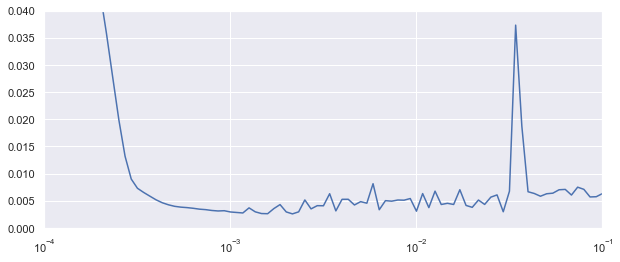

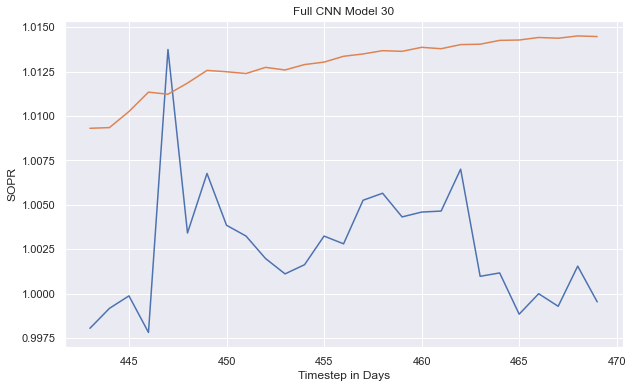

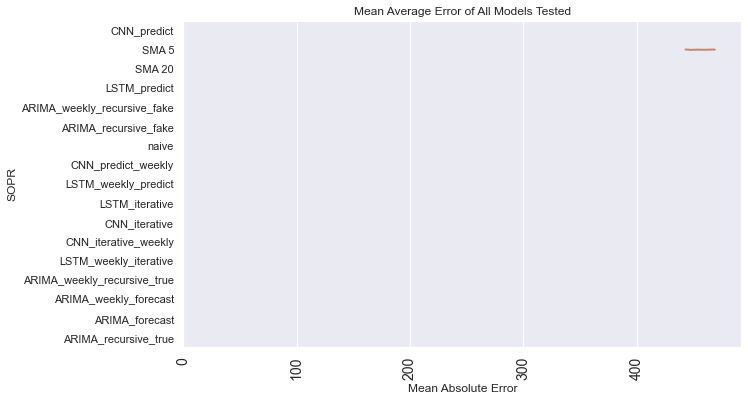

In [115]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 20
train_set = seq2seq_window_dataset(normalized_x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )

model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))

optimizer = keras.optimizers.Nadam(lr=1e-4)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

# Plot learning rate
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, .04])

#This is the best learning rate
my_lr = history.history["lr"][history.history["loss"].index(min(history.history["loss"]))]

# Clear any background data that may have stored
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Create input sequence batches
window_size = 30
train_set = seq2seq_window_dataset(normalized_x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(normalized_x_valid, window_size,
                                   batch_size=128)

# Create model object and set up wavenet architecture
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=128,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )

# Add final dense layer
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))

# Set Nadam as optimizer
optimizer = keras.optimizers.Nadam(lr=my_lr)

# Compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# save best model 
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)

# set early stopping
early_stopping = keras.callbacks.EarlyStopping(patience=50)

# sav history
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

# recall best model
model = keras.models.load_model("my_checkpoint")
# make predictions
yhat = normalized_x_test[0]
yhat = yhat[np.newaxis, :]
cnn_forecast = []
for i in range(len(normalized_x_test)):
    print(yhat.shape)
    yhat = model.predict(yhat)
    print(yhat.shape)
    print(i, "fatto")
    cnn_forecast.append(yhat)
    
cnn_forecast = np.array(cnn_forecast)
# Example of how to iverse
cnn_unscaled_forecast = x_train_scaler.inverse_transform(cnn_forecast.reshape(-1,1)).flatten()
cnn_unscaled_forecast.shape

# Plot results
plt.figure(figsize=(10, 6))

plt.ylabel('SOPR')
plt.xlabel('Timestep in Days')
plt.title(f'Full CNN Model {window_size}')
plt.plot(x_test.index, x_test)
plt.plot(x_test.index, cnn_unscaled_forecast)

# Calculate MAE
cnn = mean_absolute_error(x_test, cnn_unscaled_forecast)

# Save to our dictionary of model mae scores
model_mae_scores_weekly['CNN_iterative_weekly'] = cnn
model_mae_scores['CNN_iterative_weekly'] = cnn
model_mae_scores



# reload best model checkpoint
model = keras.models.load_model("my_checkpoint.h5")

# Use best model to get forecasts
cnn_forecast = model_forecast(model, spy_normalized_to_traindata[:,  np.newaxis], window_size)
cnn_forecast = cnn_forecast[x_test.index.min() - window_size:-1,-1,0]
# Scale back to normal
cnn_unscaled_forecast = x_train_scaler.inverse_transform(cnn_forecast.reshape(-1,1)).flatten()
cnn_unscaled_forecast.shape

# Plot results
plt.figure(figsize=(10, 6))

plt.ylabel('SOPR')
plt.xlabel('Timestep in Days')
plt.title(f'Full CNN Model {window_size}')
plt.plot(x_test.index, x_test)
plt.plot(x_test.index, cnn_unscaled_forecast)

# Calculate MAE
cnn = mean_absolute_error(x_test, cnn_unscaled_forecast)

# Save to our dictionary of model mae scores
model_mae_scores_weekly['CNN_predict_weekly'] = cnn
model_mae_scores['CNN_predict_weekly'] = cnn
model_mae_scores

mae_series = pd.Series(model_mae_scores)
model_mae_scores

# Sort vales for clean bar chart
order = mae_series.sort_values()

# Create bar chart for to show MAE of all models side by side
sns.barplot(x=order.values, y = order.index, orient='h')
plt.xlabel('Mean Absolute Error')
plt.xticks(rotation='vertical',fontsize=14)
plt.title('Mean Average Error of All Models Tested')

Text(0.5, 1.0, 'Mean Average Error of All Models Tested')

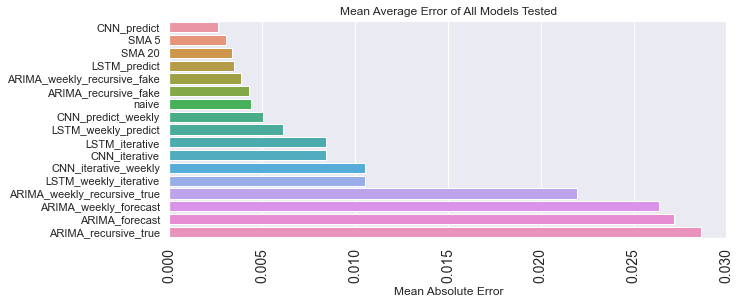

In [116]:
mae_series_weekly = pd.Series(model_mae_scores)
model_mae_scores

# Sort vales for clean bar chart
order = mae_series.sort_values()

# Create bar chart for to show MAE of all models side by side
sns.barplot(x=order.values, y = order.index, orient='h')
plt.xlabel('Mean Absolute Error')
plt.xticks(rotation='vertical',fontsize=14)
plt.title('Mean Average Error of All Models Tested')

Text(0.5, 1.0, 'Weekly Data - Mean Average Error of All Models Tested')

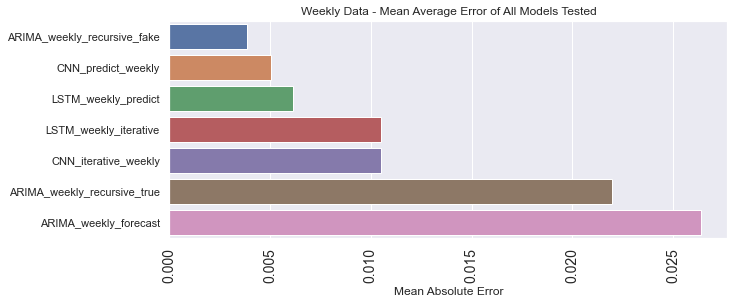

In [117]:
mae_series_weekly = pd.Series(model_mae_scores_weekly)
model_mae_scores_weekly

# Sort vales for clean bar chart
order = mae_series_weekly.sort_values()

# Create bar chart for to show MAE of all models side by side
sns.barplot(x=order.values, y = order.index, orient='h')
plt.xlabel('Mean Absolute Error')
plt.xticks(rotation='vertical',fontsize=14)
plt.title('Weekly Data - Mean Average Error of All Models Tested')